# Human readability judgments as a benchmark for large language models

### What are we doing here?
Ever wonder which of the many Large language models (LLMs) you can use to edit your text have the best understanding of what makes text 'readable'? Me too! Here, we will benchmark (prompt) a wide range of large language models on their ability to reproduce human judgments about the readability of short fictional and nonfictional passages. We'll test different models on different prompts, finding the best prompt we can for evaluating readability.

### Why bother?
Effective writing successfully communicates an idea or message, but sometimes the message can get lost. Many formulaic measures of readability exist that can signal to the author when revisions might be necessary. However, these measures generally focus on surface-level features of language, ignoring the larger context (e.g., audience, tone, style, etc.).

LLMs are ideally suited to capture the holistic readability of a text. During training, an LLM is exposed to a large and diverse corpus that includes text of varying levels of readability and from different contexts—from complex academic papers, to pulp fiction, to simple, everyday language. Although the model isn’t explicitly trained to assess readability, it develops a sense of what makes text coherent, fluent, and clear by constantly being asked to accurately predict the next word or phrase in an input that it receives. This is what enables these models to understand and respond in different writing styles, structures, tones, and vocabularies.

It can be difficult to interrogate the representations learned by deep neural networks, which makes trying to understand how a network represents something like readability very difficult. However, LLMs have an advantage. Unlike other architectures, they are trained to be directly interacted with through language. That means we can easily craft experiments where we manipulate the context for interaction (i.e., designing different prompts) to explore how the model's responses change, revealing something about their internal representations.

### Give me the result! I'm a busy bee I don't have time to read or run your notebook!
No problem ;) To get the absolute best estimate of the readability of a text:
+ Use Open AI's GPT4o-mini. It's cheap and gets a correlation of 0.8 (Spearman and Pearson) with human readability judgments. It's about as good as GPT4-Turbo. Mini worked best with a simple prompt:

    > You are an experienced teacher, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from 1 (extremely challenging to understand) to 100 (very easy to read and understand). In your assessment, consider factors such as sentence structure, vocabulary complexity, and overall clarity. Respond with only the scores, in the format '<Text1>: [score]'.

+ Otherwise, use Google's gemma2. With some prompts, the larger 27 billion parameter model works better. However, the 9 billion parameter model works nearly as well if not better. Here is the modelfile (including prompt) that worked best, receiving a correlation of 0.76, which is only marginally worse than GPT4o-mini:

```python
import ollama

modelfile = f'''
FROM gemma2

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
PARAMETER num_batch 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability.

Consider the following when assigning a score:
- **Vocabulary Complexity:** Are the words commonly used, or do they include technical jargon or advanced terminology?
- **Sentence Structure:** Are the sentences simple and straightforward, or complex with multiple clauses?
- **Clarity and Coherence:** Is the text easy to follow and understand, or does it contain ambiguous or convoluted statements?
- **Concept Familiarity:** Does the text discuss common knowledge topics, or does it delve into specialized subjects that may be unfamiliar to the students?

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability; suitable for the intended grade level.
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts.
""" '''


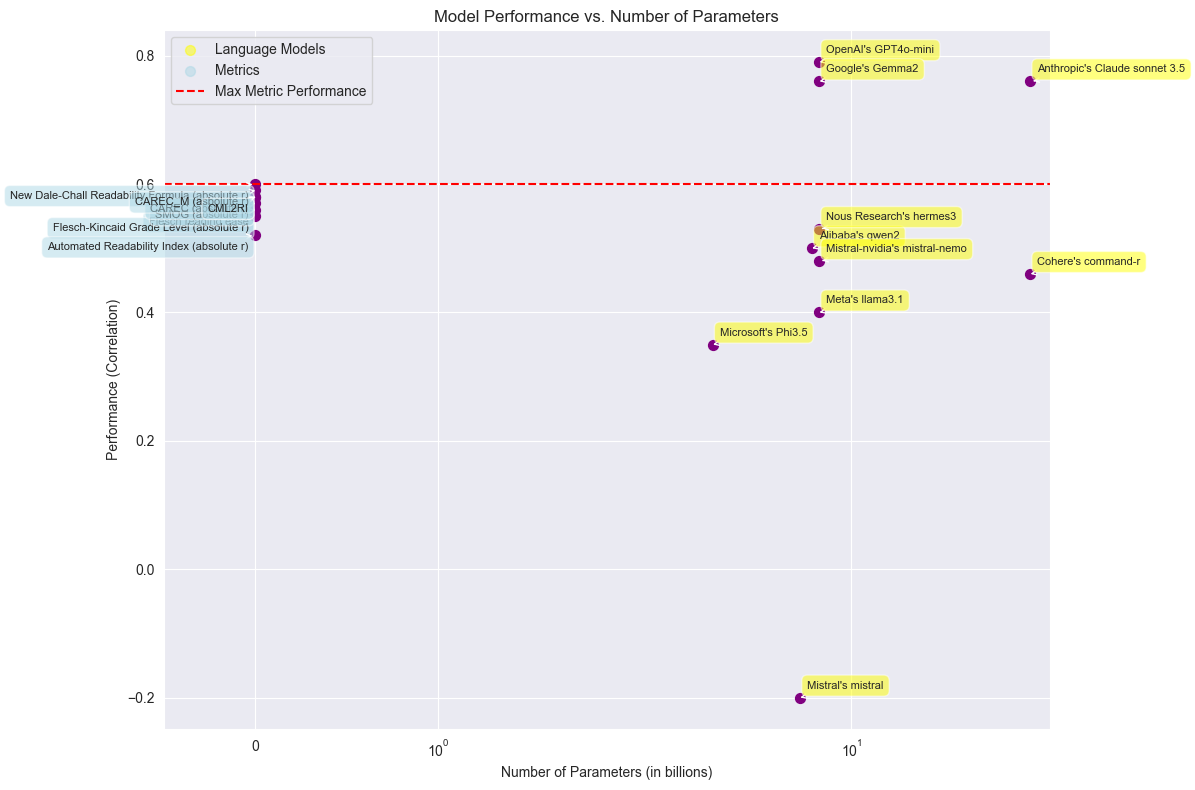

In [48]:
import matplotlib.pyplot as plt
import numpy as np

models = [
    "Microsoft's Phi3.5", "Alibaba's qwen2", "Mistral-nvidia's mistral-nemo",
    "Meta's llama3.1", "Nous Research's hermes3", "Cohere's command-r",
    "Mistral's mistral", "Anthropic's Claude sonnet 3.5", "OpenAI's GPT4o-mini",
    "Google's Gemma2", "Flesch reading ease", "Flesch-Kincaid Grade Level (absolute r)",
    "Automated Readability Index (absolute r)", "SMOG (absolute r)",
    "New Dale-Chall Readability Formula (absolute r)", "CAREC (absolute r)",
    "CAREC_M (asbolute r)", "CML2RI"
]

performance = [0.35, 0.5, 0.48, 0.4, 0.53, 0.46, -0.2, 0.76, 0.79, 0.76, 0.56, 0.55, 0.52, 0.57, 0.6, 0.58, 0.59, 0.58]
parameters = [3.8, 7.6, 8, 8, 8, 35, 7, 35, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0]

plt.figure(figsize=(12, 8))
scatter = plt.scatter(parameters, performance, s=50, color='purple')  # Changed dot color to purple

# Separate LLMs and metrics
llms = models[:10]
metrics = models[10:]

# Calculate the maximum performance of metrics
max_metric_performance = max(performance[10:])

# Add horizontal line at the maximum metric performance
plt.axhline(y=max_metric_performance, color='r', linestyle='--', label='Max Metric Performance')

# Annotate LLMs
for i, model in enumerate(llms):
    plt.annotate(model, (parameters[i], performance[i]),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=8, ha='left', va='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Annotate metrics
for i, metric in enumerate(metrics, start=10):
    plt.annotate(metric, (parameters[i], performance[i]),
                 xytext=(-5, -5), textcoords='offset points',
                 fontsize=8, ha='right', va='top',
                 bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.ylabel('Performance (Correlation)')
plt.xlabel('Number of Parameters (in billions)')
plt.title('Model Performance vs. Number of Parameters')

# Adjust x-axis to show more detail for lower parameter values
plt.xscale('symlog')
plt.xlim(-0.5, 40)

# Add a legend to distinguish LLMs from metrics and the threshold line
llm_proxy = plt.scatter([], [], s=50, c='yellow', alpha=0.5, label='Language Models')
metric_proxy = plt.scatter([], [], s=50, c='lightblue', alpha=0.5, label='Metrics')
plt.legend(handles=[llm_proxy, metric_proxy, plt.Line2D([0], [0], color='r', linestyle='--', label='Max Metric Performance')])

plt.tight_layout()
plt.show()

### **What You'll Need to Run the Notebook**

**The dataset:** [download here](https://github.com/scrosseye/CLEAR-Corpus)

This dataset contains 4,900 excerpts (just a paragraph or so each) that range from 3rd to 12th grade in reading level. The column `BT_easiness` represents human judgments of the readability of the passages. 1,800 teachers were asked to rate which of two pairs of texts from these 4,900 excerpts were easier for a student to understand, with each teacher making 100 comparisons. A Bradley-Terry model was used to measure the readability of each excerpt. The coefficients of this model are in the `BT_easiness` column of the spreadsheet that contains the dataset, and this is what we will see if the LLMs can replicate.

**The models:** [download Ollama](https://ollama.com/download). This API will let us quickly set up many different open-source models and run them locally. We also use the OpenAI and Claude APIs for paid models, so some of the experiments below will require having access to the appropriate API.

Here's the complete list of models we will look at (parameters//context):

- **OpenAI's GPT-4o-mini** (8B//128k) --> this is where we will hone the prompt
- **Anthropic's Claude 3.5 sonnet** (70B//200k)
- **Meta's Llama** (8B//128k)(70B//128k)
- **Mistral and NVIDIA's Mistral-nemo** (12B//128k)
- **Mistral's Mistral** (7B//4k)
- **Alphabet's Gemma 2** (2B//8k)(27B//8k)
- **Microsoft's WizardLM 2** (7B//8k)
- **Microsoft's Phi3.5** (3B//4k)
- **SmolLM** (1.7B//2k)
- **Nous Research's Hermes 3** (8B//128k)
- **Cohere's Command R** (35B//128k)
- **Alibaba's Qwen2** (7.6B//128k)

We'll also compare these models against standard formulaic measures of readability, which are provided with the CLEAR database:

- CAREC
- CAREC-M
- SMOG
- New Dale-Chall Readability
- CML2RI
- Flesch-Kincaid
- Automated Readability Index

### **A Quick Note Before We Start**

As I was working on this, I stumbled upon this really fantastic [blog/work](https://seantrott.substack.com/p/measuring-the-readability-of-texts) by Sean Trott that tried to do something similar with GPT-4oTurbo (and in his notebook, GPT-4o-mini). It's a great read, and I would highly encourage you to check it out. Unfortunately for me, his prompt worked a little bit better than the one I started out with. However, with some tweaks to the code and prompt, it's possible to improve on Sean's results such that GPT-4o-mini performs better than the reported performance for GPT-4oTurbo, and some open-source models perform nearly as well too, but with more substantial prompt changes.


First, let's import (most of) the modules we'll need.

In [1]:
import pandas as pd
import subprocess
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from nltk import word_tokenize, sent_tokenize
from openai import OpenAI
import openai
import backoff
import time
from sklearn.preprocessing import StandardScaler
import ollama

sns.set_theme(style="white", palette='crest')
%matplotlib inline

Now let's import our dataset

In [12]:
df = pd.read_excel(r'C:\Users\alext\Downloads\CLEAR-Corpus-main\CLEAR-Corpus-main\CLEAR_corpus_final.xlsx', engine='openpyxl')

## **Early experiments with GPT4o-mini**

We're going to start with open AI. Spoiler alert, it's quite good right out of the box...we'll experiment with a very simple and intuitive prompt to get a baseline of performance. Then, we'll see whether any open source (free) models can can compete with the same prompt and keep tweaking the prompt until we get competitive performance with open AI. Finally, we will test the prompt tuned for the open source models with GPT4o-mini so we have a more direct comparison (and on claude's sonnet 3.5).

First, set up the openAI client (paste in your own api key)

In [4]:
openai.api_key = ""
client = OpenAI(api_key=openai.api_key)

Let's set up some functions we'll need for openAI

In [3]:
def chunk_list(lst, chunk_size):
    """Split the list into chunks of specified size."""
    return [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]

def format_prompt(instructions, texts):
    formatted_texts = "\n\n".join(f"<Text{i+1}>:{text}</Text{i+1}>" for i, text in enumerate(texts))
    return f"{instructions}\n\n{formatted_texts}"

@backoff.on_exception(backoff.expo, Exception, max_tries=5)
def process_batch(batch, system_prompt, instructions, model="gpt-4o-mini", temperature=0):
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": format_prompt(instructions, batch)}
    ]
    try:
        completion = client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=temperature,
            n=1
        )
        # Log the raw response for debugging
        response = completion.choices[0].message.content
        #print(f"Raw API Response: {response}")

        # Extract scores, handling both scores with and without brackets
        pattern = r'<Text\d+>:\s*\[?(\d+)\]?'
        scores = [int(score) for score in re.findall(pattern, response)]
        #print(f"Extracted Scores: {scores}")

        # Check for mismatch
        if len(scores) != len(batch):
            print(f"Mismatch detected. Scores received: {len(scores)}, Batch size: {len(batch)}")
            raise ValueError("Mismatch between scores and batch length")

        return scores
    except Exception as e:
        print(f"Error processing batch: {e}")
        return [None] * len(batch)


def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def get_number(ans):
    """Retrieves number from GPT-4 response."""
    if type(ans) is int:
        return ans
    res = [float(i) for i in ans.split() if is_number(i)]
    return res[0] if res else None

Let's set up the parameters for our model, including the prompt and instructions. We'll send 5 excerpts to the model each time we make an API call. To come up with the instructions for the model, I had the new GPT 4o come up with a prompt, then refined it.

Here was my request: "What is a good prompt for instructing a large-language model to evaluate the readability of small excerpts of text (around 500 words)"

Here was GPT4o's response: Prompt: "Evaluate the readability of the following excerpt of text. Consider factors such as sentence length and complexity, vocabulary difficulty, clarity of expression, and overall ease of understanding. Provide an analysis that includes the readability score (using a common formula such as Flesch-Kincaid or a similar metric), potential target audience (age or education level), and specific suggestions for improving readability, if necessary."

We don't want the model to rely on formulas so I removed that and added the word holistic to focus the model on a broader assessment of readability. I then elaborated on a few of the readability factors that were provided and added a small scoring range so that I could define what each value represented. Note also, we are going to make the model answer in a specific format so that it is easier to process its output for multiple texts.

The prompt generated by GPT4o was more "instruction" than "prompt" so we'll show the model the instructions along with the excerpts, and create a separate system prompt. It's generally advised for system prompts to be short, steering the model in a general direction. Instructions are more specific guidelines or rules that the model should follow and come attached with the actual data that you want it to process.

In practice, I did not find a difference when having no instruction and moving either the instructions immediately below or lengthier instructions that follow into the system prompt. You can try this yourself or see some of the experiments further below.

In [ ]:
# GPT setup
MODEL = "gpt-4o-mini" # this pulls the most recent version of 4o-mini so you don't need to provide a date
BATCH_SIZE = 5  # Adjust based on API limits and your needs
system_prompt = "You are an expert in linguistics and writing analysis, specializing in assessing the readability and comprehensibility of texts for various audiences."
instructions = "Holistically evaluate the readability of the following text. In your evaluation, consider factors such as vocabulary complexity, sentence structure and length, overall clarity and coherence, conceptual difficulty, text organization and flow, and whether the assumed background knowledge is appropriate for the audience. Respond with a readability score in the format '<Text>: [score]'. The score ranges from 1 to 5, where 1 = Very difficult to read, 2 = Difficult to read, 3 = Moderately readable, 4 = Easy to read, 5 = Very easy to read. Only provide the readability score."

Now we'll bin our data into batches. That means we'll send OpenAI a series of excerpts from our data together and have their model generate an output for them all. As there are limits on the number of API calls per day for free and Tier 1 accounts (that's anyone just starting out with the OpenAI API), this is super helpful. Those limits are quite low. If we were to process each excerpt individually, we would hit the current \(5000\) requests per day limit for Tier 1. Afterwards, your requests are either rejected outright or throttled. This may be different for you, but I noticed a processing speed of roughly 10-20 seconds per excerpt after hitting the limit (that comes out to roughly 14 hours of run time if processing the entire dataset after hitting the limit).

There are a few things worth mentioning before we start:
- Batch processing is NOT the `Batch API`. We're using `gpt 4o mini`, which is quite cheap, but we will not receive the Batch API discount (50% off). Depending on batch size, your cost to run this will range from a few cents to a dollar.
- When batch processing data like we are above, the model will get a single request, but it will apply the prompt separately to each excerpt. **Feel free to run the code below, but to anticipate some of the experiments in this notebook, we get a considerable boost in accuracy of readability judgments when having the model only process a single excerpt (batch size of 1). This is because the model is adjusting its readability judgments based on the sample of excerpts in the entire batch.**


In [5]:
excerpts = df['Excerpt'].tolist()
batches = [excerpts[i:i + BATCH_SIZE] for i in range(0, len(excerpts), BATCH_SIZE)]

And let's start processing the data now. Note, I had some debugging issues, so there are extra outputs here that you won't see. Feel free to remove commented-out print commands to get the same feedback.

The last thing to mention is that we will be using a 'temperature' of '0'. That means model outputs will be more deterministic because it will not randomly select among a small set of the most likely tokens the model should be outputting based on our inputs.

In [18]:
results = []
for batch in tqdm(batches, total=len(batches)):
    batch_results = process_batch(batch, system_prompt, instructions, MODEL)

    # If the batch result is incomplete, retry failed excerpts
    if len(batch_results) != len(batch) or any(result is None for result in batch_results):
        print(f"Retrying failed excerpts in the batch...")
        for i, result in enumerate(batch_results):
            if result is None:  # Retry only the failed excerpts
                individual_result = process_batch([batch[i]], system_prompt, instructions, MODEL)
                batch_results[i] = individual_result[0]

    results.extend(batch_results)
    time.sleep(1)  # Small delay to avoid rate limiting


  0%|          | 0/945 [00:00<?, ?it/s]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [3, 4, 4, 2, 3]


  0%|          | 1/945 [00:01<30:16,  1.92s/it]

Raw API Response: <Text1>: 5  
<Text2>: 3  
<Text3>: 3  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [5, 3, 3, 2, 4]


  0%|          | 2/945 [00:03<27:10,  1.73s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 3, 3, 4, 4]


  0%|          | 3/945 [00:05<26:12,  1.67s/it]

Raw API Response: <Text1>: 4  
<Text2>: 5  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 5, 3, 4, 3]


  0%|          | 4/945 [00:06<25:24,  1.62s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [3, 4, 3, 2, 3]


  1%|          | 5/945 [00:08<25:20,  1.62s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [4]
Extracted Scores: [2, 4, 3, 4, 4]


  1%|          | 6/945 [00:09<25:19,  1.62s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [3, 3, 4, 4, 5]


  1%|          | 7/945 [00:11<24:41,  1.58s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 5  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 4, 5, 3, 4]


  1%|          | 8/945 [00:12<24:26,  1.57s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [3, 2, 4, 5, 4]


  1%|          | 9/945 [00:14<24:43,  1.59s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 5
Extracted Scores: [4, 3, 4, 3, 5]


  1%|          | 10/945 [00:16<24:38,  1.58s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 4, 4, 3, 4]


  1%|          | 11/945 [00:17<24:15,  1.56s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 3, 3, 4, 4]


  1%|▏         | 12/945 [00:19<25:02,  1.61s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 3, 4, 4, 3]


  1%|▏         | 13/945 [00:21<25:37,  1.65s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [4]  
<Text5>: [5]
Extracted Scores: [2, 3, 4, 4, 5]


  1%|▏         | 14/945 [00:23<26:49,  1.73s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 4, 3, 4]


  2%|▏         | 15/945 [00:24<26:03,  1.68s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [5]
Extracted Scores: [2, 4, 3, 4, 5]


  2%|▏         | 16/945 [00:26<25:56,  1.68s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 4, 3, 4, 4]


  2%|▏         | 17/945 [00:27<25:39,  1.66s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 5  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [4, 4, 5, 3, 3]


  2%|▏         | 18/945 [00:29<26:32,  1.72s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [4]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [3, 4, 4, 4, 3]


  2%|▏         | 19/945 [00:31<26:06,  1.69s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 3, 4, 3]


  2%|▏         | 20/945 [00:32<25:24,  1.65s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 3, 4, 4, 4]


  2%|▏         | 21/945 [00:34<25:39,  1.67s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 3, 4, 3]


  2%|▏         | 22/945 [00:36<24:56,  1.62s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 3, 4, 4, 3]


  2%|▏         | 23/945 [00:37<25:49,  1.68s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 4, 4, 3]


  3%|▎         | 24/945 [00:42<36:58,  2.41s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 5  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 4, 5, 3, 4]


  3%|▎         | 25/945 [00:43<32:51,  2.14s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 3, 3, 4]


  3%|▎         | 26/945 [00:45<30:44,  2.01s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [3, 3, 4, 3, 3]


  3%|▎         | 27/945 [00:46<28:21,  1.85s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 3, 4, 4, 3]


  3%|▎         | 28/945 [00:48<27:13,  1.78s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 3, 4, 3, 4]


  3%|▎         | 29/945 [00:49<26:17,  1.72s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 4, 3, 4]


  3%|▎         | 30/945 [00:51<25:50,  1.69s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 4, 3, 3, 4]


  3%|▎         | 31/945 [00:53<24:54,  1.63s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 4, 4, 4, 4]


  3%|▎         | 32/945 [00:54<24:25,  1.61s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [3, 3, 4, 4, 5]


  3%|▎         | 33/945 [00:56<23:59,  1.58s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 2, 4, 4, 3]


  4%|▎         | 34/945 [00:57<23:57,  1.58s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 3, 4, 4, 4]


  4%|▎         | 35/945 [00:59<24:07,  1.59s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [3, 2, 4, 4, 5]


  4%|▍         | 36/945 [01:00<23:55,  1.58s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [3, 4, 3, 3, 2]


  4%|▍         | 37/945 [01:02<24:58,  1.65s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 3, 3, 4, 3]


  4%|▍         | 38/945 [01:04<24:18,  1.61s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 4, 3, 4]


  4%|▍         | 39/945 [01:05<24:13,  1.60s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [3, 2, 4, 5, 4]


  4%|▍         | 40/945 [01:07<23:51,  1.58s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 3, 4, 4, 4]


  4%|▍         | 41/945 [01:08<23:52,  1.58s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 3, 4, 3]


  4%|▍         | 42/945 [01:10<23:47,  1.58s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3  
Extracted Scores: [2, 4, 3, 4, 3]


  5%|▍         | 43/945 [01:12<24:10,  1.61s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [3, 4, 3, 4, 2]


  5%|▍         | 44/945 [01:13<24:42,  1.65s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [4, 3, 4, 4, 5]


  5%|▍         | 45/945 [01:16<27:30,  1.83s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [3, 4, 4, 3, 3]


  5%|▍         | 46/945 [01:17<26:06,  1.74s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 3, 4, 4, 4]


  5%|▍         | 47/945 [01:19<25:55,  1.73s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [3, 4, 2, 5, 3]


  5%|▌         | 48/945 [01:21<27:05,  1.81s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [3, 4, 3, 4, 5]


  5%|▌         | 49/945 [01:22<25:41,  1.72s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [4, 4, 3, 2, 3]


  5%|▌         | 50/945 [01:24<24:54,  1.67s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 4, 3, 4, 3]


  5%|▌         | 51/945 [01:26<25:39,  1.72s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [4, 3, 4, 2, 3]


  6%|▌         | 52/945 [01:27<24:44,  1.66s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [2, 4, 4, 3, 2]


  6%|▌         | 53/945 [01:29<24:13,  1.63s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [3]  
<Text5>: [5]
Extracted Scores: [2, 3, 4, 3, 5]


  6%|▌         | 54/945 [01:31<24:34,  1.65s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [3, 4, 3, 3, 3]


  6%|▌         | 55/945 [01:32<24:27,  1.65s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 3, 4, 3]


  6%|▌         | 56/945 [01:34<23:41,  1.60s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 2  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 4, 2, 4, 3]


  6%|▌         | 57/945 [01:35<23:40,  1.60s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 2  
<Text4>: 3  
<Text5>: 5
Extracted Scores: [4, 3, 2, 3, 5]


  6%|▌         | 58/945 [01:37<23:14,  1.57s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [3, 2, 4, 3, 3]


  6%|▌         | 59/945 [01:39<24:07,  1.63s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 4, 3, 4, 3]


  6%|▋         | 60/945 [01:40<23:43,  1.61s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 5  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 3, 5, 3, 4]


  6%|▋         | 61/945 [01:42<23:14,  1.58s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 4, 3, 3, 4]


  7%|▋         | 62/945 [01:43<23:20,  1.59s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [4, 3, 3, 2, 3]


  7%|▋         | 63/945 [01:45<23:11,  1.58s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [2, 3, 3, 2, 3]


  7%|▋         | 64/945 [01:46<23:30,  1.60s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [2, 3, 3, 3, 3]


  7%|▋         | 65/945 [01:48<23:17,  1.59s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 3, 4, 4, 3]


  7%|▋         | 66/945 [01:50<23:26,  1.60s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [2, 4, 3, 3, 3]


  7%|▋         | 67/945 [01:51<23:54,  1.63s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 3, 4, 4, 3]


  7%|▋         | 68/945 [01:54<27:54,  1.91s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 3, 3, 4, 4]


  7%|▋         | 69/945 [01:56<26:35,  1.82s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [5]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 3, 5, 3, 4]


  7%|▋         | 70/945 [01:57<26:00,  1.78s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3  
Extracted Scores: [2, 4, 3, 4, 3]


  8%|▊         | 71/945 [01:59<25:29,  1.75s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [3, 4, 4, 3, 2]


  8%|▊         | 72/945 [02:01<25:13,  1.73s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [2, 3, 4, 4, 5]


  8%|▊         | 73/945 [02:02<24:28,  1.68s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [4, 3, 4, 2, 3]


  8%|▊         | 74/945 [02:04<24:09,  1.66s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 3, 4, 4, 3]


  8%|▊         | 75/945 [02:06<24:26,  1.69s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [3, 4, 3, 4, 2]


  8%|▊         | 76/945 [02:07<23:52,  1.65s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [4]  
<Text4>: [3]  
<Text5>: [3]
Extracted Scores: [3, 4, 4, 3, 3]


  8%|▊         | 77/945 [02:09<24:19,  1.68s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [3, 4, 4, 3, 3]


  8%|▊         | 78/945 [02:10<23:45,  1.64s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 2, 3, 4, 4]


  8%|▊         | 79/945 [02:12<23:26,  1.62s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [3, 4, 2, 2, 4]


  8%|▊         | 80/945 [02:14<23:02,  1.60s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 3  
<Text5>: 5  
Extracted Scores: [2, 3, 3, 3, 5]


  9%|▊         | 81/945 [02:15<23:35,  1.64s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3  
Extracted Scores: [2, 4, 3, 4, 3]


  9%|▊         | 82/945 [02:17<23:28,  1.63s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 4, 3, 3, 4]


  9%|▉         | 83/945 [02:19<27:03,  1.88s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [3]  
<Text3>: [2]  
<Text4>: [4]  
<Text5>: [5]  
Extracted Scores: [3, 3, 2, 4, 5]


  9%|▉         | 84/945 [02:21<26:08,  1.82s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 5  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 2, 5, 3, 4]


  9%|▉         | 85/945 [02:23<25:39,  1.79s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 2  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [3, 3, 2, 2, 4]


  9%|▉         | 86/945 [02:24<25:23,  1.77s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [5, 4, 3, 3, 2]


  9%|▉         | 87/945 [02:26<24:57,  1.75s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [3, 4, 3, 2, 4]


  9%|▉         | 88/945 [02:30<34:13,  2.40s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [3, 3, 4, 2, 4]


  9%|▉         | 89/945 [02:32<30:34,  2.14s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 2, 4, 3]


 10%|▉         | 90/945 [02:33<28:07,  1.97s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3  
Extracted Scores: [2, 4, 3, 4, 3]


 10%|▉         | 91/945 [02:35<26:31,  1.86s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 2, 3, 4]


 10%|▉         | 92/945 [02:36<25:25,  1.79s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [4, 3, 4, 3, 2]


 10%|▉         | 93/945 [02:38<24:08,  1.70s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [2, 4, 3, 3, 3]


 10%|▉         | 94/945 [02:40<23:41,  1.67s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [3, 4, 2, 3, 3]


 10%|█         | 95/945 [02:41<23:22,  1.65s/it]

Raw API Response: <Text1>: 5  
<Text2>: 3  
<Text3>: 2  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [5, 3, 2, 3, 3]


 10%|█         | 96/945 [02:43<23:28,  1.66s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 5  
<Text4>: 3  
<Text5>: 2  
Extracted Scores: [2, 4, 5, 3, 2]


 10%|█         | 97/945 [02:45<23:49,  1.69s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [3, 2, 4, 3, 2]


 10%|█         | 98/945 [02:46<23:10,  1.64s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [3, 4, 2, 2, 4]


 10%|█         | 99/945 [02:48<23:17,  1.65s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [4, 4, 3, 2, 3]


 11%|█         | 100/945 [02:50<23:46,  1.69s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [3, 4, 3, 4, 2]


 11%|█         | 101/945 [02:51<23:32,  1.67s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 2  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 3, 2, 4, 3]


 11%|█         | 102/945 [02:53<23:20,  1.66s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3  
Extracted Scores: [4, 2, 3, 4, 3]


 11%|█         | 103/945 [02:54<23:21,  1.66s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [5]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 4, 5, 3, 4]


 11%|█         | 104/945 [02:56<23:01,  1.64s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [5]  
<Text4>: [3]  
<Text5>: [3]
Extracted Scores: [2, 4, 5, 3, 3]


 11%|█         | 105/945 [02:58<22:55,  1.64s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 3, 4, 3]


 11%|█         | 106/945 [02:59<22:25,  1.60s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 4  
<Text4>: 2  
<Text5>: 3  
Extracted Scores: [2, 4, 4, 2, 3]


 11%|█▏        | 107/945 [03:01<22:10,  1.59s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 2  
<Text5>: 2
Extracted Scores: [4, 3, 3, 2, 2]


 11%|█▏        | 108/945 [03:02<22:01,  1.58s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4  
Extracted Scores: [2, 4, 3, 3, 4]


 12%|█▏        | 109/945 [03:04<22:00,  1.58s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 3, 3, 4]


 12%|█▏        | 110/945 [03:06<22:19,  1.60s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 5  
<Text4>: 3  
<Text5>: 3  
Extracted Scores: [4, 2, 5, 3, 3]


 12%|█▏        | 111/945 [03:07<22:03,  1.59s/it]

Raw API Response: <Text1>: 5  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [5, 3, 3, 4, 3]


 12%|█▏        | 112/945 [03:09<21:41,  1.56s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 4, 3, 3, 4]


 12%|█▏        | 113/945 [03:10<21:46,  1.57s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [3, 4, 2, 4, 2]


 12%|█▏        | 114/945 [03:12<21:49,  1.58s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 2  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 3, 2, 3, 4]


 12%|█▏        | 115/945 [03:14<22:27,  1.62s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [3]  
<Text5>: [3]
Extracted Scores: [3, 3, 4, 3, 3]


 12%|█▏        | 116/945 [03:15<22:54,  1.66s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 2  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 3, 2, 3, 4]


 12%|█▏        | 117/945 [03:17<22:43,  1.65s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [4, 3, 3, 4, 2]


 12%|█▏        | 118/945 [03:18<22:31,  1.63s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 2, 4, 3, 4]


 13%|█▎        | 119/945 [03:20<22:34,  1.64s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [3, 3, 4, 4, 3]


 13%|█▎        | 120/945 [03:22<22:39,  1.65s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [2]  
<Text4>: [1]  
<Text5>: [4]
Extracted Scores: [2, 3, 2, 1, 4]


 13%|█▎        | 121/945 [03:23<22:40,  1.65s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [3, 4, 3, 2, 4]


 13%|█▎        | 122/945 [03:25<22:05,  1.61s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 5  
<Text5>: 2
Extracted Scores: [3, 4, 4, 5, 2]


 13%|█▎        | 123/945 [03:27<21:50,  1.59s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [4, 3, 4, 2, 4]


 13%|█▎        | 124/945 [03:28<21:44,  1.59s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [5]  
<Text5>: [4]
Extracted Scores: [3, 3, 4, 5, 4]


 13%|█▎        | 125/945 [03:30<22:02,  1.61s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [3, 4, 3, 3, 4]


 13%|█▎        | 126/945 [03:31<22:03,  1.62s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [2, 4, 3, 4, 5]


 13%|█▎        | 127/945 [03:33<21:58,  1.61s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 2, 3, 3, 4]


 14%|█▎        | 128/945 [03:35<22:11,  1.63s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 4  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [4, 4, 4, 2, 3]


 14%|█▎        | 129/945 [03:36<22:01,  1.62s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 3, 4, 3]


 14%|█▍        | 130/945 [03:38<21:52,  1.61s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3  
Extracted Scores: [2, 4, 3, 4, 3]


 14%|█▍        | 131/945 [03:39<21:32,  1.59s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [3, 3, 4, 2, 3]


 14%|█▍        | 132/945 [03:41<21:35,  1.59s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [3, 4, 4, 3, 3]


 14%|█▍        | 133/945 [03:43<21:21,  1.58s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [3, 4, 4, 5, 3]


 14%|█▍        | 134/945 [03:44<21:05,  1.56s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 5  
<Text5>: 2
Extracted Scores: [4, 3, 3, 5, 2]


 14%|█▍        | 135/945 [03:46<21:06,  1.56s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 2  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [4, 3, 2, 3, 3]


 14%|█▍        | 136/945 [03:47<21:09,  1.57s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [4, 3, 3, 4, 2]


 14%|█▍        | 137/945 [03:50<27:25,  2.04s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 3, 4, 4, 3]


 15%|█▍        | 138/945 [03:52<25:17,  1.88s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3  
Extracted Scores: [2, 3, 3, 4, 3]


 15%|█▍        | 139/945 [03:53<23:39,  1.76s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [2, 4, 3, 4, 5]


 15%|█▍        | 140/945 [03:55<22:30,  1.68s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 3, 3, 4, 4]


 15%|█▍        | 141/945 [03:57<24:02,  1.79s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 2  
<Text5>: 2
Extracted Scores: [4, 3, 3, 2, 2]


 15%|█▌        | 142/945 [03:59<23:29,  1.76s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3  
Extracted Scores: [2, 3, 4, 4, 3]


 15%|█▌        | 143/945 [04:00<22:36,  1.69s/it]

Raw API Response: <Text1>: 5  
<Text2>: 3  
<Text3>: 2  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [5, 3, 2, 5, 4]


 15%|█▌        | 144/945 [04:02<22:16,  1.67s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 2  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [4, 3, 2, 2, 4]


 15%|█▌        | 145/945 [04:03<21:58,  1.65s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [2, 4, 3, 4, 4]


 15%|█▌        | 146/945 [04:05<22:43,  1.71s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [2]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [2, 4, 2, 4, 3]


 16%|█▌        | 147/945 [04:07<22:24,  1.68s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3  
Extracted Scores: [2, 4, 3, 4, 3]


 16%|█▌        | 148/945 [04:09<22:49,  1.72s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [5]  
<Text4>: [3]  
<Text5>: [4]  
Extracted Scores: [2, 3, 5, 3, 4]


 16%|█▌        | 149/945 [04:10<22:26,  1.69s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 5  
<Text4>: 3  
<Text5>: 5
Extracted Scores: [4, 3, 5, 3, 5]


 16%|█▌        | 150/945 [04:12<22:13,  1.68s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [2]  
<Text5>: [3]
Extracted Scores: [3, 4, 3, 2, 3]


 16%|█▌        | 151/945 [04:13<21:52,  1.65s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 3, 4, 4, 4]


 16%|█▌        | 152/945 [04:15<21:20,  1.61s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 2  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 2, 2, 4, 3]


 16%|█▌        | 153/945 [04:17<21:12,  1.61s/it]

Raw API Response: <Text1>: [1]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [3]
Extracted Scores: [1, 4, 3, 3, 3]


 16%|█▋        | 154/945 [04:18<21:18,  1.62s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [3, 3, 4, 2, 4]


 16%|█▋        | 155/945 [04:20<20:52,  1.59s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 3, 3, 3, 4]


 17%|█▋        | 156/945 [04:21<20:39,  1.57s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [5]  
<Text5>: [3]
Extracted Scores: [2, 4, 3, 5, 3]


 17%|█▋        | 157/945 [04:23<20:54,  1.59s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [3, 4, 3, 4, 3]


 17%|█▋        | 158/945 [04:24<20:48,  1.59s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 5  
<Text5>: 2
Extracted Scores: [4, 3, 3, 5, 2]


 17%|█▋        | 159/945 [04:26<20:42,  1.58s/it]

Raw API Response: <Text1>: 5  
<Text2>: 2  
<Text3>: 4  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [5, 2, 4, 3, 2]


 17%|█▋        | 160/945 [04:28<21:07,  1.62s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 5  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [5, 4, 5, 3, 3]


 17%|█▋        | 161/945 [04:29<20:41,  1.58s/it]

Raw API Response: <Text1>: [4]  
<Text2>: [3]  
<Text3>: [2]  
<Text4>: [5]  
<Text5>: [4]  
Extracted Scores: [4, 3, 2, 5, 4]


 17%|█▋        | 162/945 [04:31<21:48,  1.67s/it]

Raw API Response: <Text1>: 5  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [5, 3, 3, 4, 2]


 17%|█▋        | 163/945 [04:33<21:11,  1.63s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [4, 3, 4, 3, 2]


 17%|█▋        | 164/945 [04:34<21:05,  1.62s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 2  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [4, 3, 2, 2, 4]


 17%|█▋        | 165/945 [04:36<20:39,  1.59s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [2, 3, 3, 4, 5]


 18%|█▊        | 166/945 [04:37<20:18,  1.56s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 3, 3, 4, 3]


 18%|█▊        | 167/945 [04:39<20:24,  1.57s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [4]  
<Text5>: [5]
Extracted Scores: [2, 3, 4, 4, 5]


 18%|█▊        | 168/945 [04:40<20:10,  1.56s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [5]  
<Text5>: [3]
Extracted Scores: [2, 4, 3, 5, 3]


 18%|█▊        | 169/945 [04:42<20:09,  1.56s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 3  
<Text5>: 5
Extracted Scores: [3, 2, 4, 3, 5]


 18%|█▊        | 170/945 [04:43<19:54,  1.54s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 4  
<Text4>: 5  
<Text5>: 1
Extracted Scores: [4, 2, 4, 5, 1]


 18%|█▊        | 171/945 [04:45<19:33,  1.52s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 2
Extracted Scores: [3, 4, 3, 2, 2]


 18%|█▊        | 172/945 [04:46<19:45,  1.53s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 2, 4, 3, 4]


 18%|█▊        | 173/945 [04:48<19:45,  1.54s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 2, 4, 3]


 18%|█▊        | 174/945 [04:50<21:12,  1.65s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 5  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [2, 4, 5, 3, 2]


 19%|█▊        | 175/945 [04:51<20:38,  1.61s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 2  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [5, 4, 2, 3, 4]


 19%|█▊        | 176/945 [04:53<21:22,  1.67s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 1  
<Text5>: 5
Extracted Scores: [2, 3, 4, 1, 5]


 19%|█▊        | 177/945 [04:55<20:59,  1.64s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [4]
Extracted Scores: [2, 3, 3, 4, 4]


 19%|█▉        | 178/945 [04:56<20:46,  1.62s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [2, 3, 3, 4, 4]


 19%|█▉        | 179/945 [04:58<20:26,  1.60s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [2, 4, 3, 3, 3]


 19%|█▉        | 180/945 [04:59<20:03,  1.57s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [3, 4, 2, 2, 4]


 19%|█▉        | 181/945 [05:01<20:12,  1.59s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [5, 4, 3, 4, 3]


 19%|█▉        | 182/945 [05:03<20:06,  1.58s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 2  
Extracted Scores: [3, 4, 4, 3, 2]


 19%|█▉        | 183/945 [05:04<20:01,  1.58s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [2, 4, 3, 4, 4]


 19%|█▉        | 184/945 [05:06<20:09,  1.59s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 2, 3, 4, 3]


 20%|█▉        | 185/945 [05:07<20:14,  1.60s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [4, 3, 3, 4, 5]


 20%|█▉        | 186/945 [05:09<20:07,  1.59s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [2]  
<Text5>: [3]
Extracted Scores: [3, 4, 3, 2, 3]


 20%|█▉        | 187/945 [05:11<19:59,  1.58s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [2]  
<Text3>: [5]  
<Text4>: [4]  
<Text5>: [3]  
Extracted Scores: [3, 2, 5, 4, 3]


 20%|█▉        | 188/945 [05:12<20:11,  1.60s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 3, 3, 4, 3]


 20%|██        | 189/945 [05:14<19:46,  1.57s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [4, 4, 3, 2, 3]


 20%|██        | 190/945 [05:15<19:56,  1.58s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 3, 3, 3, 4]


 20%|██        | 191/945 [05:17<20:09,  1.60s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 4, 3, 3, 4]


 20%|██        | 192/945 [05:19<19:56,  1.59s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 4  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [5, 4, 4, 2, 3]


 20%|██        | 193/945 [05:20<19:35,  1.56s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [5]
Extracted Scores: [3, 4, 3, 4, 5]


 21%|██        | 194/945 [05:22<19:53,  1.59s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [3, 4, 4, 3, 2]


 21%|██        | 195/945 [05:23<19:57,  1.60s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [4, 4, 4, 3, 3]


 21%|██        | 196/945 [05:25<19:57,  1.60s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 4, 2, 4, 4]


 21%|██        | 197/945 [05:27<20:21,  1.63s/it]

Raw API Response: <Text1>: 3  
<Text2>: 5  
<Text3>: 2  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [3, 5, 2, 2, 3]


 21%|██        | 198/945 [05:28<19:59,  1.61s/it]

Raw API Response: <Text1>: 3  
<Text2>: 5  
<Text3>: 4  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [3, 5, 4, 2, 4]


 21%|██        | 199/945 [05:30<19:38,  1.58s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 4, 3, 3, 4]


 21%|██        | 200/945 [05:31<19:47,  1.59s/it]

Raw API Response: <Text1>: 3  
<Text2>: 5  
<Text3>: 4  
<Text4>: 2  
<Text5>: 2  
Extracted Scores: [3, 5, 4, 2, 2]


 21%|██▏       | 201/945 [05:33<19:59,  1.61s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 2  
<Text5>: 5  
Extracted Scores: [3, 3, 4, 2, 5]


 21%|██▏       | 202/945 [05:35<20:18,  1.64s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [4, 3, 3, 5, 3]


 21%|██▏       | 203/945 [05:36<20:03,  1.62s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 4, 3, 3, 4]


 22%|██▏       | 204/945 [05:38<19:59,  1.62s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 4, 3, 4]


 22%|██▏       | 205/945 [05:40<19:58,  1.62s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [5]  
<Text5>: [3]
Extracted Scores: [3, 4, 3, 5, 3]


 22%|██▏       | 206/945 [05:41<20:11,  1.64s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 5
Extracted Scores: [3, 4, 4, 3, 5]


 22%|██▏       | 207/945 [05:43<20:06,  1.63s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [3, 4, 3, 4, 3]


 22%|██▏       | 208/945 [05:45<20:23,  1.66s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 5  
<Text4>: 2  
<Text5>: 2
Extracted Scores: [4, 3, 5, 2, 2]


 22%|██▏       | 209/945 [05:46<20:07,  1.64s/it]

Raw API Response: <Text1>: [4]  
<Text2>: [4]  
<Text3>: [2]  
<Text4>: [3]  
<Text5>: [3]
Extracted Scores: [4, 4, 2, 3, 3]


 22%|██▏       | 210/945 [05:48<20:54,  1.71s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 3, 4, 3, 4]


 22%|██▏       | 211/945 [05:50<21:03,  1.72s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [4, 3, 3, 4, 5]


 22%|██▏       | 212/945 [05:51<20:45,  1.70s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 5  
<Text5>: 5
Extracted Scores: [3, 4, 2, 5, 5]


 23%|██▎       | 213/945 [05:53<20:29,  1.68s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 5  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 3, 5, 3, 4]


 23%|██▎       | 214/945 [05:55<20:22,  1.67s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 4, 3, 4]


 23%|██▎       | 215/945 [05:56<20:14,  1.66s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [5, 4, 3, 3, 3]


 23%|██▎       | 216/945 [05:58<20:50,  1.72s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 2, 4, 3]


 23%|██▎       | 217/945 [06:00<20:51,  1.72s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [3, 2, 4, 5, 3]


 23%|██▎       | 218/945 [06:02<20:54,  1.73s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [3, 3, 4, 4, 5]


 23%|██▎       | 219/945 [06:03<20:39,  1.71s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 3, 4, 3, 4]


 23%|██▎       | 220/945 [06:05<20:36,  1.71s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 4, 3, 4, 4]


 23%|██▎       | 221/945 [06:07<20:20,  1.69s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [3, 4, 2, 5, 4]


 23%|██▎       | 222/945 [06:08<20:33,  1.71s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [2, 4, 3, 4, 4]


 24%|██▎       | 223/945 [06:10<20:18,  1.69s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 3, 4, 3]


 24%|██▎       | 224/945 [06:12<20:18,  1.69s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [3, 4, 3, 4, 3]


 24%|██▍       | 225/945 [06:13<20:29,  1.71s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [4, 4, 3, 3, 2]


 24%|██▍       | 226/945 [06:15<20:55,  1.75s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 3, 3, 4, 3]


 24%|██▍       | 227/945 [06:17<20:35,  1.72s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 4, 3, 3, 4]


 24%|██▍       | 228/945 [06:19<19:59,  1.67s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [2, 4, 3, 4, 3]


 24%|██▍       | 229/945 [06:20<20:17,  1.70s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 5  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [3, 4, 5, 4, 2]


 24%|██▍       | 230/945 [06:22<21:06,  1.77s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 5  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [2, 4, 5, 3, 3]


 24%|██▍       | 231/945 [06:24<20:33,  1.73s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [5, 4, 3, 4, 2]


 25%|██▍       | 232/945 [06:25<20:00,  1.68s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [4]
Extracted Scores: [3, 4, 3, 4, 4]


 25%|██▍       | 233/945 [06:27<20:02,  1.69s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 5  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [4, 3, 5, 3, 2]


 25%|██▍       | 234/945 [06:29<19:37,  1.66s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [3, 4, 3, 5, 4]


 25%|██▍       | 235/945 [06:30<19:12,  1.62s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [3, 4, 3, 5, 4]


 25%|██▍       | 236/945 [06:32<19:21,  1.64s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 3, 3, 4, 3]


 25%|██▌       | 237/945 [06:34<19:01,  1.61s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 5
Extracted Scores: [5, 4, 3, 2, 5]


 25%|██▌       | 238/945 [06:35<18:36,  1.58s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 5  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 3, 5, 4, 3]


 25%|██▌       | 239/945 [06:37<18:29,  1.57s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 2  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [4, 3, 2, 5, 3]


 25%|██▌       | 240/945 [06:38<18:31,  1.58s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 3, 4, 3, 4]


 26%|██▌       | 241/945 [06:40<20:21,  1.73s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [4]  
<Text4>: [5]  
<Text5>: [3]
Extracted Scores: [2, 4, 4, 5, 3]


 26%|██▌       | 242/945 [06:42<19:57,  1.70s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [5]  
<Text5>: [3]
Extracted Scores: [3, 4, 3, 5, 3]


 26%|██▌       | 243/945 [06:44<19:42,  1.68s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [4, 3, 4, 3, 3]


 26%|██▌       | 244/945 [06:45<20:26,  1.75s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [4, 4, 4, 3, 3]


 26%|██▌       | 245/945 [06:47<19:47,  1.70s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [5, 4, 3, 3, 2]


 26%|██▌       | 246/945 [06:49<19:25,  1.67s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 2
Extracted Scores: [5, 4, 3, 2, 2]


 26%|██▌       | 247/945 [06:50<19:10,  1.65s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 5  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [5, 4, 5, 5, 3]


 26%|██▌       | 248/945 [06:52<19:07,  1.65s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 5  
<Text5>: 2
Extracted Scores: [3, 4, 4, 5, 2]


 26%|██▋       | 249/945 [06:53<18:32,  1.60s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3  
Extracted Scores: [4, 2, 3, 4, 3]


 26%|██▋       | 250/945 [06:55<18:26,  1.59s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 4, 4, 3, 4]


 27%|██▋       | 251/945 [06:57<18:36,  1.61s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [5]  
<Text5>: [4]
Extracted Scores: [2, 4, 3, 5, 4]


 27%|██▋       | 252/945 [06:58<18:26,  1.60s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [4, 4, 3, 2, 3]


 27%|██▋       | 253/945 [07:00<18:47,  1.63s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 2  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [4, 3, 2, 5, 3]


 27%|██▋       | 254/945 [07:01<18:39,  1.62s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [3, 4, 2, 4, 5]


 27%|██▋       | 255/945 [07:03<18:39,  1.62s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [4, 3, 4, 5, 4]


 27%|██▋       | 256/945 [07:05<18:32,  1.61s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [4, 3, 4, 3, 2]


 27%|██▋       | 257/945 [07:06<18:15,  1.59s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 4, 4, 4, 4]


 27%|██▋       | 258/945 [07:08<18:24,  1.61s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 4  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [5, 4, 4, 5, 3]


 27%|██▋       | 259/945 [07:10<19:09,  1.68s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 4, 3, 4, 3]


 28%|██▊       | 260/945 [07:11<18:38,  1.63s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 5  
<Text5>: 4  
Extracted Scores: [2, 4, 3, 5, 4]


 28%|██▊       | 261/945 [07:13<18:23,  1.61s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 3, 4, 3, 4]


 28%|██▊       | 262/945 [07:14<18:06,  1.59s/it]

Raw API Response: <Text1>: 5  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [5, 3, 4, 3, 2]


 28%|██▊       | 263/945 [07:16<18:10,  1.60s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [3, 4, 4, 3, 3]


 28%|██▊       | 264/945 [07:18<18:01,  1.59s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [5, 4, 3, 2, 4]


 28%|██▊       | 265/945 [07:19<18:06,  1.60s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [5, 4, 4, 4, 4]


 28%|██▊       | 266/945 [07:21<18:05,  1.60s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [5, 4, 3, 3, 2]


 28%|██▊       | 267/945 [07:22<17:44,  1.57s/it]

Raw API Response: <Text1>: 4  
<Text2>: 5  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [4, 5, 3, 2, 3]


 28%|██▊       | 268/945 [07:24<17:42,  1.57s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 3, 4, 4, 3]


 28%|██▊       | 269/945 [07:25<17:31,  1.55s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [4, 3, 4, 5, 3]


 29%|██▊       | 270/945 [07:27<17:33,  1.56s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 5
Extracted Scores: [4, 3, 4, 3, 5]


 29%|██▊       | 271/945 [07:28<17:29,  1.56s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 3, 4, 3]


 29%|██▉       | 272/945 [07:30<17:49,  1.59s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 3  
<Text5>: 5
Extracted Scores: [4, 3, 3, 3, 5]


 29%|██▉       | 273/945 [07:32<17:59,  1.61s/it]

Raw API Response: <Text1>: [5]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [2]  
<Text5>: [2]
Extracted Scores: [5, 4, 3, 2, 2]


 29%|██▉       | 274/945 [07:33<17:49,  1.59s/it]

Raw API Response: <Text1>: 3  
<Text2>: 5  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 5, 3, 4, 3]


 29%|██▉       | 275/945 [07:35<17:39,  1.58s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [5]  
<Text5>: [3]
Extracted Scores: [2, 4, 3, 5, 3]


 29%|██▉       | 276/945 [07:36<17:36,  1.58s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 3, 4, 3, 4]


 29%|██▉       | 277/945 [07:38<17:21,  1.56s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [4]  
<Text4>: [5]  
<Text5>: [4]
Extracted Scores: [3, 4, 4, 5, 4]


 29%|██▉       | 278/945 [07:40<17:32,  1.58s/it]

Raw API Response: <Text1>: [5]  
<Text2>: [2]  
<Text3>: [4]  
<Text4>: [2]  
<Text5>: [3]
Extracted Scores: [5, 2, 4, 2, 3]


 30%|██▉       | 279/945 [07:41<17:42,  1.60s/it]

Raw API Response: <Text1>: [4]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [5]  
<Text5>: [3]
Extracted Scores: [4, 3, 4, 5, 3]


 30%|██▉       | 280/945 [07:43<17:43,  1.60s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 5
Extracted Scores: [4, 3, 4, 3, 5]


 30%|██▉       | 281/945 [07:44<17:44,  1.60s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 2  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 4, 2, 3, 4]


 30%|██▉       | 282/945 [07:46<17:24,  1.57s/it]

Raw API Response: <Text1>: [4]  
<Text2>: [3]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [4, 3, 3, 4, 3]


 30%|██▉       | 283/945 [07:48<19:01,  1.72s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 3, 4, 3, 4]


 30%|███       | 284/945 [07:50<18:31,  1.68s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [3, 4, 4, 3, 3]


 30%|███       | 285/945 [07:51<18:02,  1.64s/it]

Raw API Response: <Text1>: [4]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [4, 4, 3, 3, 4]


 30%|███       | 286/945 [07:53<19:25,  1.77s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [4, 3, 3, 5, 4]


 30%|███       | 287/945 [07:55<18:40,  1.70s/it]

Raw API Response: <Text1>: 3  
<Text2>: 5  
<Text3>: 4  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [3, 5, 4, 2, 4]


 30%|███       | 288/945 [07:57<19:18,  1.76s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 5  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [4, 4, 5, 4, 2]


 31%|███       | 289/945 [07:58<19:14,  1.76s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [4]  
<Text5>: [5]  
Extracted Scores: [3, 3, 4, 4, 5]


 31%|███       | 290/945 [08:00<18:28,  1.69s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 3  
<Text5>: 5
Extracted Scores: [3, 4, 2, 3, 5]


 31%|███       | 291/945 [08:01<17:55,  1.64s/it]

Raw API Response: <Text1>: 4  
<Text2>: 5  
<Text3>: 4  
<Text4>: 2  
<Text5>: 2
Extracted Scores: [4, 5, 4, 2, 2]


 31%|███       | 292/945 [08:03<17:14,  1.58s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 4, 3, 4, 3]


 31%|███       | 293/945 [08:05<17:38,  1.62s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 5  
<Text4>: 4  
<Text5>: 4  
Extracted Scores: [3, 3, 5, 4, 4]


 31%|███       | 294/945 [08:06<17:32,  1.62s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 5  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [4, 4, 5, 3, 3]


 31%|███       | 295/945 [08:08<18:29,  1.71s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 2  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 4, 2, 4, 4]


 31%|███▏      | 296/945 [08:10<17:44,  1.64s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [4, 4, 3, 2, 3]


 31%|███▏      | 297/945 [08:11<17:21,  1.61s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [5]
Extracted Scores: [3, 4, 3, 4, 5]


 32%|███▏      | 298/945 [08:13<17:30,  1.62s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [5, 4, 4, 3, 2]


 32%|███▏      | 299/945 [08:14<17:14,  1.60s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [5]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [2, 5, 3, 4, 3]


 32%|███▏      | 300/945 [08:16<17:08,  1.59s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [5, 4, 3, 2, 4]


 32%|███▏      | 301/945 [08:18<16:56,  1.58s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [4, 3, 3, 4, 5]


 32%|███▏      | 302/945 [08:19<16:51,  1.57s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 3  
<Text4>: 5  
<Text5>: 3  
Extracted Scores: [4, 2, 3, 5, 3]


 32%|███▏      | 303/945 [08:21<16:59,  1.59s/it]

Raw API Response: <Text1>: 5  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [5, 3, 3, 4, 3]


 32%|███▏      | 304/945 [08:22<16:49,  1.57s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 4, 3, 4, 4]


 32%|███▏      | 305/945 [08:24<17:05,  1.60s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [3]  
<Text5>: [2]
Extracted Scores: [3, 3, 4, 3, 2]


 32%|███▏      | 306/945 [08:25<17:03,  1.60s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 2, 3, 4, 4]


 32%|███▏      | 307/945 [08:27<17:16,  1.62s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [4, 3, 4, 5, 3]


 33%|███▎      | 308/945 [08:29<16:55,  1.59s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 4  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [2, 4, 4, 2, 3]


 33%|███▎      | 309/945 [08:30<16:51,  1.59s/it]

Raw API Response: <Text1>: 5  
<Text2>: 3  
<Text3>: 4  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [5, 3, 4, 5, 4]


 33%|███▎      | 310/945 [08:32<16:38,  1.57s/it]

Raw API Response: <Text1>: 5  
<Text2>: 3  
<Text3>: 2  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [5, 3, 2, 3, 4]


 33%|███▎      | 311/945 [08:33<16:31,  1.56s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [2]  
<Text4>: [5]  
<Text5>: [2]
Extracted Scores: [3, 4, 2, 5, 2]


 33%|███▎      | 312/945 [08:35<16:37,  1.58s/it]

Raw API Response: <Text1>: 3  
<Text2>: 5  
<Text3>: 4  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [3, 5, 4, 2, 4]


 33%|███▎      | 313/945 [08:36<16:24,  1.56s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [3, 4, 3, 5, 4]


 33%|███▎      | 314/945 [08:38<16:10,  1.54s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 5  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [4, 3, 5, 2, 4]


 33%|███▎      | 315/945 [08:39<16:03,  1.53s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 2
Extracted Scores: [4, 4, 3, 2, 2]


 33%|███▎      | 316/945 [08:41<16:05,  1.54s/it]

Raw API Response: <Text1>: 5  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [5, 3, 4, 4, 5]


 34%|███▎      | 317/945 [08:43<16:00,  1.53s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [5]  
<Text3>: [4]  
<Text4>: [2]  
<Text5>: [4]
Extracted Scores: [3, 5, 4, 2, 4]


 34%|███▎      | 318/945 [08:44<16:02,  1.53s/it]

Raw API Response: <Text1>: 4  
<Text2>: 5  
<Text3>: 3  
<Text4>: 4  
<Text5>: 2  
Extracted Scores: [4, 5, 3, 4, 2]


 34%|███▍      | 319/945 [08:46<16:11,  1.55s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 5  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [2, 4, 5, 5, 3]


 34%|███▍      | 320/945 [08:47<15:59,  1.54s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 5  
<Text4>: 3  
<Text5>: 3  
Extracted Scores: [4, 4, 5, 3, 3]


 34%|███▍      | 321/945 [08:49<17:30,  1.68s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [4]  
<Text4>: [5]  
<Text5>: [3]  
Extracted Scores: [2, 4, 4, 5, 3]


 34%|███▍      | 322/945 [08:52<19:55,  1.92s/it]

Raw API Response: <Text1>: 5  
<Text2>: 5  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [5, 5, 3, 4, 3]


 34%|███▍      | 323/945 [08:53<18:30,  1.79s/it]

Raw API Response: <Text1>: 3  
<Text2>: 5  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 5, 4, 4, 4]


 34%|███▍      | 324/945 [08:55<17:33,  1.70s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 5  
<Text5>: 5
Extracted Scores: [3, 4, 4, 5, 5]


 34%|███▍      | 325/945 [08:56<17:16,  1.67s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 3  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [5, 4, 3, 5, 4]


 34%|███▍      | 326/945 [08:58<16:45,  1.62s/it]

Raw API Response: <Text1>: 5  
<Text2>: 3  
<Text3>: 4  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [5, 3, 4, 2, 4]


 35%|███▍      | 327/945 [08:59<16:31,  1.60s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 5  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [4, 4, 5, 3, 3]


 35%|███▍      | 328/945 [09:01<16:22,  1.59s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [5]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [4]
Extracted Scores: [2, 5, 3, 4, 4]


 35%|███▍      | 329/945 [09:02<16:10,  1.58s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [5, 4, 3, 4, 3]


 35%|███▍      | 330/945 [09:04<15:54,  1.55s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [5]
Extracted Scores: [3, 4, 3, 4, 5]


 35%|███▌      | 331/945 [09:05<15:57,  1.56s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [4, 3, 4, 3, 2]


 35%|███▌      | 332/945 [09:07<15:39,  1.53s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [2, 4, 3, 4, 5]


 35%|███▌      | 333/945 [09:09<15:45,  1.54s/it]

Raw API Response: <Text1>: 5  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [5, 3, 4, 4, 4]


 35%|███▌      | 334/945 [09:10<15:55,  1.56s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [4, 3, 4, 5, 4]


 35%|███▌      | 335/945 [09:12<15:49,  1.56s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 5  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [4, 3, 5, 4, 5]


 36%|███▌      | 336/945 [09:14<17:11,  1.69s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [5]
Extracted Scores: [2, 4, 3, 4, 5]


 36%|███▌      | 337/945 [09:16<17:50,  1.76s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 4  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [5, 4, 4, 2, 3]


 36%|███▌      | 338/945 [09:17<17:09,  1.70s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 4  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [5, 4, 4, 2, 4]


 36%|███▌      | 339/945 [09:19<16:47,  1.66s/it]

Raw API Response: <Text1>: 2  
<Text2>: 5  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 5, 4, 4, 3]


 36%|███▌      | 340/945 [09:20<16:29,  1.64s/it]

Raw API Response: <Text1>: [5]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [4]
Extracted Scores: [5, 4, 3, 4, 4]


 36%|███▌      | 341/945 [09:22<16:25,  1.63s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 5  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 4, 5, 4, 3]


 36%|███▌      | 342/945 [09:23<15:58,  1.59s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 2, 3, 4, 4]


 36%|███▋      | 343/945 [09:25<15:52,  1.58s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [5, 4, 4, 4, 3]


 36%|███▋      | 344/945 [09:27<16:07,  1.61s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 5  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [4, 3, 5, 2, 4]


 37%|███▋      | 345/945 [09:28<15:55,  1.59s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [4, 4, 3, 3, 3]


 37%|███▋      | 346/945 [09:30<16:17,  1.63s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 4  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [4, 4, 4, 5, 4]


 37%|███▋      | 347/945 [09:32<16:05,  1.61s/it]

Raw API Response: <Text1>: 4  
<Text2>: 5  
<Text3>: 4  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [4, 5, 4, 5, 4]


 37%|███▋      | 348/945 [09:33<15:37,  1.57s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 3, 3, 4, 4]


 37%|███▋      | 349/945 [09:35<15:40,  1.58s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 3, 3, 4, 4]


 37%|███▋      | 350/945 [09:36<15:41,  1.58s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 5  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [2, 4, 5, 3, 3]


 37%|███▋      | 351/945 [09:38<15:56,  1.61s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 2  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [4, 3, 2, 3, 2]


 37%|███▋      | 352/945 [09:39<15:36,  1.58s/it]

Raw API Response: <Text1>: [4]  
<Text2>: [2]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [5]
Extracted Scores: [4, 2, 3, 4, 5]


 37%|███▋      | 353/945 [09:41<15:24,  1.56s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [3, 4, 4, 5, 4]


 37%|███▋      | 354/945 [09:42<15:15,  1.55s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 5  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [3, 3, 5, 2, 4]


 38%|███▊      | 355/945 [09:44<15:04,  1.53s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 5  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [3, 4, 5, 5, 3]


 38%|███▊      | 356/945 [09:46<17:04,  1.74s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 5  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [2, 4, 5, 3, 3]


 38%|███▊      | 357/945 [09:48<16:24,  1.68s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 5  
<Text5>: 4  
Extracted Scores: [3, 4, 2, 5, 4]


 38%|███▊      | 358/945 [09:49<16:34,  1.69s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 5  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [4, 3, 5, 3, 2]


 38%|███▊      | 359/945 [09:51<16:03,  1.64s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [3]  
<Text5>: [5]
Extracted Scores: [2, 3, 4, 3, 5]


 38%|███▊      | 360/945 [09:52<15:40,  1.61s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [5]  
<Text3>: [4]  
<Text4>: [3]  
<Text5>: [2]
Extracted Scores: [2, 5, 4, 3, 2]


 38%|███▊      | 361/945 [09:54<15:52,  1.63s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 4, 3, 4, 4]


 38%|███▊      | 362/945 [09:56<15:46,  1.62s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 5  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [2, 4, 5, 3, 2]


 38%|███▊      | 363/945 [09:57<15:43,  1.62s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 5  
<Text4>: 3  
<Text5>: 4  
Extracted Scores: [2, 4, 5, 3, 4]


 39%|███▊      | 364/945 [09:59<15:45,  1.63s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 5
Extracted Scores: [2, 4, 3, 3, 5]


 39%|███▊      | 365/945 [10:00<15:25,  1.60s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 2  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [4, 3, 2, 5, 3]


 39%|███▊      | 366/945 [10:02<14:59,  1.55s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 4, 3, 3, 4]


 39%|███▉      | 367/945 [10:04<15:03,  1.56s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [3]  
<Text5>: [5]
Extracted Scores: [2, 3, 4, 3, 5]


 39%|███▉      | 368/945 [10:05<15:20,  1.59s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [5]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 5, 3, 3, 4]


 39%|███▉      | 369/945 [10:07<15:13,  1.59s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [2, 4, 3, 4, 3]


 39%|███▉      | 370/945 [10:08<15:00,  1.57s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4  
Extracted Scores: [2, 4, 3, 3, 4]


 39%|███▉      | 371/945 [10:10<14:49,  1.55s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 2  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 3, 2, 4, 3]


 39%|███▉      | 372/945 [10:11<14:37,  1.53s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 3  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [4, 2, 3, 5, 3]


 39%|███▉      | 373/945 [10:13<14:39,  1.54s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 3, 4, 3, 4]


 40%|███▉      | 374/945 [10:14<14:36,  1.53s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [2, 4, 3, 3, 2]


 40%|███▉      | 375/945 [10:16<14:44,  1.55s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 2  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 3, 2, 4, 3]


 40%|███▉      | 376/945 [10:18<14:53,  1.57s/it]

Raw API Response: <Text1>: 2  
<Text2>: 5  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4  
Extracted Scores: [2, 5, 4, 3, 4]


 40%|███▉      | 377/945 [10:19<14:46,  1.56s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [2, 3, 4, 3, 2]


 40%|████      | 378/945 [10:21<14:39,  1.55s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [4, 4, 3, 3, 3]


 40%|████      | 379/945 [10:22<14:20,  1.52s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [5]  
<Text5>: [3]  
Extracted Scores: [2, 3, 4, 5, 3]


 40%|████      | 380/945 [10:24<14:18,  1.52s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [4]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 4, 4, 3, 4]


 40%|████      | 381/945 [10:25<14:18,  1.52s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [4]  
<Text4>: [5]  
<Text5>: [3]
Extracted Scores: [2, 4, 4, 5, 3]


 40%|████      | 382/945 [10:27<14:24,  1.54s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 2, 3, 3, 4]


 41%|████      | 383/945 [10:28<14:19,  1.53s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 4, 3, 3, 4]


 41%|████      | 384/945 [10:30<14:14,  1.52s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [3, 4, 2, 3, 2]


 41%|████      | 385/945 [10:32<15:03,  1.61s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [3, 4, 3, 2, 4]


 41%|████      | 386/945 [10:33<14:44,  1.58s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [3]
Extracted Scores: [2, 4, 3, 3, 3]


 41%|████      | 387/945 [10:35<14:53,  1.60s/it]

Raw API Response: <Text1>: 3  
<Text2>: 5  
<Text3>: 4  
<Text4>: 4  
<Text5>: 2  
Extracted Scores: [3, 5, 4, 4, 2]


 41%|████      | 388/945 [10:36<14:42,  1.58s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [2, 4, 3, 2, 3]


 41%|████      | 389/945 [10:38<15:26,  1.67s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [3, 4, 3, 2, 3]


 41%|████▏     | 390/945 [10:40<15:10,  1.64s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [3]
Extracted Scores: [2, 4, 3, 3, 3]


 41%|████▏     | 391/945 [10:42<16:23,  1.77s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 3, 4, 3, 4]


 41%|████▏     | 392/945 [10:43<15:52,  1.72s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 4, 3, 4, 3]


 42%|████▏     | 393/945 [10:45<15:23,  1.67s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [2, 4, 3, 4, 2]


 42%|████▏     | 394/945 [10:47<15:06,  1.65s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [2]
Extracted Scores: [2, 4, 3, 3, 2]


 42%|████▏     | 395/945 [10:48<14:52,  1.62s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [2]  
<Text4>: [3]  
<Text5>: [2]
Extracted Scores: [2, 3, 2, 3, 2]


 42%|████▏     | 396/945 [10:50<14:33,  1.59s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [3, 4, 3, 3, 3]


 42%|████▏     | 397/945 [10:52<15:29,  1.70s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 3  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [4, 2, 3, 3, 2]


 42%|████▏     | 398/945 [10:53<15:14,  1.67s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [5]
Extracted Scores: [2, 4, 3, 3, 5]


 42%|████▏     | 399/945 [10:55<15:12,  1.67s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 5
Extracted Scores: [3, 4, 4, 3, 5]


 42%|████▏     | 400/945 [10:56<14:49,  1.63s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 3, 4, 3]


 42%|████▏     | 401/945 [10:58<14:41,  1.62s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [2]  
<Text3>: [4]  
<Text4>: [3]  
<Text5>: [5]  
Extracted Scores: [2, 2, 4, 3, 5]


 43%|████▎     | 402/945 [10:59<14:21,  1.59s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 2
Extracted Scores: [3, 4, 3, 2, 2]


 43%|████▎     | 403/945 [11:01<14:12,  1.57s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [3, 2, 4, 5, 4]


 43%|████▎     | 404/945 [11:03<15:21,  1.70s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 4, 3, 3, 4]


 43%|████▎     | 405/945 [11:05<14:49,  1.65s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 3, 4, 3, 4]


 43%|████▎     | 406/945 [11:06<14:45,  1.64s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 3, 3, 4, 3]


 43%|████▎     | 407/945 [11:08<14:31,  1.62s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [2, 4, 3, 3, 3]


 43%|████▎     | 408/945 [11:09<14:13,  1.59s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 5  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 4, 5, 4, 4]


 43%|████▎     | 409/945 [11:11<14:04,  1.58s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 5  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [2, 4, 5, 5, 3]


 43%|████▎     | 410/945 [11:12<13:54,  1.56s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 4, 3, 4]


 43%|████▎     | 411/945 [11:15<17:47,  2.00s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [1]  
<Text4>: [3]  
<Text5>: [5]
Extracted Scores: [2, 4, 1, 3, 5]


 44%|████▎     | 412/945 [11:17<16:51,  1.90s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 2, 3, 3, 4]


 44%|████▎     | 413/945 [11:19<16:11,  1.83s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [5]  
<Text5>: [5]
Extracted Scores: [2, 4, 3, 5, 5]


 44%|████▍     | 414/945 [11:20<15:31,  1.75s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 3, 4, 4, 4]


 44%|████▍     | 415/945 [11:22<14:52,  1.68s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [2, 2, 4, 4, 5]


 44%|████▍     | 416/945 [11:23<14:24,  1.63s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [4, 3, 4, 3, 2]


 44%|████▍     | 417/945 [11:25<13:58,  1.59s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [3, 4, 3, 2, 4]


 44%|████▍     | 418/945 [11:26<14:05,  1.60s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [3, 4, 3, 3, 2]


 44%|████▍     | 419/945 [11:28<14:07,  1.61s/it]

Raw API Response: <Text1>: [4]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [2]
Extracted Scores: [4, 4, 3, 3, 2]


 44%|████▍     | 420/945 [11:30<14:05,  1.61s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [2]  
<Text4>: [3]  
<Text5>: [2]  
Extracted Scores: [2, 3, 2, 3, 2]


 45%|████▍     | 421/945 [11:31<14:03,  1.61s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [2, 3, 4, 3, 3]


 45%|████▍     | 422/945 [11:33<13:42,  1.57s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 3, 4, 4, 3]


 45%|████▍     | 423/945 [11:35<14:12,  1.63s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 2  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 3, 2, 4, 3]


 45%|████▍     | 424/945 [11:36<14:57,  1.72s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 4, 3, 3, 4]


 45%|████▍     | 425/945 [11:38<14:44,  1.70s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 2, 3, 3, 4]


 45%|████▌     | 426/945 [11:40<14:11,  1.64s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 5  
<Text5>: 2
Extracted Scores: [3, 2, 4, 5, 2]


 45%|████▌     | 427/945 [11:41<13:50,  1.60s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [2, 3, 4, 4, 3]


 45%|████▌     | 428/945 [11:43<13:35,  1.58s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [3, 2, 4, 4, 2]


 45%|████▌     | 429/945 [11:44<13:28,  1.57s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [2, 3, 3, 4, 4]


 46%|████▌     | 430/945 [11:46<13:38,  1.59s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [3]  
<Text5>: [5]
Extracted Scores: [2, 3, 4, 3, 5]


 46%|████▌     | 431/945 [11:47<13:24,  1.57s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 2, 3, 4]


 46%|████▌     | 432/945 [11:49<13:36,  1.59s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 2  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [2, 3, 2, 3, 3]


 46%|████▌     | 433/945 [11:51<13:56,  1.63s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [2, 4, 3, 4, 2]


 46%|████▌     | 434/945 [11:52<13:49,  1.62s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [2, 3, 3, 4, 5]


 46%|████▌     | 435/945 [11:54<13:41,  1.61s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [4]  
<Text5>: [5]
Extracted Scores: [2, 3, 4, 4, 5]


 46%|████▌     | 436/945 [11:56<13:51,  1.63s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [2, 3, 3, 3, 2]


 46%|████▌     | 437/945 [11:57<13:43,  1.62s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 2, 3, 4, 4]


 46%|████▋     | 438/945 [11:59<14:26,  1.71s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 2, 4, 3, 4]


 46%|████▋     | 439/945 [12:01<15:12,  1.80s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 2  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 2, 2, 4, 4]


 47%|████▋     | 440/945 [12:03<14:36,  1.74s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 4, 3, 3, 4]


 47%|████▋     | 441/945 [12:05<14:59,  1.79s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [2]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [2, 2, 3, 4, 3]


 47%|████▋     | 442/945 [12:06<14:19,  1.71s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [2, 4, 3, 4, 3]


 47%|████▋     | 443/945 [12:08<14:31,  1.74s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [2, 3, 3, 4, 3]


 47%|████▋     | 444/945 [12:10<14:12,  1.70s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 3, 3, 3, 4]


 47%|████▋     | 445/945 [12:11<13:37,  1.64s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 1  
<Text5>: 3
Extracted Scores: [2, 3, 4, 1, 3]


 47%|████▋     | 446/945 [12:13<13:23,  1.61s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 2  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [4, 2, 2, 3, 3]


 47%|████▋     | 447/945 [12:14<13:25,  1.62s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 2  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [4, 3, 2, 3, 2]


 47%|████▋     | 448/945 [12:16<13:06,  1.58s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [2, 3, 3, 4, 3]


 48%|████▊     | 449/945 [12:17<13:13,  1.60s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [2, 3, 3, 4, 3]


 48%|████▊     | 450/945 [12:19<12:52,  1.56s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [2, 4, 4, 3, 2]


 48%|████▊     | 451/945 [12:21<13:23,  1.63s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [2, 4, 3, 3, 3]


 48%|████▊     | 452/945 [12:22<13:13,  1.61s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 3, 3, 4, 3]


 48%|████▊     | 453/945 [12:24<12:54,  1.57s/it]

Raw API Response: <Text1>: 5  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [5, 2, 3, 4, 3]


 48%|████▊     | 454/945 [12:26<13:50,  1.69s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [4, 3, 3, 2, 3]


 48%|████▊     | 455/945 [12:27<13:32,  1.66s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 2  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [4, 4, 2, 3, 3]


 48%|████▊     | 456/945 [12:29<13:33,  1.66s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [3]
Extracted Scores: [2, 4, 3, 3, 3]


 48%|████▊     | 457/945 [12:31<13:32,  1.67s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [3, 2, 4, 3, 3]


 48%|████▊     | 458/945 [12:32<13:26,  1.66s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [3, 4, 4, 2, 3]


 49%|████▊     | 459/945 [12:34<13:16,  1.64s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [5]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [2, 4, 5, 4, 3]


 49%|████▊     | 460/945 [12:35<13:18,  1.65s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [5]  
<Text5>: [5]
Extracted Scores: [2, 4, 3, 5, 5]


 49%|████▉     | 461/945 [12:37<13:29,  1.67s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 5  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 5, 3, 4]


 49%|████▉     | 462/945 [12:39<13:16,  1.65s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [3, 4, 3, 2, 3]


 49%|████▉     | 463/945 [12:40<13:23,  1.67s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [3, 4, 4, 5, 3]


 49%|████▉     | 464/945 [12:42<13:57,  1.74s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [4]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [2, 4, 4, 4, 3]


 49%|████▉     | 465/945 [12:44<13:54,  1.74s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 2
Extracted Scores: [3, 4, 3, 2, 2]


 49%|████▉     | 466/945 [12:48<20:04,  2.51s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [3]  
<Text4>: [2]  
<Text5>: [2]
Extracted Scores: [2, 3, 3, 2, 2]


 49%|████▉     | 467/945 [12:50<17:52,  2.24s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 2  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [4, 3, 2, 3, 2]


 50%|████▉     | 468/945 [12:52<16:09,  2.03s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [3, 4, 3, 2, 4]


 50%|████▉     | 469/945 [12:53<14:55,  1.88s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [2]  
<Text4>: [3]  
<Text5>: [3]
Extracted Scores: [2, 4, 2, 3, 3]


 50%|████▉     | 470/945 [12:55<14:22,  1.82s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [4, 3, 4, 2, 3]


 50%|████▉     | 471/945 [12:56<13:47,  1.75s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 5  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [4, 3, 5, 2, 4]


 50%|████▉     | 472/945 [12:58<13:14,  1.68s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [4, 3, 4, 2, 3]


 50%|█████     | 473/945 [12:59<12:52,  1.64s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [5]  
<Text3>: [4]  
<Text4>: [4]  
<Text5>: [4]
Extracted Scores: [2, 5, 4, 4, 4]


 50%|█████     | 474/945 [13:01<12:56,  1.65s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 3  
<Text4>: 1  
<Text5>: 4
Extracted Scores: [4, 2, 3, 1, 4]


 50%|█████     | 475/945 [13:03<12:45,  1.63s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 1  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [2, 3, 1, 3, 3]


 50%|█████     | 476/945 [13:04<12:30,  1.60s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 4  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [2, 4, 4, 5, 3]


 50%|█████     | 477/945 [13:06<12:44,  1.63s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [2, 3, 4, 2, 4]


 51%|█████     | 478/945 [13:08<12:41,  1.63s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 5  
<Text4>: 2  
<Text5>: 1
Extracted Scores: [4, 4, 5, 2, 1]


 51%|█████     | 479/945 [13:09<12:53,  1.66s/it]

Raw API Response: <Text1>: 5  
<Text2>: 2  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [5, 2, 4, 3, 4]


 51%|█████     | 480/945 [13:11<12:45,  1.65s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [2, 4, 3, 4, 3]


 51%|█████     | 481/945 [13:12<12:30,  1.62s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 5  
<Text4>: 5  
<Text5>: 1
Extracted Scores: [4, 2, 5, 5, 1]


 51%|█████     | 482/945 [13:14<12:14,  1.59s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 4, 3, 4, 3]


 51%|█████     | 483/945 [13:17<15:03,  1.96s/it]

Raw API Response: <Text1>: 2  
<Text2>: 5  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3  
Extracted Scores: [2, 5, 3, 2, 3]


 51%|█████     | 484/945 [13:18<14:24,  1.88s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [2, 4, 3, 3, 3]


 51%|█████▏    | 485/945 [13:20<13:34,  1.77s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [4]  
<Text4>: [3]  
<Text5>: [3]
Extracted Scores: [2, 4, 4, 3, 3]


 51%|█████▏    | 486/945 [13:22<13:04,  1.71s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 2
Extracted Scores: [2, 4, 3, 2, 2]


 52%|█████▏    | 487/945 [13:23<12:37,  1.65s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [2, 3, 3, 2, 4]


 52%|█████▏    | 488/945 [13:25<12:40,  1.66s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [2, 3, 4, 4, 5]


 52%|█████▏    | 489/945 [13:26<12:31,  1.65s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [2, 3, 3, 4, 5]


 52%|█████▏    | 490/945 [13:28<12:17,  1.62s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [5]
Extracted Scores: [2, 4, 3, 3, 5]


 52%|█████▏    | 491/945 [13:30<13:57,  1.85s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 4, 3, 4, 4]


 52%|█████▏    | 492/945 [13:32<13:30,  1.79s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4  
Extracted Scores: [2, 4, 3, 3, 4]


 52%|█████▏    | 493/945 [13:34<13:13,  1.76s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 4, 3, 4]


 52%|█████▏    | 494/945 [13:35<12:47,  1.70s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [4]  
<Text4>: [3]  
<Text5>: [3]
Extracted Scores: [3, 4, 4, 3, 3]


 52%|█████▏    | 495/945 [13:37<12:37,  1.68s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [4]  
<Text4>: [5]  
<Text5>: [4]
Extracted Scores: [2, 4, 4, 5, 4]


 52%|█████▏    | 496/945 [13:38<12:18,  1.64s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 3, 4, 4, 3]


 53%|█████▎    | 497/945 [13:40<12:26,  1.67s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [3, 4, 3, 4, 2]


 53%|█████▎    | 498/945 [13:42<12:04,  1.62s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 3, 4, 3]


 53%|█████▎    | 499/945 [13:44<12:35,  1.69s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [2, 3, 4, 4, 5]


 53%|█████▎    | 500/945 [13:45<12:07,  1.63s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [2, 4, 3, 5, 3]


 53%|█████▎    | 501/945 [13:47<11:53,  1.61s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [4, 3, 4, 2, 3]


 53%|█████▎    | 502/945 [13:48<11:34,  1.57s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [2, 4, 4, 4, 5]


 53%|█████▎    | 503/945 [13:50<11:24,  1.55s/it]

Raw API Response: <Text1>: [5]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [2]  
<Text5>: [1]
Extracted Scores: [5, 3, 4, 2, 1]


 53%|█████▎    | 504/945 [13:51<11:34,  1.57s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [2, 4, 4, 4, 5]


 53%|█████▎    | 505/945 [13:53<12:30,  1.71s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 3, 4, 4, 3]


 54%|█████▎    | 506/945 [13:55<12:01,  1.64s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [2, 4, 3, 4, 3]


 54%|█████▎    | 507/945 [13:56<11:44,  1.61s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [3, 2, 4, 5, 3]


 54%|█████▍    | 508/945 [13:58<11:22,  1.56s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 2, 3, 4, 4]


 54%|█████▍    | 509/945 [13:59<11:27,  1.58s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 3, 4, 3]


 54%|█████▍    | 510/945 [14:01<11:25,  1.58s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [5]  
<Text5>: [4]
Extracted Scores: [2, 4, 3, 5, 4]


 54%|█████▍    | 511/945 [14:02<11:22,  1.57s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [2]  
<Text4>: [4]  
<Text5>: [4]
Extracted Scores: [3, 4, 2, 4, 4]


 54%|█████▍    | 512/945 [14:04<11:45,  1.63s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [3, 4, 2, 3, 3]


 54%|█████▍    | 513/945 [14:06<11:44,  1.63s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [4]  
<Text5>: [2]
Extracted Scores: [2, 3, 4, 4, 2]


 54%|█████▍    | 514/945 [14:07<11:43,  1.63s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [2, 2, 4, 3, 3]


 54%|█████▍    | 515/945 [14:09<11:25,  1.59s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 3, 3, 3, 4]


 55%|█████▍    | 516/945 [14:11<11:28,  1.60s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 2, 3, 4]


 55%|█████▍    | 517/945 [14:12<11:22,  1.59s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 2  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [2, 3, 2, 4, 5]


 55%|█████▍    | 518/945 [14:14<11:16,  1.59s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 3  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [4, 2, 3, 3, 2]


 55%|█████▍    | 519/945 [14:15<11:10,  1.57s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 4, 3, 3, 4]


 55%|█████▌    | 520/945 [14:17<11:07,  1.57s/it]

Raw API Response: <Text1>: 4  
<Text2>: 5  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 5, 4, 4, 3]


 55%|█████▌    | 521/945 [14:19<12:14,  1.73s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [5]  
<Text4>: [4]  
<Text5>: [5]
Extracted Scores: [2, 4, 5, 4, 5]


 55%|█████▌    | 522/945 [14:21<11:59,  1.70s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [4, 4, 3, 3, 3]


 55%|█████▌    | 523/945 [14:22<11:54,  1.69s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 5  
<Text5>: 2
Extracted Scores: [3, 2, 4, 5, 2]


 55%|█████▌    | 524/945 [14:24<11:35,  1.65s/it]

Raw API Response: <Text1>: 5  
<Text2>: 3  
<Text3>: 4  
<Text4>: 2  
<Text5>: 1
Extracted Scores: [5, 3, 4, 2, 1]


 56%|█████▌    | 525/945 [14:26<11:46,  1.68s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 5  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [2, 3, 5, 4, 2]


 56%|█████▌    | 526/945 [14:27<11:46,  1.69s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [3, 2, 4, 3, 3]


 56%|█████▌    | 527/945 [14:29<11:37,  1.67s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 2  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 3, 2, 3, 4]


 56%|█████▌    | 528/945 [14:31<12:18,  1.77s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [2]  
<Text4>: [2]  
<Text5>: [3]
Extracted Scores: [3, 4, 2, 2, 3]


 56%|█████▌    | 529/945 [14:33<12:02,  1.74s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 3  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [2, 2, 3, 3, 2]


 56%|█████▌    | 530/945 [14:34<12:03,  1.74s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [2]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 2, 3, 3, 4]


 56%|█████▌    | 531/945 [14:36<11:51,  1.72s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 3  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [3, 2, 3, 3, 2]


 56%|█████▋    | 532/945 [14:38<11:42,  1.70s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [2]  
<Text5>: [4]
Extracted Scores: [2, 4, 3, 2, 4]


 56%|█████▋    | 533/945 [14:39<11:37,  1.69s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 4, 3, 3, 4]


 57%|█████▋    | 534/945 [14:41<11:31,  1.68s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [1]  
<Text5>: [4]
Extracted Scores: [2, 4, 3, 1, 4]


 57%|█████▋    | 535/945 [14:43<12:15,  1.79s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [2, 4, 3, 2, 3]


 57%|█████▋    | 536/945 [14:45<11:38,  1.71s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 2  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [2, 3, 2, 4, 4]


 57%|█████▋    | 537/945 [14:46<11:31,  1.69s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 2, 3, 3, 4]


 57%|█████▋    | 538/945 [14:48<11:40,  1.72s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 2, 4, 4, 3]


 57%|█████▋    | 539/945 [14:49<11:10,  1.65s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [2, 2, 3, 4, 2]


 57%|█████▋    | 540/945 [14:51<10:54,  1.62s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [2, 3, 4, 3, 2]


 57%|█████▋    | 541/945 [14:53<10:45,  1.60s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 2, 3, 4, 3]


 57%|█████▋    | 542/945 [14:54<10:39,  1.59s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [2]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [2, 3, 2, 4, 3]


 57%|█████▋    | 543/945 [14:56<10:32,  1.57s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [2, 4, 3, 4, 3]


 58%|█████▊    | 544/945 [14:57<10:27,  1.56s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 1
Extracted Scores: [2, 4, 3, 2, 1]


 58%|█████▊    | 545/945 [14:59<10:19,  1.55s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [2, 3, 3, 4, 2]


 58%|█████▊    | 546/945 [15:00<10:23,  1.56s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 5  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [2, 3, 5, 3, 2]


 58%|█████▊    | 547/945 [15:02<10:08,  1.53s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 3, 3, 3, 4]


 58%|█████▊    | 548/945 [15:03<10:02,  1.52s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 3, 3, 4, 3]


 58%|█████▊    | 549/945 [15:05<09:59,  1.51s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 4  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [2, 2, 4, 4, 2]


 58%|█████▊    | 550/945 [15:06<09:56,  1.51s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [2]
Extracted Scores: [2, 3, 3, 4, 2]


 58%|█████▊    | 551/945 [15:08<10:51,  1.65s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [5]
Extracted Scores: [2, 4, 3, 4, 5]


 58%|█████▊    | 552/945 [15:10<10:45,  1.64s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [2]
Extracted Scores: [2, 3, 3, 3, 2]


 59%|█████▊    | 553/945 [15:13<13:18,  2.04s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [2, 3, 4, 2, 3]


 59%|█████▊    | 554/945 [15:14<12:15,  1.88s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [2]  
<Text3>: [4]  
<Text4>: [3]  
<Text5>: [3]
Extracted Scores: [3, 2, 4, 3, 3]


 59%|█████▊    | 555/945 [15:16<11:39,  1.79s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 3, 4, 4, 3]


 59%|█████▉    | 556/945 [15:18<11:20,  1.75s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [3, 2, 3, 4, 2]


 59%|█████▉    | 557/945 [15:20<11:56,  1.85s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 2  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [2, 3, 2, 3, 3]


 59%|█████▉    | 558/945 [15:21<11:26,  1.77s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 2  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [3, 2, 2, 2, 3]


 59%|█████▉    | 559/945 [15:24<12:33,  1.95s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 2, 3, 3, 4]


 59%|█████▉    | 560/945 [15:25<12:04,  1.88s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [2, 3, 3, 2, 3]


 59%|█████▉    | 561/945 [15:27<11:36,  1.81s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [2, 3, 3, 2, 3]


 59%|█████▉    | 562/945 [15:28<10:57,  1.72s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 4, 3, 3, 4]


 60%|█████▉    | 563/945 [15:30<10:39,  1.67s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 2  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 2, 2, 3, 4]


 60%|█████▉    | 564/945 [15:32<10:24,  1.64s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 2  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 2, 2, 4, 3]


 60%|█████▉    | 565/945 [15:33<10:06,  1.60s/it]

Raw API Response: <Text1>: 2  
<Text2>: 1  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [2, 1, 3, 4, 4]


 60%|█████▉    | 566/945 [15:35<09:50,  1.56s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 4, 3, 4, 3]


 60%|██████    | 567/945 [15:36<09:41,  1.54s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 2, 3, 3, 4]


 60%|██████    | 568/945 [15:38<09:45,  1.55s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [3]  
<Text4>: [2]  
<Text5>: [4]
Extracted Scores: [2, 3, 3, 2, 4]


 60%|██████    | 569/945 [15:39<10:06,  1.61s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 3, 3, 4, 3]


 60%|██████    | 570/945 [15:41<10:08,  1.62s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 3, 4, 3, 4]


 60%|██████    | 571/945 [15:43<10:00,  1.61s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 3  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [3, 2, 3, 3, 2]


 61%|██████    | 572/945 [15:44<10:25,  1.68s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 2  
<Text5>: 1
Extracted Scores: [2, 3, 3, 2, 1]


 61%|██████    | 573/945 [15:46<10:11,  1.64s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 2  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 3, 2, 4, 3]


 61%|██████    | 574/945 [15:48<09:55,  1.61s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 2, 3, 4, 3]


 61%|██████    | 575/945 [15:49<09:48,  1.59s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [2, 3, 3, 2, 3]


 61%|██████    | 576/945 [15:51<09:44,  1.58s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 1  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [4, 2, 1, 3, 2]


 61%|██████    | 577/945 [15:52<09:28,  1.55s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [3, 4, 2, 4, 2]


 61%|██████    | 578/945 [15:54<09:30,  1.56s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 2  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 3, 2, 4, 3]


 61%|██████▏   | 579/945 [15:55<09:35,  1.57s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 1  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [2, 4, 1, 3, 2]


 61%|██████▏   | 580/945 [15:57<09:50,  1.62s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 3, 3, 3, 4]


 61%|██████▏   | 581/945 [15:59<09:47,  1.61s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 2  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [2, 3, 2, 2, 4]


 62%|██████▏   | 582/945 [16:00<09:34,  1.58s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 3  
<Text4>: 2  
<Text5>: 2
Extracted Scores: [2, 2, 3, 2, 2]


 62%|██████▏   | 583/945 [16:02<09:36,  1.59s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [1]  
<Text5>: [4]
Extracted Scores: [2, 3, 4, 1, 4]


 62%|██████▏   | 584/945 [16:03<09:43,  1.62s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [3]  
Extracted Scores: [2, 3, 3, 4, 3]


 62%|██████▏   | 585/945 [16:05<09:48,  1.64s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [3, 2, 4, 2, 3]


 62%|██████▏   | 586/945 [16:07<09:30,  1.59s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 5  
<Text5>: 2
Extracted Scores: [2, 3, 4, 5, 2]


 62%|██████▏   | 587/945 [16:08<09:25,  1.58s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [3, 4, 3, 3, 2]


 62%|██████▏   | 588/945 [16:10<09:17,  1.56s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 4, 4, 4, 4]


 62%|██████▏   | 589/945 [16:11<09:21,  1.58s/it]

Raw API Response: <Text1>: 4  
<Text2>: 5  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 5, 3, 4, 3]


 62%|██████▏   | 590/945 [16:13<09:09,  1.55s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 1  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [4, 2, 1, 5, 3]


 63%|██████▎   | 591/945 [16:15<09:29,  1.61s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 1  
<Text5>: 3
Extracted Scores: [2, 3, 4, 1, 3]


 63%|██████▎   | 592/945 [16:16<09:22,  1.59s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [5]  
<Text5>: [5]
Extracted Scores: [2, 4, 3, 5, 5]


 63%|██████▎   | 593/945 [16:18<09:18,  1.59s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 3  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [2, 2, 3, 5, 4]


 63%|██████▎   | 594/945 [16:19<09:06,  1.56s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 2  
<Text4>: 5  
<Text5>: 2
Extracted Scores: [4, 3, 2, 5, 2]


 63%|██████▎   | 595/945 [16:21<10:01,  1.72s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 2  
<Text4>: 1  
<Text5>: 3
Extracted Scores: [4, 4, 2, 1, 3]


 63%|██████▎   | 596/945 [16:23<09:37,  1.65s/it]

Raw API Response: <Text1>: 4  
<Text2>: 5  
<Text3>: 4  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [4, 5, 4, 5, 3]


 63%|██████▎   | 597/945 [16:24<09:18,  1.61s/it]

Raw API Response: <Text1>: 5  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [5, 2, 3, 4, 2]


 63%|██████▎   | 598/945 [16:26<09:06,  1.57s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 4  
<Text4>: 5  
<Text5>: 5
Extracted Scores: [4, 4, 4, 5, 5]


 63%|██████▎   | 599/945 [16:27<09:11,  1.59s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 2  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [5, 4, 2, 4, 4]


 63%|██████▎   | 600/945 [16:29<08:59,  1.56s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [3, 4, 4, 5, 4]


 64%|██████▎   | 601/945 [16:30<08:57,  1.56s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [5]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 4, 5, 3, 4]


 64%|██████▎   | 602/945 [16:32<09:10,  1.60s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [5]  
<Text4>: [5]  
<Text5>: [4]
Extracted Scores: [2, 4, 5, 5, 4]


 64%|██████▍   | 603/945 [16:34<09:12,  1.62s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 3  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [4, 2, 3, 5, 4]


 64%|██████▍   | 604/945 [16:35<08:59,  1.58s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 2  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 4, 2, 3, 4]


 64%|██████▍   | 605/945 [16:37<08:53,  1.57s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 1  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 2, 1, 4, 3]


 64%|██████▍   | 606/945 [16:38<08:52,  1.57s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 4  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [2, 4, 4, 2, 4]


 64%|██████▍   | 607/945 [16:40<08:47,  1.56s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 3  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [4, 2, 3, 5, 4]


 64%|██████▍   | 608/945 [16:42<08:55,  1.59s/it]

Raw API Response: <Text1>: 4  
<Text2>: 5  
<Text3>: 4  
<Text4>: 2  
<Text5>: 2
Extracted Scores: [4, 5, 4, 2, 2]


 64%|██████▍   | 609/945 [16:43<08:44,  1.56s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 2, 3, 4]


 65%|██████▍   | 610/945 [16:45<08:36,  1.54s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 2  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 2, 2, 3, 4]


 65%|██████▍   | 611/945 [16:46<08:52,  1.59s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 3, 4, 3, 4]


 65%|██████▍   | 612/945 [16:48<08:51,  1.60s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 2  
<Text4>: 1  
<Text5>: 4
Extracted Scores: [2, 3, 2, 1, 4]


 65%|██████▍   | 613/945 [16:49<08:42,  1.57s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 4  
<Text4>: 3  
<Text5>: 5  
Extracted Scores: [2, 2, 4, 3, 5]


 65%|██████▍   | 614/945 [16:51<08:45,  1.59s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [4]  
<Text4>: [2]  
<Text5>: [5]
Extracted Scores: [3, 4, 4, 2, 5]


 65%|██████▌   | 615/945 [16:53<09:15,  1.68s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [1]  
<Text3>: [5]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 1, 5, 3, 4]


 65%|██████▌   | 616/945 [16:56<10:47,  1.97s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 4  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [5, 4, 4, 2, 3]


 65%|██████▌   | 617/945 [16:58<11:14,  2.06s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [5]  
<Text3>: [2]  
<Text4>: [4]  
<Text5>: [4]
Extracted Scores: [3, 5, 2, 4, 4]


 65%|██████▌   | 618/945 [16:59<10:19,  1.90s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [2, 3, 3, 4, 4]


 66%|██████▌   | 619/945 [17:01<09:52,  1.82s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 5  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 4, 5, 3, 4]


 66%|██████▌   | 620/945 [17:03<09:26,  1.74s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [3, 3, 4, 4, 5]


 66%|██████▌   | 621/945 [17:04<08:59,  1.67s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 2  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [4, 3, 2, 4, 5]


 66%|██████▌   | 622/945 [17:06<08:41,  1.61s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 4, 3, 4]


 66%|██████▌   | 623/945 [17:07<08:36,  1.60s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [4]
Extracted Scores: [2, 3, 3, 4, 4]


 66%|██████▌   | 624/945 [17:09<09:26,  1.76s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [5]  
<Text5>: [5]
Extracted Scores: [2, 3, 4, 5, 5]


 66%|██████▌   | 625/945 [17:11<09:12,  1.73s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [2]  
<Text3>: [4]  
<Text4>: [5]  
<Text5>: [4]
Extracted Scores: [3, 2, 4, 5, 4]


 66%|██████▌   | 626/945 [17:13<09:09,  1.72s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 3, 4, 3]


 66%|██████▋   | 627/945 [17:14<08:47,  1.66s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 5  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [3, 4, 5, 2, 4]


 66%|██████▋   | 628/945 [17:16<08:29,  1.61s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 4, 4, 4, 4]


 67%|██████▋   | 629/945 [17:17<08:26,  1.60s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 5  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 4, 5, 4, 3]


 67%|██████▋   | 630/945 [17:19<08:16,  1.57s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [4, 4, 3, 3, 2]


 67%|██████▋   | 631/945 [17:20<08:15,  1.58s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [5]
Extracted Scores: [2, 4, 3, 4, 5]


 67%|██████▋   | 632/945 [17:22<08:17,  1.59s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [5]
Extracted Scores: [2, 4, 3, 3, 5]


 67%|██████▋   | 633/945 [17:24<08:29,  1.63s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [3, 2, 4, 5, 4]


 67%|██████▋   | 634/945 [17:25<08:25,  1.62s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [5, 4, 4, 3, 4]


 67%|██████▋   | 635/945 [17:27<08:36,  1.66s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 4, 4, 4, 4]


 67%|██████▋   | 636/945 [17:29<08:21,  1.62s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [4, 3, 3, 4, 5]


 67%|██████▋   | 637/945 [17:30<08:18,  1.62s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 4, 4, 4, 4]


 68%|██████▊   | 638/945 [17:32<08:07,  1.59s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [4, 2, 3, 4, 5]


 68%|██████▊   | 639/945 [17:34<08:44,  1.71s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [4, 4, 3, 4, 5]


 68%|██████▊   | 640/945 [17:35<08:20,  1.64s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 3, 4, 4, 4]


 68%|██████▊   | 641/945 [17:37<08:11,  1.62s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [3, 4, 4, 5, 4]


 68%|██████▊   | 642/945 [17:38<08:01,  1.59s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 4, 3, 4]


 68%|██████▊   | 643/945 [17:40<07:51,  1.56s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 2  
<Text5>: 5
Extracted Scores: [3, 4, 4, 2, 5]


 68%|██████▊   | 644/945 [17:41<07:50,  1.56s/it]

Raw API Response: <Text1>: 4  
<Text2>: 5  
<Text3>: 5  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 5, 5, 4, 3]


 68%|██████▊   | 645/945 [17:43<07:50,  1.57s/it]

Raw API Response: <Text1>: 4  
<Text2>: 5  
<Text3>: 4  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [4, 5, 4, 4, 2]


 68%|██████▊   | 646/945 [17:44<07:48,  1.57s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 5  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 3, 5, 3, 4]


 68%|██████▊   | 647/945 [17:46<07:43,  1.55s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 4, 4, 4, 4]


 69%|██████▊   | 648/945 [17:48<07:43,  1.56s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 4, 3, 4]


 69%|██████▊   | 649/945 [17:49<07:41,  1.56s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [4, 3, 4, 4, 5]


 69%|██████▉   | 650/945 [17:51<07:47,  1.58s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 4, 3, 4, 3]


 69%|██████▉   | 651/945 [17:52<07:39,  1.56s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 5  
<Text4>: 5  
<Text5>: 4  
Extracted Scores: [4, 4, 5, 5, 4]


 69%|██████▉   | 652/945 [17:54<07:41,  1.57s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [5, 4, 3, 3, 2]


 69%|██████▉   | 653/945 [17:55<07:48,  1.60s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 3, 4, 3]


 69%|██████▉   | 654/945 [17:57<07:54,  1.63s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4  
Extracted Scores: [3, 4, 4, 3, 4]


 69%|██████▉   | 655/945 [17:59<08:02,  1.66s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 3, 4, 3]


 69%|██████▉   | 656/945 [18:01<07:59,  1.66s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [4, 3, 4, 4, 5]


 70%|██████▉   | 657/945 [18:02<07:42,  1.61s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 5  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 3, 5, 4, 4]


 70%|██████▉   | 658/945 [18:04<07:42,  1.61s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 5  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [5, 4, 5, 4, 4]


 70%|██████▉   | 659/945 [18:05<07:30,  1.58s/it]

Raw API Response: <Text1>: 4  
<Text2>: 5  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 5, 4, 3, 4]


 70%|██████▉   | 660/945 [18:07<07:28,  1.57s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [4, 4, 3, 5, 3]


 70%|██████▉   | 661/945 [18:08<07:36,  1.61s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 4, 3, 4, 3]


 70%|███████   | 662/945 [18:10<07:35,  1.61s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 4  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [4, 4, 4, 5, 3]


 70%|███████   | 663/945 [18:12<07:31,  1.60s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 2, 4, 4, 4]


 70%|███████   | 664/945 [18:13<07:26,  1.59s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [4, 4, 3, 5, 4]


 70%|███████   | 665/945 [18:15<07:26,  1.59s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 4, 3, 4, 4]


 70%|███████   | 666/945 [18:16<07:15,  1.56s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 5  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 3, 5, 4, 3]


 71%|███████   | 667/945 [18:18<07:13,  1.56s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 5  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 5, 4, 3]


 71%|███████   | 668/945 [18:20<07:43,  1.67s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 4, 3, 4]


 71%|███████   | 669/945 [18:21<07:34,  1.65s/it]

Raw API Response: <Text1>: 5  
<Text2>: 5  
<Text3>: 5  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [5, 5, 5, 3, 4]


 71%|███████   | 670/945 [18:23<07:53,  1.72s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 5  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [4, 4, 5, 5, 4]


 71%|███████   | 671/945 [18:25<07:38,  1.67s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [4, 3, 4, 5, 4]


 71%|███████   | 672/945 [18:26<07:32,  1.66s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 5  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 4, 5, 4, 3]


 71%|███████   | 673/945 [18:28<07:21,  1.62s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 5  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [3, 4, 5, 4, 5]


 71%|███████▏  | 674/945 [18:30<07:14,  1.60s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 4  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [4, 4, 4, 5, 4]


 71%|███████▏  | 675/945 [18:31<07:05,  1.58s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [4, 4, 3, 3, 3]


 72%|███████▏  | 676/945 [18:33<07:43,  1.72s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 5  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [5, 4, 5, 5, 4]


 72%|███████▏  | 677/945 [18:35<07:57,  1.78s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 4, 4, 4, 3]


 72%|███████▏  | 678/945 [18:37<07:37,  1.71s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [3, 4, 4, 4, 5]


 72%|███████▏  | 679/945 [18:38<07:22,  1.66s/it]

Raw API Response: <Text1>: 4  
<Text2>: 5  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [4, 5, 4, 3, 3]


 72%|███████▏  | 680/945 [18:40<07:12,  1.63s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 4, 4, 3, 4]


 72%|███████▏  | 681/945 [18:41<07:14,  1.65s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 3, 4, 4, 4]


 72%|███████▏  | 682/945 [18:43<07:24,  1.69s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 4, 4, 4, 4]


 72%|███████▏  | 683/945 [18:45<07:18,  1.67s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 5  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 4, 5, 4, 4]


 72%|███████▏  | 684/945 [18:46<07:02,  1.62s/it]

Raw API Response: <Text1>: 5  
<Text2>: 5  
<Text3>: 5  
<Text4>: 2  
<Text5>: 2
Extracted Scores: [5, 5, 5, 2, 2]


 72%|███████▏  | 685/945 [18:48<07:11,  1.66s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [3, 2, 4, 4, 5]


 73%|███████▎  | 686/945 [18:50<07:06,  1.64s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [4, 3, 4, 3, 2]


 73%|███████▎  | 687/945 [18:51<06:55,  1.61s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [3, 4, 3, 2, 3]


 73%|███████▎  | 688/945 [18:53<06:43,  1.57s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [3, 2, 3, 4, 5]


 73%|███████▎  | 689/945 [18:54<06:34,  1.54s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [3, 4, 2, 2, 4]


 73%|███████▎  | 690/945 [18:56<06:32,  1.54s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 2  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [2, 3, 2, 4, 4]


 73%|███████▎  | 691/945 [18:58<07:03,  1.67s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [1]  
<Text3>: [4]  
<Text4>: [4]  
<Text5>: [5]  
Extracted Scores: [2, 1, 4, 4, 5]


 73%|███████▎  | 692/945 [18:59<07:07,  1.69s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 4, 3, 4]


 73%|███████▎  | 693/945 [19:01<07:00,  1.67s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [2, 4, 3, 4, 2]


 73%|███████▎  | 694/945 [19:03<06:54,  1.65s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 4, 3, 3, 4]


 74%|███████▎  | 695/945 [19:04<06:48,  1.63s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [2]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 4, 2, 3, 4]


 74%|███████▎  | 696/945 [19:06<06:52,  1.66s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [4]  
<Text5>: [5]
Extracted Scores: [2, 3, 4, 4, 5]


 74%|███████▍  | 697/945 [19:07<06:41,  1.62s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [2, 3, 3, 4, 3]


 74%|███████▍  | 698/945 [19:09<06:36,  1.61s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [2]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [3]  
Extracted Scores: [3, 2, 3, 4, 3]


 74%|███████▍  | 699/945 [19:11<06:33,  1.60s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [4, 4, 3, 2, 3]


 74%|███████▍  | 700/945 [19:13<07:01,  1.72s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [3, 2, 4, 3, 2]


 74%|███████▍  | 701/945 [19:14<06:53,  1.70s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [2, 4, 3, 2, 3]


 74%|███████▍  | 702/945 [19:16<06:40,  1.65s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 2  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [2, 3, 2, 4, 4]


 74%|███████▍  | 703/945 [19:17<06:34,  1.63s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 4, 3, 4, 3]


 74%|███████▍  | 704/945 [19:19<06:34,  1.64s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 2  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [4, 3, 2, 2, 3]


 75%|███████▍  | 705/945 [19:21<06:35,  1.65s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 2  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [4, 3, 2, 2, 3]


 75%|███████▍  | 706/945 [19:22<06:30,  1.64s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 3  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [2, 2, 3, 3, 2]


 75%|███████▍  | 707/945 [19:24<06:20,  1.60s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 4, 3, 3, 4]


 75%|███████▍  | 708/945 [19:26<06:25,  1.63s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 2, 3, 3, 4]


 75%|███████▌  | 709/945 [19:28<06:52,  1.75s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [2, 4, 3, 2, 4]


 75%|███████▌  | 710/945 [19:29<06:57,  1.78s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 2  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 2, 2, 3, 4]


 75%|███████▌  | 711/945 [19:31<06:38,  1.70s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [2]  
<Text3>: [4]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 2, 4, 3, 4]


 75%|███████▌  | 712/945 [19:33<06:37,  1.71s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [2, 3, 4, 4, 5]


 75%|███████▌  | 713/945 [19:34<06:43,  1.74s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [2]  
<Text5>: [4]
Extracted Scores: [2, 4, 3, 2, 4]


 76%|███████▌  | 714/945 [19:36<06:40,  1.73s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [2, 4, 3, 2, 3]


 76%|███████▌  | 715/945 [19:38<06:30,  1.70s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [1]  
<Text5>: [4]
Extracted Scores: [2, 3, 4, 1, 4]


 76%|███████▌  | 716/945 [19:39<06:29,  1.70s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 3  
<Text4>: 3  
<Text5>: 1
Extracted Scores: [2, 2, 3, 3, 1]


 76%|███████▌  | 717/945 [19:42<06:50,  1.80s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [1]  
<Text3>: [4]  
<Text4>: [3]  
<Text5>: [5]  
Extracted Scores: [2, 1, 4, 3, 5]


 76%|███████▌  | 718/945 [19:43<06:38,  1.75s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [2]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 3, 2, 3, 4]


 76%|███████▌  | 719/945 [19:45<06:28,  1.72s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 2, 3, 4]


 76%|███████▌  | 720/945 [19:47<06:31,  1.74s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 2, 4, 3, 4]


 76%|███████▋  | 721/945 [19:48<06:20,  1.70s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [3, 4, 2, 5, 3]


 76%|███████▋  | 722/945 [19:50<06:14,  1.68s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 2, 3, 3, 4]


 77%|███████▋  | 723/945 [19:51<06:05,  1.65s/it]

Raw API Response: <Text1>: [5]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [2]  
<Text5>: [1]
Extracted Scores: [5, 3, 4, 2, 1]


 77%|███████▋  | 724/945 [19:54<06:56,  1.88s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [2, 4, 3, 4, 4]


 77%|███████▋  | 725/945 [19:56<07:15,  1.98s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 4, 3, 4]


 77%|███████▋  | 726/945 [19:58<07:12,  1.97s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [4]  
<Text5>: [4]
Extracted Scores: [3, 3, 4, 4, 4]


 77%|███████▋  | 727/945 [20:00<06:54,  1.90s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 4, 4, 4, 4]


 77%|███████▋  | 728/945 [20:01<06:37,  1.83s/it]

Raw API Response: <Text1>: [4]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [2]  
<Text5>: [2]
Extracted Scores: [4, 4, 3, 2, 2]


 77%|███████▋  | 729/945 [20:03<06:34,  1.83s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [3, 4, 3, 2, 4]


 77%|███████▋  | 730/945 [20:05<06:20,  1.77s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [2, 4, 3, 5, 3]


 77%|███████▋  | 731/945 [20:06<06:06,  1.71s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [5]
Extracted Scores: [3, 4, 3, 4, 5]


 77%|███████▋  | 732/945 [20:08<05:59,  1.69s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 5  
<Text4>: 2  
<Text5>: 3  
Extracted Scores: [4, 4, 5, 2, 3]


 78%|███████▊  | 733/945 [20:10<05:57,  1.69s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 5
Extracted Scores: [4, 3, 4, 3, 5]


 78%|███████▊  | 734/945 [20:11<05:52,  1.67s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [2, 4, 4, 4, 5]


 78%|███████▊  | 735/945 [20:14<06:20,  1.81s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [4, 4, 3, 5, 4]


 78%|███████▊  | 736/945 [20:15<06:15,  1.80s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 5  
<Text5>: 2
Extracted Scores: [3, 4, 3, 5, 2]


 78%|███████▊  | 737/945 [20:17<06:01,  1.74s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [2, 3, 4, 2, 3]


 78%|███████▊  | 738/945 [20:18<05:50,  1.70s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 2  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [5, 4, 2, 4, 3]


 78%|███████▊  | 739/945 [20:20<05:41,  1.66s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [4, 3, 3, 2, 3]


 78%|███████▊  | 740/945 [20:22<05:45,  1.69s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 3  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [4, 2, 3, 3, 3]


 78%|███████▊  | 741/945 [20:23<05:38,  1.66s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [5]  
<Text4>: [3]  
<Text5>: [3]
Extracted Scores: [2, 4, 5, 3, 3]


 79%|███████▊  | 742/945 [20:25<05:30,  1.63s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 2, 4, 4, 3]


 79%|███████▊  | 743/945 [20:26<05:21,  1.59s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [2, 4, 3, 5, 4]


 79%|███████▊  | 744/945 [20:29<05:58,  1.79s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [3, 4, 3, 3, 2]


 79%|███████▉  | 745/945 [20:31<06:02,  1.81s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 4, 3, 3, 4]


 79%|███████▉  | 746/945 [20:32<05:52,  1.77s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 4, 3, 3, 4]


 79%|███████▉  | 747/945 [20:34<05:47,  1.75s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 5
Extracted Scores: [2, 4, 4, 3, 5]


 79%|███████▉  | 748/945 [20:36<05:58,  1.82s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 4, 3, 4, 3]


 79%|███████▉  | 749/945 [20:38<05:45,  1.76s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 3, 4, 3, 4]


 79%|███████▉  | 750/945 [20:39<05:37,  1.73s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 3, 4, 3, 4]


 79%|███████▉  | 751/945 [20:41<05:35,  1.73s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 4, 3, 4, 4]


 80%|███████▉  | 752/945 [20:43<05:29,  1.71s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 5
Extracted Scores: [4, 3, 4, 3, 5]


 80%|███████▉  | 753/945 [20:44<05:29,  1.72s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 3, 4, 4, 3]


 80%|███████▉  | 754/945 [20:46<05:36,  1.76s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 3, 3, 4, 3]


 80%|███████▉  | 755/945 [20:48<05:29,  1.74s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 2, 3, 3, 4]


 80%|████████  | 756/945 [20:49<05:17,  1.68s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 2  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [2, 4, 2, 3, 3]


 80%|████████  | 757/945 [20:51<05:12,  1.66s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 3, 4, 3, 4]


 80%|████████  | 758/945 [20:53<05:01,  1.61s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [2, 3, 3, 4, 3]


 80%|████████  | 759/945 [20:54<05:06,  1.65s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 3, 3, 3, 4]


 80%|████████  | 760/945 [20:56<04:59,  1.62s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [3, 4, 4, 3, 2]


 81%|████████  | 761/945 [20:57<04:53,  1.59s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [3, 2, 4, 5, 3]


 81%|████████  | 762/945 [20:59<04:49,  1.58s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 4, 4, 3, 4]


 81%|████████  | 763/945 [21:01<05:02,  1.66s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 5  
<Text5>: 2
Extracted Scores: [2, 3, 4, 5, 2]


 81%|████████  | 764/945 [21:02<05:02,  1.67s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 2  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 3, 2, 3, 4]


 81%|████████  | 765/945 [21:04<04:52,  1.62s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [2, 3, 4, 5, 4]


 81%|████████  | 766/945 [21:05<04:42,  1.58s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [2, 4, 3, 4, 4]


 81%|████████  | 767/945 [21:07<04:39,  1.57s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [3, 4, 4, 3, 3]


 81%|████████▏ | 768/945 [21:09<04:43,  1.60s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [4]
Extracted Scores: [2, 4, 3, 4, 4]


 81%|████████▏ | 769/945 [21:10<04:48,  1.64s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 3, 4, 3, 4]


 81%|████████▏ | 770/945 [21:12<04:42,  1.62s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [3, 4, 4, 3, 3]


 82%|████████▏ | 771/945 [21:13<04:35,  1.58s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 4, 3, 4]


 82%|████████▏ | 772/945 [21:17<06:34,  2.28s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 3, 3, 3, 4]


 82%|████████▏ | 773/945 [21:19<06:02,  2.11s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [3, 3, 4, 4, 3]


 82%|████████▏ | 774/945 [21:21<05:33,  1.95s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 5  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 3, 5, 4, 3]


 82%|████████▏ | 775/945 [21:22<05:14,  1.85s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [3, 3, 4, 3, 3]


 82%|████████▏ | 776/945 [21:24<05:12,  1.85s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 3, 3, 4, 4]


 82%|████████▏ | 777/945 [21:26<04:50,  1.73s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 3, 4, 3, 4]


 82%|████████▏ | 778/945 [21:27<04:41,  1.69s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 4, 4, 3]


 82%|████████▏ | 779/945 [21:29<04:38,  1.68s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 4, 4, 4, 4]


 83%|████████▎ | 780/945 [21:30<04:28,  1.63s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 3, 4, 3]


 83%|████████▎ | 781/945 [21:32<04:19,  1.58s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 5  
<Text5>: 5  
Extracted Scores: [3, 3, 4, 5, 5]


 83%|████████▎ | 782/945 [21:33<04:13,  1.56s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 4, 4, 4, 4]


 83%|████████▎ | 783/945 [21:35<04:13,  1.56s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 4, 4, 3, 4]


 83%|████████▎ | 784/945 [21:36<04:09,  1.55s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [4, 3, 4, 3, 3]


 83%|████████▎ | 785/945 [21:38<04:05,  1.54s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [4]  
<Text4>: [3]  
<Text5>: [3]
Extracted Scores: [3, 4, 4, 3, 3]


 83%|████████▎ | 786/945 [21:39<04:05,  1.54s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 4, 3, 4, 3]


 83%|████████▎ | 787/945 [21:42<04:27,  1.69s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 3, 4, 3, 4]


 83%|████████▎ | 788/945 [21:43<04:23,  1.68s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 3, 4, 3, 4]


 83%|████████▎ | 789/945 [21:45<04:18,  1.66s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 3, 4, 3]


 84%|████████▎ | 790/945 [21:46<04:10,  1.62s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [5]  
<Text5>: [4]
Extracted Scores: [2, 4, 3, 5, 4]


 84%|████████▎ | 791/945 [21:48<04:17,  1.67s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [2, 4, 3, 5, 4]


 84%|████████▍ | 792/945 [21:50<04:07,  1.62s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 3, 4, 3, 4]


 84%|████████▍ | 793/945 [21:51<04:03,  1.60s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [4]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [3, 4, 4, 4, 3]


 84%|████████▍ | 794/945 [21:53<04:02,  1.61s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 4, 3, 3, 4]


 84%|████████▍ | 795/945 [21:54<03:57,  1.58s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 4, 3, 4, 3]


 84%|████████▍ | 796/945 [21:56<04:02,  1.63s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 5  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [4, 3, 5, 2, 4]


 84%|████████▍ | 797/945 [21:58<04:02,  1.64s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 4, 3, 3, 4]


 84%|████████▍ | 798/945 [21:59<04:00,  1.64s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 4, 3, 4]


 85%|████████▍ | 799/945 [22:01<03:51,  1.59s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 2, 3, 4, 4]


 85%|████████▍ | 800/945 [22:02<03:47,  1.57s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 4, 3, 4]


 85%|████████▍ | 801/945 [22:04<03:54,  1.63s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [3, 4, 4, 3, 2]


 85%|████████▍ | 802/945 [22:06<03:47,  1.59s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 5
Extracted Scores: [2, 4, 3, 3, 5]


 85%|████████▍ | 803/945 [22:07<03:44,  1.58s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 3, 4, 4, 4]


 85%|████████▌ | 804/945 [22:09<03:44,  1.59s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 4, 4, 3]


 85%|████████▌ | 805/945 [22:10<03:39,  1.56s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3  
Extracted Scores: [4, 3, 3, 4, 3]


 85%|████████▌ | 806/945 [22:12<03:34,  1.54s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [2, 3, 4, 4, 5]


 85%|████████▌ | 807/945 [22:14<03:42,  1.61s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 4, 3, 4]


 86%|████████▌ | 808/945 [22:15<03:39,  1.60s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 3, 4, 4, 3]


 86%|████████▌ | 809/945 [22:17<03:36,  1.59s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 3, 3, 4, 4]


 86%|████████▌ | 810/945 [22:19<04:00,  1.78s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 5  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 3, 5, 4, 3]


 86%|████████▌ | 811/945 [22:20<03:50,  1.72s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 4, 3, 4, 3]


 86%|████████▌ | 812/945 [22:22<03:41,  1.66s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 3, 4, 4, 3]


 86%|████████▌ | 813/945 [22:24<03:35,  1.64s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 4, 3, 3, 4]


 86%|████████▌ | 814/945 [22:25<03:36,  1.65s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [2]  
<Text5>: [4]
Extracted Scores: [2, 4, 3, 2, 4]


 86%|████████▌ | 815/945 [22:27<03:35,  1.66s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [3, 4, 4, 5, 4]


 86%|████████▋ | 816/945 [22:29<03:30,  1.63s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 4, 4, 4, 4]


 86%|████████▋ | 817/945 [22:30<03:26,  1.61s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 5  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [3, 4, 5, 3, 2]


 87%|████████▋ | 818/945 [22:32<03:25,  1.62s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 3, 4, 4, 4]


 87%|████████▋ | 819/945 [22:33<03:23,  1.61s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 2  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 3, 2, 3, 4]


 87%|████████▋ | 820/945 [22:35<03:21,  1.61s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 2  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 3, 2, 4, 4]


 87%|████████▋ | 821/945 [22:36<03:17,  1.60s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [3, 4, 4, 5, 3]


 87%|████████▋ | 822/945 [22:38<03:20,  1.63s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 4, 3, 4, 4]


 87%|████████▋ | 823/945 [22:40<03:22,  1.66s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 4, 3, 4]


 87%|████████▋ | 824/945 [22:41<03:14,  1.61s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 4, 3, 4]


 87%|████████▋ | 825/945 [22:43<03:12,  1.60s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [3, 4, 4, 3, 2]


 87%|████████▋ | 826/945 [22:45<03:09,  1.60s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [3, 4, 3, 3, 3]


 88%|████████▊ | 827/945 [22:46<03:10,  1.61s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 2, 4, 3, 4]


 88%|████████▊ | 828/945 [22:48<03:04,  1.58s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 5  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [2, 4, 5, 4, 4]


 88%|████████▊ | 829/945 [22:49<03:08,  1.63s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 2, 3, 4]


 88%|████████▊ | 830/945 [22:51<03:05,  1.61s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [2, 4, 3, 5, 3]


 88%|████████▊ | 831/945 [22:53<03:04,  1.62s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 5  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 5, 4, 3]


 88%|████████▊ | 832/945 [22:54<02:59,  1.59s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [5]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [2, 4, 5, 4, 3]


 88%|████████▊ | 833/945 [22:56<02:58,  1.59s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [3, 4, 4, 5, 4]


 88%|████████▊ | 834/945 [22:57<02:58,  1.61s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 5  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 5, 4, 3]


 88%|████████▊ | 835/945 [22:59<02:58,  1.62s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [3, 4, 3, 4, 2]


 88%|████████▊ | 836/945 [23:01<02:54,  1.60s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 2  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 3, 2, 4, 4]


 89%|████████▊ | 837/945 [23:02<02:56,  1.63s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [4, 3, 4, 4, 5]


 89%|████████▊ | 838/945 [23:04<02:52,  1.61s/it]

Raw API Response: <Text1>: 5  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [5, 3, 4, 3, 4]


 89%|████████▉ | 839/945 [23:05<02:49,  1.60s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [2, 4, 3, 3, 3]


 89%|████████▉ | 840/945 [23:07<02:46,  1.59s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [3, 3, 4, 3, 4]


 89%|████████▉ | 841/945 [23:09<02:44,  1.59s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 5  
<Text5>: 3
Extracted Scores: [2, 4, 3, 5, 3]


 89%|████████▉ | 842/945 [23:10<02:44,  1.60s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [5]
Extracted Scores: [3, 4, 3, 4, 5]


 89%|████████▉ | 843/945 [23:12<02:42,  1.59s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 4, 4, 4, 4]


 89%|████████▉ | 844/945 [23:13<02:40,  1.59s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [5, 4, 3, 3, 3]


 89%|████████▉ | 845/945 [23:15<02:37,  1.58s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 3, 3, 4, 3]


 90%|████████▉ | 846/945 [23:17<02:38,  1.61s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [3, 4, 4, 4, 5]


 90%|████████▉ | 847/945 [23:18<02:36,  1.60s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [3, 3, 4, 4, 5]


 90%|████████▉ | 848/945 [23:20<02:36,  1.61s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 4, 3, 3, 4]


 90%|████████▉ | 849/945 [23:21<02:33,  1.60s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [4, 3, 4, 3, 3]


 90%|████████▉ | 850/945 [23:23<02:35,  1.63s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [3, 4, 4, 4, 2]


 90%|█████████ | 851/945 [23:25<02:31,  1.61s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 2  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 3, 2, 4, 3]


 90%|█████████ | 852/945 [23:26<02:28,  1.59s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 3, 4, 3, 4]


 90%|█████████ | 853/945 [23:28<02:24,  1.57s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [4]  
<Text4>: [5]  
<Text5>: [3]  
Extracted Scores: [2, 4, 4, 5, 3]


 90%|█████████ | 854/945 [23:29<02:24,  1.59s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [5, 4, 4, 3, 4]


 90%|█████████ | 855/945 [23:31<02:21,  1.57s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [2]  
<Text5>: [5]
Extracted Scores: [2, 3, 4, 2, 5]


 91%|█████████ | 856/945 [23:32<02:19,  1.57s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [3, 2, 4, 4, 4]


 91%|█████████ | 857/945 [23:34<02:16,  1.55s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 5  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 4, 5, 4, 4]


 91%|█████████ | 858/945 [23:35<02:13,  1.54s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 4, 3, 4, 3]


 91%|█████████ | 859/945 [23:37<02:11,  1.53s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [5, 4, 3, 4, 4]


 91%|█████████ | 860/945 [23:39<02:09,  1.52s/it]

Raw API Response: <Text1>: [4]  
<Text2>: [4]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [4, 4, 3, 3, 4]


 91%|█████████ | 861/945 [23:40<02:14,  1.60s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [4]  
<Text4>: [5]  
<Text5>: [3]
Extracted Scores: [2, 4, 4, 5, 3]


 91%|█████████ | 862/945 [23:42<02:10,  1.57s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [3, 4, 4, 4, 5]


 91%|█████████▏| 863/945 [23:44<02:22,  1.73s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [2, 4, 3, 5, 4]


 91%|█████████▏| 864/945 [23:45<02:14,  1.66s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [5]  
<Text3>: [4]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [3, 5, 4, 3, 4]


 92%|█████████▏| 865/945 [23:47<02:09,  1.62s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [5, 4, 4, 3, 3]


 92%|█████████▏| 866/945 [23:49<02:09,  1.64s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [4, 4, 3, 3, 4]


 92%|█████████▏| 867/945 [23:50<02:05,  1.62s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 2  
<Text4>: 2  
<Text5>: 2
Extracted Scores: [3, 3, 2, 2, 2]


 92%|█████████▏| 868/945 [23:52<02:14,  1.75s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [3, 4, 3, 2, 3]


 92%|█████████▏| 869/945 [23:54<02:13,  1.76s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 3, 3, 3, 4]


 92%|█████████▏| 870/945 [23:56<02:09,  1.72s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [3]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [2, 3, 3, 3, 4]


 92%|█████████▏| 871/945 [23:58<02:28,  2.01s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [4, 4, 3, 3, 3]


 92%|█████████▏| 872/945 [24:00<02:19,  1.92s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [2, 4, 3, 3, 2]


 92%|█████████▏| 873/945 [24:02<02:08,  1.78s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 4, 3, 4, 3]


 92%|█████████▏| 874/945 [24:03<02:00,  1.70s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [3, 2, 3, 4, 5]


 93%|█████████▎| 875/945 [24:05<01:57,  1.68s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [3]  
<Text3>: [2]  
<Text4>: [4]  
<Text5>: [3]  
Extracted Scores: [3, 3, 2, 4, 3]


 93%|█████████▎| 876/945 [24:06<01:53,  1.65s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 3, 4, 3, 4]


 93%|█████████▎| 877/945 [24:08<01:51,  1.64s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [3, 2, 4, 2, 3]


 93%|█████████▎| 878/945 [24:10<01:56,  1.73s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [4, 2, 3, 4, 3]


 93%|█████████▎| 879/945 [24:11<01:49,  1.66s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [2, 4, 3, 3, 3]


 93%|█████████▎| 880/945 [24:13<01:45,  1.62s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [2, 2, 3, 4, 4]


 93%|█████████▎| 881/945 [24:14<01:44,  1.63s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 3, 4, 4, 3]


 93%|█████████▎| 882/945 [24:16<01:40,  1.60s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 2, 4, 4, 3]


 93%|█████████▎| 883/945 [24:18<01:38,  1.58s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [3, 4, 3, 4, 5]


 94%|█████████▎| 884/945 [24:19<01:37,  1.61s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [3, 4, 4, 3, 3]


 94%|█████████▎| 885/945 [24:21<01:35,  1.60s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 3, 4, 4, 4]


 94%|█████████▍| 886/945 [24:22<01:32,  1.56s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [4, 3, 4, 3, 3]


 94%|█████████▍| 887/945 [24:24<01:29,  1.55s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [4]  
<Text4>: [4]  
<Text5>: [5]
Extracted Scores: [2, 3, 4, 4, 5]


 94%|█████████▍| 888/945 [24:25<01:28,  1.56s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 3, 4, 3, 4]


 94%|█████████▍| 889/945 [24:27<01:27,  1.57s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 5  
<Text5>: 2
Extracted Scores: [3, 4, 4, 5, 2]


 94%|█████████▍| 890/945 [24:29<01:40,  1.82s/it]

Raw API Response: <Text1>: [3]  
<Text2>: [4]  
<Text3>: [5]  
<Text4>: [2]  
<Text5>: [3]  
Extracted Scores: [3, 4, 5, 2, 3]


 94%|█████████▍| 891/945 [24:31<01:36,  1.80s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [3, 4, 3, 2, 4]


 94%|█████████▍| 892/945 [24:33<01:30,  1.71s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [5]  
Extracted Scores: [2, 3, 3, 4, 5]


 94%|█████████▍| 893/945 [24:34<01:26,  1.66s/it]

Raw API Response: <Text1>: 4  
<Text2>: 5  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [4, 5, 3, 4, 4]


 95%|█████████▍| 894/945 [24:36<01:22,  1.61s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [4, 3, 4, 3, 2]


 95%|█████████▍| 895/945 [24:37<01:19,  1.59s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 2, 4, 4, 3]


 95%|█████████▍| 896/945 [24:39<01:17,  1.58s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [3, 4, 2, 2, 3]


 95%|█████████▍| 897/945 [24:40<01:14,  1.55s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [3, 3, 4, 3, 3]


 95%|█████████▌| 898/945 [24:42<01:13,  1.57s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [2, 2, 3, 4, 4]


 95%|█████████▌| 899/945 [24:43<01:12,  1.57s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [5]  
<Text4>: [5]  
<Text5>: [5]  
Extracted Scores: [2, 3, 5, 5, 5]


 95%|█████████▌| 900/945 [24:45<01:11,  1.58s/it]

Raw API Response: <Text1>: [5]  
<Text2>: [2]  
<Text3>: [4]  
<Text4>: [4]  
<Text5>: [2]
Extracted Scores: [5, 2, 4, 4, 2]


 95%|█████████▌| 901/945 [24:47<01:09,  1.58s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 3, 3, 4]


 95%|█████████▌| 902/945 [24:48<01:06,  1.54s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [3, 2, 3, 4, 5]


 96%|█████████▌| 903/945 [24:50<01:05,  1.55s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [3, 2, 4, 3, 3]


 96%|█████████▌| 904/945 [24:51<01:04,  1.57s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 2  
<Text4>: 1  
<Text5>: 4
Extracted Scores: [2, 3, 2, 1, 4]


 96%|█████████▌| 905/945 [24:53<01:02,  1.55s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [3, 2, 3, 4, 5]


 96%|█████████▌| 906/945 [24:54<01:02,  1.60s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 2  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 3, 2, 4, 3]


 96%|█████████▌| 907/945 [24:56<01:00,  1.60s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [3, 2, 4, 2, 3]


 96%|█████████▌| 908/945 [24:58<00:58,  1.58s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 3, 3, 4, 3]


 96%|█████████▌| 909/945 [24:59<00:57,  1.60s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 3, 3, 4, 3]


 96%|█████████▋| 910/945 [25:01<00:54,  1.56s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 5  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [2, 4, 5, 3, 2]


 96%|█████████▋| 911/945 [25:02<00:54,  1.62s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 3, 4, 4, 3]


 97%|█████████▋| 912/945 [25:04<00:52,  1.58s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [3, 4, 2, 2, 3]


 97%|█████████▋| 913/945 [25:05<00:49,  1.56s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 2
Extracted Scores: [2, 3, 3, 4, 2]


 97%|█████████▋| 914/945 [25:07<00:48,  1.57s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 3  
<Text5>: 2
Extracted Scores: [3, 4, 2, 3, 2]


 97%|█████████▋| 915/945 [25:09<00:46,  1.57s/it]

Raw API Response: <Text1>: 2  
<Text2>: 2  
<Text3>: 5  
<Text4>: 3  
<Text5>: 4  
Extracted Scores: [2, 2, 5, 3, 4]


 97%|█████████▋| 916/945 [25:10<00:44,  1.54s/it]

Raw API Response: <Text1>: 5  
<Text2>: 2  
<Text3>: 3  
<Text4>: 1  
<Text5>: 4
Extracted Scores: [5, 2, 3, 1, 4]


 97%|█████████▋| 917/945 [25:12<00:43,  1.55s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [3, 2, 3, 4, 5]


 97%|█████████▋| 918/945 [25:13<00:42,  1.57s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 2  
<Text4>: 4  
<Text5>: 4
Extracted Scores: [5, 4, 2, 4, 4]


 97%|█████████▋| 919/945 [25:15<00:39,  1.53s/it]

Raw API Response: <Text1>: 5  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [5, 2, 3, 4, 3]


 97%|█████████▋| 920/945 [25:16<00:39,  1.57s/it]

Raw API Response: <Text1>: 4  
<Text2>: 2  
<Text3>: 3  
<Text4>: 2  
<Text5>: 5
Extracted Scores: [4, 2, 3, 2, 5]


 97%|█████████▋| 921/945 [25:18<00:37,  1.55s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [5]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [1]
Extracted Scores: [2, 5, 3, 4, 1]


 98%|█████████▊| 922/945 [25:19<00:35,  1.53s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [3]  
<Text3>: [3]  
<Text4>: [4]  
<Text5>: [3]
Extracted Scores: [2, 3, 3, 4, 3]


 98%|█████████▊| 923/945 [25:21<00:34,  1.56s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [2, 3, 3, 3, 4]


 98%|█████████▊| 924/945 [25:23<00:32,  1.56s/it]

Raw API Response: <Text1>: [5]  
<Text2>: [2]  
<Text3>: [2]  
<Text4>: [3]  
<Text5>: [4]
Extracted Scores: [5, 2, 2, 3, 4]


 98%|█████████▊| 925/945 [25:24<00:31,  1.59s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 5  
<Text5>: 3  
Extracted Scores: [2, 4, 3, 5, 3]


 98%|█████████▊| 926/945 [25:26<00:30,  1.58s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 3  
<Text5>: 4
Extracted Scores: [3, 4, 2, 3, 4]


 98%|█████████▊| 927/945 [25:27<00:28,  1.57s/it]

Raw API Response: <Text1>: [2]  
<Text2>: [4]  
<Text3>: [5]  
<Text4>: [3]  
<Text5>: [3]
Extracted Scores: [2, 4, 5, 3, 3]


 98%|█████████▊| 928/945 [25:29<00:26,  1.57s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 2, 3, 4, 3]


 98%|█████████▊| 929/945 [25:30<00:24,  1.54s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 3, 3, 4, 3]


 98%|█████████▊| 930/945 [25:33<00:28,  1.88s/it]

Raw API Response: <Text1>: 2  
<Text2>: 4  
<Text3>: 3  
<Text4>: 2  
<Text5>: 2
Extracted Scores: [2, 4, 3, 2, 2]


 99%|█████████▊| 931/945 [25:35<00:24,  1.78s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 2  
<Text5>: 3
Extracted Scores: [3, 4, 4, 2, 3]


 99%|█████████▊| 932/945 [25:36<00:22,  1.71s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 3  
<Text4>: 3  
<Text5>: 2  
Extracted Scores: [4, 4, 3, 3, 2]


 99%|█████████▊| 933/945 [25:38<00:20,  1.67s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [3, 3, 4, 4, 5]


 99%|█████████▉| 934/945 [25:39<00:18,  1.70s/it]

Raw API Response: <Text1>: 3  
<Text2>: 3  
<Text3>: 2  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [3, 3, 2, 4, 3]


 99%|█████████▉| 935/945 [25:41<00:16,  1.64s/it]

Raw API Response: <Text1>: 2  
<Text2>: 3  
<Text3>: 3  
<Text4>: 4  
<Text5>: 3
Extracted Scores: [2, 3, 3, 4, 3]


 99%|█████████▉| 936/945 [25:42<00:14,  1.61s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 2  
<Text5>: 1
Extracted Scores: [4, 3, 4, 2, 1]


 99%|█████████▉| 937/945 [25:44<00:12,  1.61s/it]

Raw API Response: <Text1>: 5  
<Text2>: 3  
<Text3>: 2  
<Text4>: 2  
<Text5>: 4
Extracted Scores: [5, 3, 2, 2, 4]


 99%|█████████▉| 938/945 [25:46<00:11,  1.61s/it]

Raw API Response: <Text1>: 3  
<Text2>: 2  
<Text3>: 4  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [3, 2, 4, 5, 4]


 99%|█████████▉| 939/945 [25:47<00:09,  1.64s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [4, 4, 4, 4, 5]


 99%|█████████▉| 940/945 [25:49<00:08,  1.63s/it]

Raw API Response: <Text1>: 4  
<Text2>: 4  
<Text3>: 4  
<Text4>: 3  
<Text5>: 3
Extracted Scores: [4, 4, 4, 3, 3]


100%|█████████▉| 941/945 [25:51<00:06,  1.63s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 4  
<Text4>: 5  
<Text5>: 4  
Extracted Scores: [3, 4, 4, 5, 4]


100%|█████████▉| 942/945 [25:52<00:04,  1.65s/it]

Raw API Response: <Text1>: 5  
<Text2>: 4  
<Text3>: 4  
<Text4>: 5  
<Text5>: 4
Extracted Scores: [5, 4, 4, 5, 4]


100%|█████████▉| 943/945 [25:54<00:03,  1.61s/it]

Raw API Response: <Text1>: 4  
<Text2>: 3  
<Text3>: 4  
<Text4>: 4  
<Text5>: 5
Extracted Scores: [4, 3, 4, 4, 5]


100%|█████████▉| 944/945 [25:55<00:01,  1.58s/it]

Raw API Response: <Text1>: 3  
<Text2>: 4  
<Text3>: 2  
<Text4>: 5
Extracted Scores: [3, 4, 2, 5]


100%|██████████| 945/945 [25:57<00:00,  1.65s/it]


So how did we do? Let's run a correlation...

In [19]:
from scipy import stats
pearson_corr, pearson_p = stats.pearsonr(np.array(results), df['BT_easiness'])
spearman_corr, spearman_p = stats.spearmanr(np.array(results), df['BT_easiness'])
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

Pearson correlation: 0.593 (p-value: 0.000)
Spearman correlation: 0.590 (p-value: 0.000)


That was not terrible. The model capturing about 36% of variance in human readability judgments. Let's save out the results and generate a scatter plot. Be sure to edit the file path

In [20]:
results_df = pd.DataFrame(np.array(results), columns=['readability_score_GPT4o_prompt1'])
df_merged = pd.merge(results_df, df, left_index=True, right_index=True)
df_merged.to_csv(r'C:\Users\alext\Downloads\CLEAR-Corpus-main\CLEAR-Corpus-main\readScores.csv', index=False)

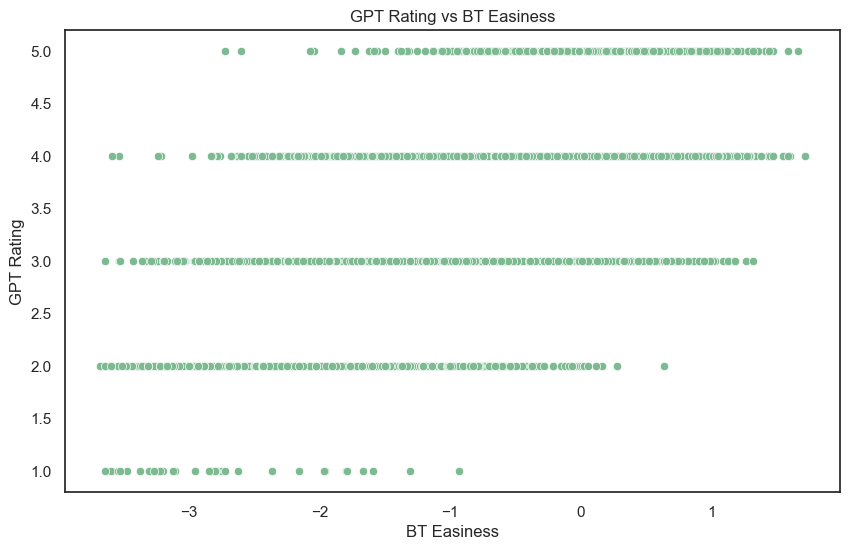

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='BT_easiness', y='readability_score_GPT4o_prompt1', data=df_merged)
plt.title('GPT Rating vs BT Easiness')
plt.xlabel('BT Easiness')
plt.ylabel('GPT Rating')
plt.show()

Let's experiment with the prompt a bit...one interesting factor we can vary is what happens when the model is asked to make a wider range of judgments. Let's double the prediction space, going from 1-5 to 1-10.

In [24]:
system_prompt = "You are an expert in linguistics and writing analysis, specializing in assessing the readability and comprehensibility of texts for various audiences."
instructions = "Holistically evaluate the readability of the following text. In your evaluation, consider factors such as vocabulary complexity, sentence structure and length, overall clarity and coherence, conceptual difficulty, text organization and flow, and whether the assumed background knowledge is appropriate for the audience. Respond with a readability score in the format '<Text>: [score]'. The score ranges from 1 to 10, where 1 = Extremely difficult to read, 2 = Very difficult to read, 3 = Difficult to read, 4 = Somewhat difficult to read, 5 = Moderately difficult to read, 6 = Moderately readable, 7 = Fairly easy to read, 8 = Easy to read, 9 = Very easy to read, 10 = Extremely easy to read. Only provide the readability score."

In [25]:
results = []
for batch in tqdm(batches, total=len(batches)):
    batch_results = process_batch(batch, system_prompt, instructions, MODEL)

    # If the batch result is incomplete, retry failed excerpts
    if len(batch_results) != len(batch) or any(result is None for result in batch_results):
        print(f"Retrying failed excerpts in the batch...")
        for i, result in enumerate(batch_results):
            if result is None:  # Retry only the failed excerpts
                individual_result = process_batch([batch[i]], system_prompt, instructions, MODEL)
                batch_results[i] = individual_result[0]

    results.extend(batch_results)
    time.sleep(1)  # Small delay to avoid rate limiting

100%|██████████| 945/945 [26:35<00:00,  1.69s/it]


In [26]:
pearson_corr, pearson_p = stats.pearsonr(np.array(results), df['BT_easiness'])
spearman_corr, spearman_p = stats.spearmanr(np.array(results), df['BT_easiness'])
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

Pearson correlation: 0.621 (p-value: 0.000)
Spearman correlation: 0.622 (p-value: 0.000)


Not bad, we got a boost of 3% additional variance explained in human readability judgments! Looks like the model lost some nuance when constraining its outputs to a smaller prediction space. Let's again save and plot the output.

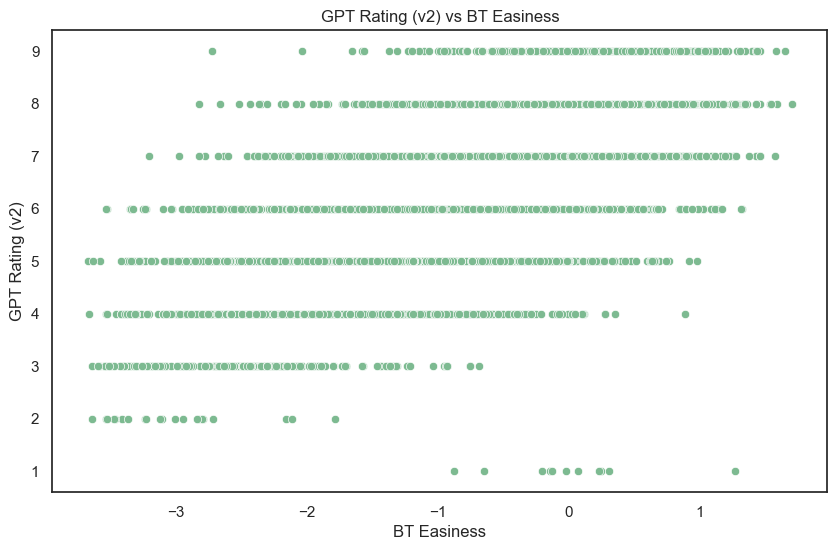

In [28]:
results_df = pd.DataFrame(np.array(results), columns=['readability_score_GPT4o_prompt2'])
df_merged = pd.merge(results_df, df_merged, left_index=True, right_index=True)
df_merged.to_csv(r'C:\Users\alext\Downloads\CLEAR-Corpus-main\CLEAR-Corpus-main\readScores.csv', index=False)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='BT_easiness', y='readability_score_GPT4o_prompt2', data=df_merged)
plt.title('GPT Rating (v2) vs BT Easiness')
plt.xlabel('BT Easiness')
plt.ylabel('GPT Rating (v2)')
plt.show()

Let's see if expanding the range further will make a difference. We will have to simplify our prompt a little bit in the process as we can't define each score from 1 to 20. Remember, your system prompt and instructions both contribute to the models attention (context length) and cost (number of tokens processed).

In [22]:
system_prompt = "You are an expert in linguistics and writing analysis, specializing in assessing the readability and comprehensibility of texts for various audiences."
instructions = "Holistically evaluate the readability of the following text. In your evaluation, consider factors such as vocabulary complexity, sentence structure and length, overall clarity and coherence, conceptual difficulty, text organization and flow, and whether the assumed background knowledge is appropriate for the audience. Respond with a readability score in the format '<Text>: [score]'. The score ranges from 1 to 20, where 1 = Extremely difficult to read, 10 = Average readability, and 20 = Extremely easy to read. Only provide the readability score."

In [23]:
results = []
for batch in tqdm(batches, total=len(batches)):
    batch_results = process_batch(batch, system_prompt, instructions, MODEL)

    # If the batch result is incomplete, retry failed excerpts
    if len(batch_results) != len(batch) or any(result is None for result in batch_results):
        print(f"Retrying failed excerpts in the batch...")
        for i, result in enumerate(batch_results):
            if result is None:  # Retry only the failed excerpts
                individual_result = process_batch([batch[i]], system_prompt, instructions, MODEL)
                batch_results[i] = individual_result[0]

    results.extend(batch_results)
    time.sleep(1)  # Small delay to avoid rate limiting

100%|██████████| 945/945 [28:01<00:00,  1.78s/it]


In [24]:
pearson_corr, pearson_p = stats.pearsonr(np.array(results), df['BT_easiness'])
spearman_corr, spearman_p = stats.spearmanr(np.array(results), df['BT_easiness'])
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

Pearson correlation: 0.697 (p-value: 0.000)
Spearman correlation: 0.693 (p-value: 0.000)


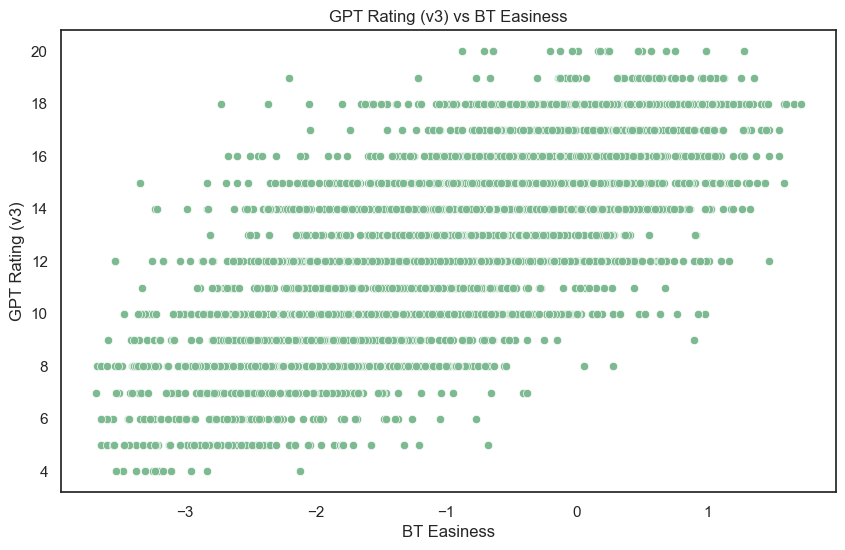

In [25]:
results_df = pd.DataFrame(np.array(results), columns=['readability_score_GPT4o_prompt3_fixed'])
df_merged = pd.merge(results_df, df_merged, left_index=True, right_index=True)
df_merged.to_csv(r'C:\Users\alext\Downloads\CLEAR-Corpus-main\CLEAR-Corpus-main\readScores.csv', index=False)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='BT_easiness', y='readability_score_GPT4o_prompt3_fixed', data=df_merged)
plt.title('GPT Rating (v3) vs BT Easiness')
plt.xlabel('BT Easiness')
plt.ylabel('GPT Rating (v3)')
plt.show()

We got quite the boost! Let's try going to 100 now.

In [30]:
system_prompt = "You are an expert in linguistics and writing analysis, specializing in assessing the readability and comprehensibility of texts for various audiences."
instructions = "Holistically evaluate the readability of the following text. In your evaluation, consider factors such as vocabulary complexity, sentence structure and length, overall clarity and coherence, conceptual difficulty, text organization and flow, and whether the assumed background knowledge is appropriate for the audience. Respond with a readability score in the format '<Text>: [score]'. The score ranges from 1 to 100, where 1 = Extremely difficult to read, 50 = Average readability, and 100 = Extremely easy to read. Only provide the readability score."

In [31]:
results = []
for batch in tqdm(batches, total=len(batches)):
    batch_results = process_batch(batch, system_prompt, instructions, MODEL)

    # If the batch result is incomplete, retry failed excerpts
    if len(batch_results) != len(batch) or any(result is None for result in batch_results):
        print(f"Retrying failed excerpts in the batch...")
        for i, result in enumerate(batch_results):
            if result is None:  # Retry only the failed excerpts
                individual_result = process_batch([batch[i]], system_prompt, instructions, MODEL)
                batch_results[i] = individual_result[0]

    results.extend(batch_results)
    time.sleep(1)  # Small delay to avoid rate limiting

100%|██████████| 945/945 [27:30<00:00,  1.75s/it]


In [32]:
pearson_corr, pearson_p = stats.pearsonr(np.array(results), df['BT_easiness'])
spearman_corr, spearman_p = stats.spearmanr(np.array(results), df['BT_easiness'])
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

Pearson correlation: 0.685 (p-value: 0.000)
Spearman correlation: 0.683 (p-value: 0.000)


Interestingly, expanding the prediction 'space' made the model a little worse...let's try expanding out to just 50--just to be safe.

In [33]:
system_prompt = "You are an expert in linguistics and writing analysis, specializing in assessing the readability and comprehensibility of texts for various audiences."
instructions = "Holistically evaluate the readability of the following text. In your evaluation, consider factors such as vocabulary complexity, sentence structure and length, overall clarity and coherence, conceptual difficulty, text organization and flow, and whether the assumed background knowledge is appropriate for the audience. Respond with a readability score in the format '<Text>: [score]'. The score ranges from 1 to 50, where 1 = Extremely difficult to read, 25 = Average readability, and 50 = Extremely easy to read. Only provide the readability score."

In [34]:
results = []
for batch in tqdm(batches, total=len(batches)):
    batch_results = process_batch(batch, system_prompt, instructions, MODEL)

    # If the batch result is incomplete, retry failed excerpts
    if len(batch_results) != len(batch) or any(result is None for result in batch_results):
        print(f"Retrying failed excerpts in the batch...")
        for i, result in enumerate(batch_results):
            if result is None:  # Retry only the failed excerpts
                individual_result = process_batch([batch[i]], system_prompt, instructions, MODEL)
                batch_results[i] = individual_result[0]

    results.extend(batch_results)
    time.sleep(1)  # Small delay to avoid rate limiting

100%|██████████| 945/945 [28:34<00:00,  1.81s/it]


In [35]:
pearson_corr, pearson_p = stats.pearsonr(np.array(results), df['BT_easiness'])
spearman_corr, spearman_p = stats.spearmanr(np.array(results), df['BT_easiness'])
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

Pearson correlation: 0.656 (p-value: 0.000)
Spearman correlation: 0.656 (p-value: 0.000)


This did not do so well so we will not save it. The best-performing model ranked readability out of 20 and the second best rated readability out of 100. Finally, let's try 1000 as well.

In [40]:
system_prompt = "You are an expert in linguistics and writing analysis, specializing in assessing the readability and comprehensibility of texts for various audiences."
instructions = "Holistically evaluate the readability of the following text. In your evaluation, consider factors such as vocabulary complexity, sentence structure and length, overall clarity and coherence, conceptual difficulty, text organization and flow, and whether the assumed background knowledge is appropriate for the audience. Respond with a readability score in the format '<Text>: [score]'. The score ranges from 1 to 1000, where 1 = Extremely difficult to read, 500 = Average readability, and 1000 = Extremely easy to read. Only provide the readability score."
results = []
for batch in tqdm(batches, total=len(batches)):
    batch_results = process_batch(batch, system_prompt, instructions, MODEL)

    # If the batch result is incomplete, retry failed excerpts
    if len(batch_results) != len(batch) or any(result is None for result in batch_results):
        print(f"Retrying failed excerpts in the batch...")
        for i, result in enumerate(batch_results):
            if result is None:  # Retry only the failed excerpts
                individual_result = process_batch([batch[i]], system_prompt, instructions, MODEL)
                batch_results[i] = individual_result[0]

    results.extend(batch_results)
    time.sleep(1)  # Small delay to avoid rate limiting

100%|██████████| 945/945 [27:11<00:00,  1.73s/it]


In [41]:
pearson_corr, pearson_p = stats.pearsonr(np.array(results), df['BT_easiness'])
spearman_corr, spearman_p = stats.spearmanr(np.array(results), df['BT_easiness'])
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

Pearson correlation: 0.672 (p-value: 0.000)
Spearman correlation: 0.666 (p-value: 0.000)


You'll want to check and edit the code for concatenating the results and saving them to csv as around here I came back after restarting the notebook...

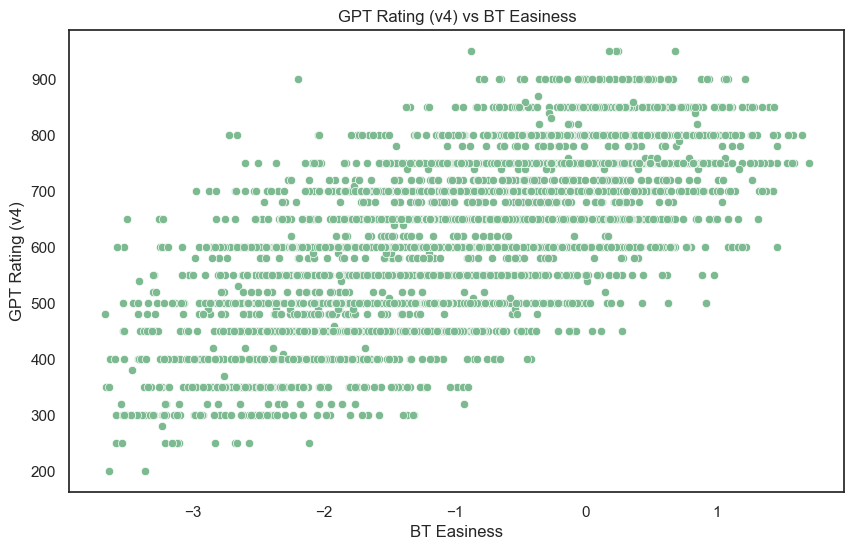

In [43]:
results_df = pd.DataFrame(np.array(results), columns=['readability_score_GPT4o_prompt_1000_v2'])
df_merged = pd.merge(results_df, df_merged, left_index=True, right_index=True)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='BT_easiness', y='readability_score_GPT4o_prompt_1000_v2', data=df_merged)
plt.title('GPT Rating (v4) vs BT Easiness')
plt.xlabel('BT Easiness')
plt.ylabel('GPT Rating (v4)')
plt.show()

A larger range seems to have one benefit: the model tends not to make judgments to the decimal point (I imagine most text data that it was trained on contained whole numbers) and extending the whole integer range means it makes more variable judgments.

In [44]:
system_prompt = "You are an expert in linguistics and writing analysis, specializing in assessing the readability and comprehensibility of texts for various audiences."
instructions = "Holistically evaluate the readability of the following text. In your evaluation, consider factors such as sentence structure, vocabulary complexity, and overall clarity. Respond with a readability score in the format '<Text>: [score]'. The score ranges from from 1 (extremely challenging to understand) to 100 (very easy to read and understand). Only provide the readability score."
results = []
for batch in tqdm(batches, total=len(batches)):
    batch_results = process_batch(batch, system_prompt, instructions, MODEL)

    # If the batch result is incomplete, retry failed excerpts
    if len(batch_results) != len(batch) or any(result is None for result in batch_results):
        print(f"Retrying failed excerpts in the batch...")
        for i, result in enumerate(batch_results):
            if result is None:  # Retry only the failed excerpts
                individual_result = process_batch([batch[i]], system_prompt, instructions, MODEL)
                batch_results[i] = individual_result[0]

    results.extend(batch_results)
    time.sleep(1)  # Small delay to avoid rate limiting

100%|██████████| 945/945 [28:27<00:00,  1.81s/it]


Pearson correlation: 0.661 (p-value: 0.000)
Spearman correlation: 0.664 (p-value: 0.000)


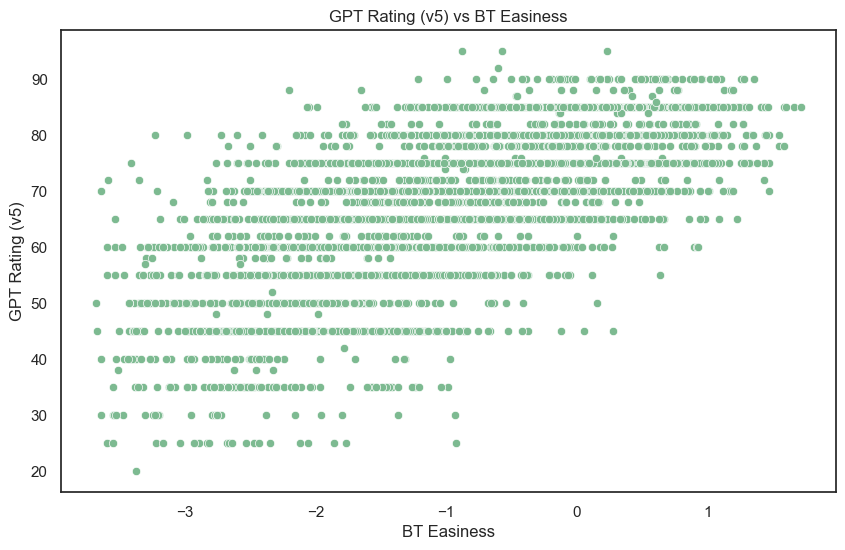

In [45]:
pearson_corr, pearson_p = stats.pearsonr(np.array(results), df['BT_easiness'])
spearman_corr, spearman_p = stats.spearmanr(np.array(results), df['BT_easiness'])
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")
results_df = pd.DataFrame(np.array(results), columns=['readability_score_GPT4o_prompt_100_orig_v1'])
df_merged = pd.merge(results_df, df_merged, left_index=True, right_index=True)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='BT_easiness', y='readability_score_GPT4o_prompt_100_orig_v1', data=df_merged)
plt.title('GPT Rating (v5) vs BT Easiness')
plt.xlabel('BT Easiness')
plt.ylabel('GPT Rating (v5)')
plt.show()

Next, let's see if simplifying the prompt will have any effect. We'll also make our prompt more specific to the type of readability judgments that were made on the CLEAR dataset (i.e., they were made by teachers).

In [9]:
system_prompt = "You are an experienced teacher, skilled at identifying the readability of different texts."
instructions = "Read the text below. Then, indicate the readability of the text, on a scale from 1 (extremely challenging to understand) to 100 (very easy to read and understand). In your assessment, consider factors such as sentence structure, vocabulary complexity, and overall clarity. Respond only with '<Text>: [readability score]'."

results = []
for batch in tqdm(batches, total=len(batches)):
    batch_results = process_batch(batch, system_prompt, instructions, MODEL)

    # If the batch result is incomplete, retry failed excerpts
    if len(batch_results) != len(batch) or any(result is None for result in batch_results):
        print(f"Retrying failed excerpts in the batch...")
        for i, result in enumerate(batch_results):
            if result is None:  # Retry only the failed excerpts
                individual_result = process_batch([batch[i]], system_prompt, instructions, MODEL)
                batch_results[i] = individual_result[0]

    results.extend(batch_results)
    time.sleep(1)  # Small delay to avoid rate limiting

100%|██████████| 945/945 [1:10:06<00:00,  4.45s/it] 


In [11]:
from scipy import stats
pearson_corr, pearson_p = stats.pearsonr(np.array(results), df['BT_easiness'])
spearman_corr, spearman_p = stats.spearmanr(np.array(results), df['BT_easiness'])
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

Pearson correlation: 0.659 (p-value: 0.000)
Spearman correlation: 0.655 (p-value: 0.000)


Huh, remarkably, that made little difference! There's one last thing we should check--what happens when we decrease and increase the batch size? This would have a difference if the model is using some text in the batch to adjust its readability judgments. Note, I am pasting this in from a different notebook I experimented in, so we'll redefine some helper functions to use...

In [19]:
def chunk_list(lst, chunk_size):
    """Split the list into chunks of specified size."""
    return [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]

def format_prompt(instructions, texts):
    formatted_texts = "\n\n".join(f"<Text{i+1}>:{text}</Text{i+1}>" for i, text in enumerate(texts))
    return f"{instructions}\n\n{formatted_texts}\n\nFor each text, provide a readability score from 1 to 100, where 1 is extremely challenging to understand and 100 is very easy to read and understand. Respond with only the scores, one per line, in the format '<Text1>: [score]'."

@backoff.on_exception(backoff.expo, openai.RateLimitError, max_tries=5)
def process_batch(batch, system_prompt, instructions, model="gpt-4o-mini", temperature=0):
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": format_prompt(instructions, batch)}
    ]
    try:
        completion = client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=temperature,
            n=1
        )
        response = completion.choices[0].message.content.strip()
        #print(f"Received response: {response}")
        scores = [int(line.split(':')[1].strip().strip('[]')) for line in response.split('\n') if line.strip()]

        if len(scores) != len(batch):
            print(f"Mismatch detected. Scores received: {len(scores)}, Batch size: {len(batch)}")
            return [None] * len(batch)

        return scores
    except Exception as e:
        print(f"Error processing batch: {e}")
        return [None] * len(batch)

In [11]:
MODEL = "gpt-4o-mini-2024-07-18"
BATCH_SIZE = 1  # Adjust based on API limits and your needs
system_prompt = "You are an experienced teacher, skilled at identifying the readability of different texts."
instructions = "Read the text below. Then, indicate the readability of the text, on a scale from 1 (extremely challenging to understand) to 100 (very easy to read and understand). In your assessment, consider factors such as sentence structure, vocabulary complexity, and overall clarity."

In [ ]:
excerpts = df['Excerpt'].tolist()
batches = chunk_list(excerpts, BATCH_SIZE)

In [ ]:
results = []
for batch in tqdm(batches, total=len(batches)):
    batch_results = process_batch(batch, system_prompt, instructions, MODEL)

    # If the batch result is incomplete, retry failed excerpts individually
    if len(batch_results) != len(batch) or any(result is None for result in batch_results):
        print(f"Retrying failed excerpts in the batch...")
        for i, result in enumerate(batch_results):
            if result is None:
                individual_result = process_batch([batch[i]], system_prompt, instructions, MODEL)
                batch_results[i] = individual_result[0]

    results.extend(batch_results)
    time.sleep(1)  # Small delay to avoid rate limiting

In [ ]:
results_df = pd.DataFrame(np.array(results), columns=['readability_score_GPT4o_prompt_100_orig_v1'])
df_merged = pd.merge(results_df, df, left_index=True, right_index=True)
df_merged.to_csv(r'C:\Users\alext\Downloads\CLEAR-Corpus-main\CLEAR-Corpus-main\bestYet.csv', index=False)

In [8]:
df_merged = pd.read_csv(r'C:\Users\alext\Downloads\CLEAR-Corpus-main\CLEAR-Corpus-main\bestYet.csv')

In [9]:
# Calculate correlations
from scipy import stats
pearson_corr, pearson_p = stats.pearsonr(df_merged['readability_score_GPT4o_prompt_100_orig_v1'], df['BT_easiness'])
spearman_corr, spearman_p = stats.spearmanr(df_merged['readability_score_GPT4o_prompt_100_orig_v1'], df['BT_easiness'])

print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

Pearson correlation: 0.785 (p-value: 0.000)
Spearman correlation: 0.793 (p-value: 0.000)


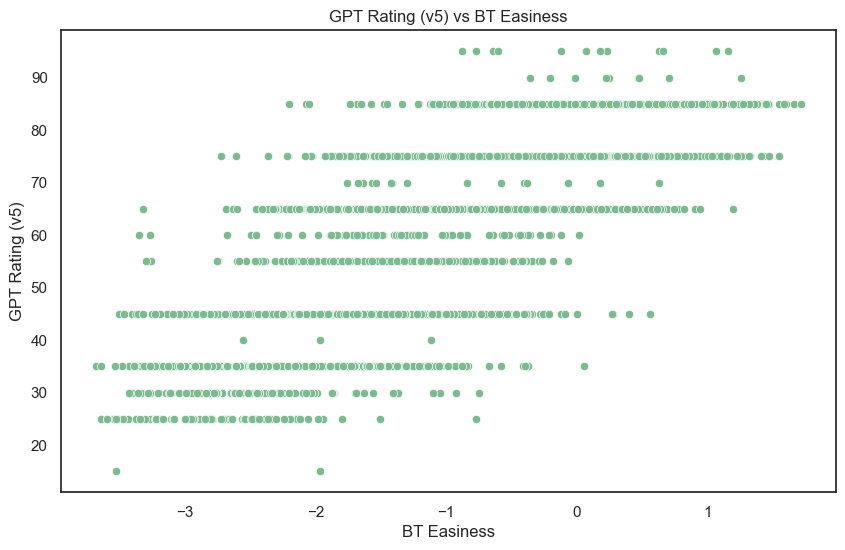

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='BT_easiness', y='readability_score_GPT4o_prompt_100_orig_v1', data=df_merged)
plt.title('GPT Rating (v5) vs BT Easiness')
plt.xlabel('BT Easiness')
plt.ylabel('GPT Rating (v5)')
plt.show()

That worked remarkably well! Looks like decreasing the batch size made a huge difference. It's possible, that giving the model more context (i.e., more excerpts at once) would actually be beneficial...let's test that out as well, now increasing batch size from 5 to 100. Why 100? Well, ~150 would fit in the 128k context window of GPT4o-mini, even if each excerpt was 500 words (some are shorter). We bump that down to 100 just to be safe.

Before we start an as an aside, you may be wondering why this code works better than Sean's code. There are differences (e.g., a retry mechanism, and batch processing in chunks) but ultimately the difference lies in the prompt structure--reiterating the instructions before and after the text and having the structure 'Text: score' seems to make a difference.

In [14]:
BATCH_SIZE = 100  # Adjust based on API limits and your needs
excerpts = df['Excerpt'].tolist()
batches = chunk_list(excerpts, BATCH_SIZE)
system_prompt = "You are an experienced teacher, skilled at identifying the readability of different texts."
instructions = "Read the text below. Then, indicate the readability of the text, on a scale from 1 (extremely challenging to understand) to 100 (very easy to read and understand). In your assessment, consider factors such as sentence structure, vocabulary complexity, and overall clarity."

In [17]:
results = []
for batch in tqdm(batches, total=len(batches)):
    batch_results = process_batch(batch, system_prompt, instructions, MODEL)

    # If the batch result is incomplete, retry failed excerpts individually
    if len(batch_results) != len(batch) or any(result is None for result in batch_results):
        print(f"Retrying failed excerpts in the batch...")
        for i, result in enumerate(batch_results):
            if result is None:
                individual_result = process_batch([batch[i]], system_prompt, instructions, MODEL)
                batch_results[i] = individual_result[0]

    results.extend(batch_results)
    time.sleep(1)  # Small delay to avoid rate limiting

  0%|          | 0/48 [00:00<?, ?it/s]

Received response: <Text1>: 65  
<Text2>: 75  
<Text3>: 70  
<Text4>: 60  
<Text5>: 55  
<Text6>: 85  
<Text7>: 65  
<Text8>: 70  
<Text9>: 60  
<Text10>: 75  
<Text11>: 70  
<Text12>: 50  
<Text13>: 55  
<Text14>: 60  
<Text15>: 65  
<Text16>: 80  
<Text17>: 75  
<Text18>: 70  
<Text19>: 75  
<Text20>: 65  
<Text21>: 70  
<Text22>: 75  
<Text23>: 70  
<Text24>: 65  
<Text25>: 70  
<Text26>: 60  
<Text27>: 65  
<Text28>: 70  
<Text29>: 60  
<Text30>: 70  
<Text31>: 65  
<Text32>: 70  
<Text33>: 75  
<Text34>: 70  
<Text35>: 75  
<Text36>: 60  
<Text37>: 65  
<Text38>: 80  
<Text39>: 70  
<Text40>: 65  
<Text41>: 70  
<Text42>: 55  
<Text43>: 70  
<Text44>: 75  
<Text45>: 80  
<Text46>: 65  
<Text47>: 60  
<Text48>: 70  
<Text49>: 65  
<Text50>: 75  
<Text51>: 80  
<Text52>: 75  
<Text53>: 70  
<Text54>: 60  
<Text55>: 70  
<Text56>: 75  
<Text57>: 70  
<Text58>: 60  
<Text59>: 65  
<Text60>: 70  
<Text61>: 60  
<Text62>: 65  
<Text63>: 70  
<Text64>: 65  
<Text65>: 60  
<Text66>: 65  


  2%|▏         | 1/48 [00:06<05:22,  6.87s/it]

Received response: <Text1>: 65  
<Text2>: 60  
<Text3>: 70  
<Text4>: 75  
<Text5>: 80  
<Text6>: 65  
<Text7>: 75  
<Text8>: 70  
<Text9>: 75  
<Text10>: 65  
<Text11>: 80  
<Text12>: 75  
<Text13>: 70  
<Text14>: 75  
<Text15>: 75  
<Text16>: 70  
<Text17>: 75  
<Text18>: 60  
<Text19>: 70  
<Text20>: 65  
<Text21>: 60  
<Text22>: 70  
<Text23>: 75  
<Text24>: 65  
<Text25>: 70  
<Text26>: 70  
<Text27>: 65  
<Text28>: 60  
<Text29>: 70  
<Text30>: 65  
<Text31>: 70  
<Text32>: 65  
<Text33>: 65  
<Text34>: 70  
<Text35>: 60  
<Text36>: 70  
<Text37>: 70  
<Text38>: 75  
<Text39>: 70  
<Text40>: 70  
<Text41>: 65  
<Text42>: 70  
<Text43>: 65  
<Text44>: 70  
<Text45>: 75  
<Text46>: 70  
<Text47>: 70  
<Text48>: 75  
<Text49>: 65  
<Text50>: 75  
<Text51>: 70  
<Text52>: 75  
<Text53>: 70  
<Text54>: 70  
<Text55>: 70  
<Text56>: 75  
<Text57>: 70  
<Text58>: 70  
<Text59>: 70  
<Text60>: 70  
<Text61>: 65  
<Text62>: 70  
<Text63>: 70  
<Text64>: 65  
<Text65>: 75  
<Text66>: 70  


  4%|▍         | 2/48 [00:12<04:47,  6.26s/it]

Received response: <Text1>: 65  
<Text2>: 70  
<Text3>: 75  
<Text4>: 72  
<Text5>: 68  
<Text6>: 74  
<Text7>: 73  
<Text8>: 66  
<Text9>: 78  
<Text10>: 69  
<Text11>: 67  
<Text12>: 71  
<Text13>: 74  
<Text14>: 76  
<Text15>: 73  
<Text16>: 68  
<Text17>: 65  
<Text18>: 62  
<Text19>: 66  
<Text20>: 70  
<Text21>: 64  
<Text22>: 61  
<Text23>: 68  
<Text24>: 72  
<Text25>: 75  
<Text26>: 66  
<Text27>: 70  
<Text28>: 75  
<Text29>: 72  
<Text30>: 70  
<Text31>: 74  
<Text32>: 73  
<Text33>: 75  
<Text34>: 68  
<Text35>: 72  
<Text36>: 70  
<Text37>: 74  
<Text38>: 68  
<Text39>: 76  
<Text40>: 72  
<Text41>: 70  
<Text42>: 65  
<Text43>: 66  
<Text44>: 75  
<Text45>: 78  
<Text46>: 74  
<Text47>: 76  
<Text48>: 75  
<Text49>: 72  
<Text50>: 70  
<Text51>: 68  
<Text52>: 75  
<Text53>: 72  
<Text54>: 76  
<Text55>: 68  
<Text56>: 74  
<Text57>: 70  
<Text58>: 75  
<Text59>: 66  
<Text60>: 68  
<Text61>: 72  
<Text62>: 75  
<Text63>: 78  
<Text64>: 74  
<Text65>: 62  
<Text66>: 70  


  6%|▋         | 3/48 [00:22<05:49,  7.77s/it]

Received response: <Text1>: 75  
<Text2>: 70  
<Text3>: 80  
<Text4>: 65  
<Text5>: 75  
<Text6>: 60  
<Text7>: 70  
<Text8>: 65  
<Text9>: 55  
<Text10>: 70  
<Text11>: 75  
<Text12>: 70  
<Text13>: 65  
<Text14>: 60  
<Text15>: 65  
<Text16>: 60  
<Text17>: 65  
<Text18>: 70  
<Text19>: 60  
<Text20>: 65  
<Text21>: 70  
<Text22>: 75  
<Text23>: 70  
<Text24>: 65  
<Text25>: 70  
<Text26>: 65  
<Text27>: 70  
<Text28>: 65  
<Text29>: 70  
<Text30>: 65  
<Text31>: 70  
<Text32>: 75  
<Text33>: 65  
<Text34>: 60  
<Text35>: 65  
<Text36>: 60  
<Text37>: 65  
<Text38>: 75  
<Text39>: 70  
<Text40>: 70  
<Text41>: 75  
<Text42>: 70  
<Text43>: 65  
<Text44>: 70  
<Text45>: 75  
<Text46>: 70  
<Text47>: 80  
<Text48>: 85  
<Text49>: 75  
<Text50>: 70  
<Text51>: 65  
<Text52>: 70  
<Text53>: 65  
<Text54>: 70  
<Text55>: 65  
<Text56>: 60  
<Text57>: 75  
<Text58>: 70  
<Text59>: 70  
<Text60>: 60  
<Text61>: 70  
<Text62>: 65  
<Text63>: 70  
<Text64>: 65  
<Text65>: 75  
<Text66>: 70  


  8%|▊         | 4/48 [00:33<06:49,  9.32s/it]

Received response: <Text1>: 55  
<Text2>: 70  
<Text3>: 65  
<Text4>: 60  
<Text5>: 85  
<Text6>: 75  
<Text7>: 70  
<Text8>: 60  
<Text9>: 75  
<Text10>: 70  
<Text11>: 65  
<Text12>: 70  
<Text13>: 75  
<Text14>: 65  
<Text15>: 70  
<Text16>: 65  
<Text17>: 60  
<Text18>: 55  
<Text19>: 70  
<Text20>: 90  
<Text21>: 75  
<Text22>: 60  
<Text23>: 80  
<Text24>: 65  
<Text25>: 70  
<Text26>: 65  
<Text27>: 60  
<Text28>: 65  
<Text29>: 60  
<Text30>: 80  
<Text31>: 75  
<Text32>: 70  
<Text33>: 70  
<Text34>: 75  
<Text35>: 70  
<Text36>: 65  
<Text37>: 60  
<Text38>: 65  
<Text39>: 60  
<Text40>: 70  
<Text41>: 65  
<Text42>: 60  
<Text43>: 70  
<Text44>: 65  
<Text45>: 70  
<Text46>: 60  
<Text47>: 70  
<Text48>: 55  
<Text49>: 70  
<Text50>: 75  
<Text51>: 60  
<Text52>: 65  
<Text53>: 60  
<Text54>: 65  
<Text55>: 70  
<Text56>: 65  
<Text57>: 70  
<Text58>: 60  
<Text59>: 65  
<Text60>: 70  
<Text61>: 65  
<Text62>: 60  
<Text63>: 65  
<Text64>: 60  
<Text65>: 55  
<Text66>: 65  


 10%|█         | 5/48 [00:44<07:04,  9.88s/it]

Received response: <Text1>: 65  
<Text2>: 75  
<Text3>: 70  
<Text4>: 80  
<Text5>: 60  
<Text6>: 70  
<Text7>: 75  
<Text8>: 65  
<Text9>: 70  
<Text10>: 60  
<Text11>: 65  
<Text12>: 55  
<Text13>: 60  
<Text14>: 70  
<Text15>: 70  
<Text16>: 50  
<Text17>: 60  
<Text18>: 75  
<Text19>: 65  
<Text20>: 70  
<Text21>: 60  
<Text22>: 70  
<Text23>: 75  
<Text24>: 65  
<Text25>: 70  
<Text26>: 60  
<Text27>: 65  
<Text28>: 55  
<Text29>: 65  
<Text30>: 60  
<Text31>: 55  
<Text32>: 70  
<Text33>: 75  
<Text34>: 50  
<Text35>: 65  
<Text36>: 80  
<Text37>: 70  
<Text38>: 65  
<Text39>: 60  
<Text40>: 65  
<Text41>: 55  
<Text42>: 60  
<Text43>: 55  
<Text44>: 60  
<Text45>: 65  
<Text46>: 55  
<Text47>: 60  
<Text48>: 65  
<Text49>: 60  
<Text50>: 65  
<Text51>: 70  
<Text52>: 60  
<Text53>: 70  
<Text54>: 65  
<Text55>: 70  
<Text56>: 75  
<Text57>: 60  
<Text58>: 65  
<Text59>: 70  
<Text60>: 65  
<Text61>: 70  
<Text62>: 70  
<Text63>: 75  
<Text64>: 60  
<Text65>: 70  
<Text66>: 65  


 12%|█▎        | 6/48 [00:56<07:16, 10.40s/it]

Received response: <Text1>: 45  
<Text2>: 60  
<Text3>: 55  
<Text4>: 30  
<Text5>: 75  
<Text6>: 65  
<Text7>: 70  
<Text8>: 65  
<Text9>: 50  
<Text10>: 60  
<Text11>: 70  
<Text12>: 65  
<Text13>: 75  
<Text14>: 85  
<Text15>: 55  
<Text16>: 60  
<Text17>: 50  
<Text18>: 70  
<Text19>: 60  
<Text20>: 70  
<Text21>: 55  
<Text22>: 50  
<Text23>: 65  
<Text24>: 70  
<Text25>: 65  
<Text26>: 60  
<Text27>: 55  
<Text28>: 50  
<Text29>: 55  
<Text30>: 65  
<Text31>: 50  
<Text32>: 45  
<Text33>: 60  
<Text34>: 55  
<Text35>: 75  
<Text36>: 60  
<Text37>: 40  
<Text38>: 55  
<Text39>: 50  
<Text40>: 70  
<Text41>: 55  
<Text42>: 60  
<Text43>: 65  
<Text44>: 50  
<Text45>: 60  
<Text46>: 55  
<Text47>: 65  
<Text48>: 50  
<Text49>: 55  
<Text50>: 60  
<Text51>: 50  
<Text52>: 70  
<Text53>: 60  
<Text54>: 65  
<Text55>: 70  
<Text56>: 50  
<Text57>: 45  
<Text58>: 60  
<Text59>: 50  
<Text60>: 55  
<Text61>: 50  
<Text62>: 65  
<Text63>: 70  
<Text64>: 60  
<Text65>: 55  
<Text66>: 50  


 15%|█▍        | 7/48 [01:05<06:54, 10.11s/it]

Received response: <Text1>: 60  
<Text2>: 70  
<Text3>: 65  
<Text4>: 75  
<Text5>: 80  
<Text6>: 75  
<Text7>: 68  
<Text8>: 72  
<Text9>: 62  
<Text10>: 64  
<Text11>: 70  
<Text12>: 66  
<Text13>: 75  
<Text14>: 70  
<Text15>: 68  
<Text16>: 85  
<Text17>: 55  
<Text18>: 50  
<Text19>: 90  
<Text20>: 75  
<Text21>: 70  
<Text22>: 80  
<Text23>: 60  
<Text24>: 65  
<Text25>: 75  
<Text26>: 70  
<Text27>: 68  
<Text28>: 72  
<Text29>: 70  
<Text30>: 65  
<Text31>: 60  
<Text32>: 70  
<Text33>: 55  
<Text34>: 65  
<Text35>: 60  
<Text36>: 55  
<Text37>: 60  
<Text38>: 70  
<Text39>: 65  
<Text40>: 60  
<Text41>: 55  
<Text42>: 70  
<Text43>: 80  
<Text44>: 65  
<Text45>: 85  
<Text46>: 70  
<Text47>: 65  
<Text48>: 85  
<Text49>: 70  
<Text50>: 80  
<Text51>: 65  
<Text52>: 70  
<Text53>: 65  
<Text54>: 60  
<Text55>: 65  
<Text56>: 60  
<Text57>: 65  
<Text58>: 70  
<Text59>: 60  
<Text60>: 65  
<Text61>: 60  
<Text62>: 55  
<Text63>: 60  
<Text64>: 65  
<Text65>: 70  
<Text66>: 40  


 17%|█▋        | 8/48 [01:17<07:03, 10.59s/it]

Received response: <Text1>: 85  
<Text2>: 80  
<Text3>: 90  
<Text4>: 70  
<Text5>: 75  
<Text6>: 78  
<Text7>: 65  
<Text8>: 50  
<Text9>: 85  
<Text10>: 80  
<Text11>: 75  
<Text12>: 60  
<Text13>: 55  
<Text14>: 70  
<Text15>: 65  
<Text16>: 75  
<Text17>: 60  
<Text18>: 65  
<Text19>: 70  
<Text20>: 55  
<Text21>: 70  
<Text22>: 60  
<Text23>: 55  
<Text24>: 50  
<Text25>: 70  
<Text26>: 60  
<Text27>: 65  
<Text28>: 55  
<Text29>: 65  
<Text30>: 85  
<Text31>: 60  
<Text32>: 65  
<Text33>: 60  
<Text34>: 75  
<Text35>: 70  
<Text36>: 65  
<Text37>: 70  
<Text38>: 65  
<Text39>: 70  
<Text40>: 75  
<Text41>: 60  
<Text42>: 75  
<Text43>: 70  
<Text44>: 80  
<Text45>: 70  
<Text46>: 60  
<Text47>: 65  
<Text48>: 75  
<Text49>: 70  
<Text50>: 90  
<Text51>: 65  
<Text52>: 55  
<Text53>: 60  
<Text54>: 75  
<Text55>: 70  
<Text56>: 65  
<Text57>: 70  
<Text58>: 60  
<Text59>: 65  
<Text60>: 55  
<Text61>: 70  
<Text62>: 55  
<Text63>: 65  
<Text64>: 60  
<Text65>: 65  
<Text66>: 60  


 19%|█▉        | 9/48 [01:32<07:45, 11.94s/it]

Received response: <Text1>: 60  
<Text2>: 75  
<Text3>: 65  
<Text4>: 70  
<Text5>: 80  
<Text6>: 85  
<Text7>: 70  
<Text8>: 65  
<Text9>: 75  
<Text10>: 70  
<Text11>: 65  
<Text12>: 75  
<Text13>: 80  
<Text14>: 70  
<Text15>: 60  
<Text16>: 55  
<Text17>: 65  
<Text18>: 70  
<Text19>: 75  
<Text20>: 70  
<Text21>: 75  
<Text22>: 60  
<Text23>: 65  
<Text24>: 70  
<Text25>: 75  
<Text26>: 70  
<Text27>: 65  
<Text28>: 70  
<Text29>: 75  
<Text30>: 80  
<Text31>: 65  
<Text32>: 70  
<Text33>: 65  
<Text34>: 60  
<Text35>: 65  
<Text36>: 70  
<Text37>: 65  
<Text38>: 85  
<Text39>: 80  
<Text40>: 70  
<Text41>: 65  
<Text42>: 70  
<Text43>: 65  
<Text44>: 70  
<Text45>: 60  
<Text46>: 75  
<Text47>: 70  
<Text48>: 65  
<Text49>: 60  
<Text50>: 65  
<Text51>: 70  
<Text52>: 60  
<Text53>: 65  
<Text54>: 60  
<Text55>: 65  
<Text56>: 70  
<Text57>: 70  
<Text58>: 65  
<Text59>: 65  
<Text60>: 60  
<Text61>: 80  
<Text62>: 65  
<Text63>: 70  
<Text64>: 60  
<Text65>: 65  
<Text66>: 60  


 21%|██        | 10/48 [01:38<06:28, 10.22s/it]

Received response: <Text1>: 65  
<Text2>: 90  
<Text3>: 70  
<Text4>: 75  
<Text5>: 60  
<Text6>: 80  
<Text7>: 70  
<Text8>: 85  
<Text9>: 50  
<Text10>: 75  
<Text11>: 80  
<Text12>: 70  
<Text13>: 75  
<Text14>: 80  
<Text15>: 65  
<Text16>: 70  
<Text17>: 65  
<Text18>: 75  
<Text19>: 70  
<Text20>: 75  
<Text21>: 60  
<Text22>: 70  
<Text23>: 75  
<Text24>: 65  
<Text25>: 70  
<Text26>: 75  
<Text27>: 70  
<Text28>: 75  
<Text29>: 85  
<Text30>: 70  
<Text31>: 65  
<Text32>: 70  
<Text33>: 65  
<Text34>: 70  
<Text35>: 80  
<Text36>: 70  
<Text37>: 75  
<Text38>: 65  
<Text39>: 70  
<Text40>: 75  
<Text41>: 80  
<Text42>: 75  
<Text43>: 85  
<Text44>: 60  
<Text45>: 70  
<Text46>: 70  
<Text47>: 75  
<Text48>: 60  
<Text49>: 70  
<Text50>: 65  
<Text51>: 70  
<Text52>: 75  
<Text53>: 75  
<Text54>: 70  
<Text55>: 70  
<Text56>: 70  
<Text57>: 65  
<Text58>: 70  
<Text59>: 75  
<Text60>: 80  
<Text61>: 70  
<Text62>: 70  
<Text63>: 65  
<Text64>: 85  
<Text65>: 90  
<Text66>: 85  


 23%|██▎       | 11/48 [01:48<06:19, 10.26s/it]

Received response: <Text1>: 65  
<Text2>: 70  
<Text3>: 60  
<Text4>: 75  
<Text5>: 80  
<Text6>: 75  
<Text7>: 70  
<Text8>: 65  
<Text9>: 85  
<Text10>: 75  
<Text11>: 60  
<Text12>: 70  
<Text13>: 65  
<Text14>: 70  
<Text15>: 75  
<Text16>: 70  
<Text17>: 75  
<Text18>: 65  
<Text19>: 80  
<Text20>: 70  
<Text21>: 65  
<Text22>: 75  
<Text23>: 70  
<Text24>: 75  
<Text25>: 70  
<Text26>: 65  
<Text27>: 70  
<Text28>: 60  
<Text29>: 65  
<Text30>: 60  
<Text31>: 65  
<Text32>: 60  
<Text33>: 65  
<Text34>: 75  
<Text35>: 70  
<Text36>: 75  
<Text37>: 65  
<Text38>: 60  
<Text39>: 65  
<Text40>: 70  
<Text41>: 60  
<Text42>: 80  
<Text43>: 75  
<Text44>: 75  
<Text45>: 70  
<Text46>: 60  
<Text47>: 70  
<Text48>: 80  
<Text49>: 75  
<Text50>: 65  
<Text51>: 60  
<Text52>: 65  
<Text53>: 75  
<Text54>: 60  
<Text55>: 65  
<Text56>: 75  
<Text57>: 70  
<Text58>: 65  
<Text59>: 70  
<Text60>: 60  
<Text61>: 65  
<Text62>: 70  
<Text63>: 65  
<Text64>: 70  
<Text65>: 70  
<Text66>: 65  


 25%|██▌       | 12/48 [01:59<06:06, 10.19s/it]

Received response: <Text1>: 70  
<Text2>: 65  
<Text3>: 85  
<Text4>: 75  
<Text5>: 70  
<Text6>: 60  
<Text7>: 75  
<Text8>: 70  
<Text9>: 80  
<Text10>: 65  
<Text11>: 70  
<Text12>: 75  
<Text13>: 65  
<Text14>: 80  
<Text15>: 60  
<Text16>: 70  
<Text17>: 65  
<Text18>: 75  
<Text19>: 70  
<Text20>: 60  
<Text21>: 70  
<Text22>: 65  
<Text23>: 70  
<Text24>: 75  
<Text25>: 60  
<Text26>: 80  
<Text27>: 75  
<Text28>: 65  
<Text29>: 70  
<Text30>: 65  
<Text31>: 80  
<Text32>: 70  
<Text33>: 65  
<Text34>: 60  
<Text35>: 70  
<Text36>: 75  
<Text37>: 70  
<Text38>: 80  
<Text39>: 75  
<Text40>: 70  
<Text41>: 65  
<Text42>: 70  
<Text43>: 65  
<Text44>: 70  
<Text45>: 60  
<Text46>: 70  
<Text47>: 65  
<Text48>: 70  
<Text49>: 65  
<Text50>: 60  
<Text51>: 55  
<Text52>: 60  
<Text53>: 65  
<Text54>: 70  
<Text55>: 65  
<Text56>: 60  
<Text57>: 70  
<Text58>: 65  
<Text59>: 75  
<Text60>: 70  
<Text61>: 75  
<Text62>: 70  
<Text63>: 65  
<Text64>: 60  
<Text65>: 60  
<Text66>: 65  


 27%|██▋       | 13/48 [02:07<05:41,  9.75s/it]

Received response: <Text1>: 60  
<Text2>: 85  
<Text3>: 70  
<Text4>: 80  
<Text5>: 90  
<Text6>: 75  
<Text7>: 65  
<Text8>: 70  
<Text9>: 75  
<Text10>: 80  
<Text11>: 85  
<Text12>: 70  
<Text13>: 75  
<Text14>: 70  
<Text15>: 65  
<Text16>: 60  
<Text17>: 70  
<Text18>: 65  
<Text19>: 60  
<Text20>: 65  
<Text21>: 75  
<Text22>: 70  
<Text23>: 65  
<Text24>: 60  
<Text25>: 75  
<Text26>: 90  
<Text27>: 85  
<Text28>: 80  
<Text29>: 80  
<Text30>: 80  
<Text31>: 75  
<Text32>: 80  
<Text33>: 70  
<Text34>: 65  
<Text35>: 70  
<Text36>: 65  
<Text37>: 75  
<Text38>: 70  
<Text39>: 65  
<Text40>: 60  
<Text41>: 70  
<Text42>: 65  
<Text43>: 70  
<Text44>: 65  
<Text45>: 70  
<Text46>: 65  
<Text47>: 60  
<Text48>: 70  
<Text49>: 75  
<Text50>: 70  
<Text51>: 70  
<Text52>: 65  
<Text53>: 70  
<Text54>: 65  
<Text55>: 70  
<Text56>: 65  
<Text57>: 70  
<Text58>: 65  
<Text59>: 70  
<Text60>: 65  
<Text61>: 65  
<Text62>: 70  
<Text63>: 65  
<Text64>: 70  
<Text65>: 80  
<Text66>: 80  


 29%|██▉       | 14/48 [02:17<05:35,  9.88s/it]

Received response: <Text1>: 75  
<Text2>: 70  
<Text3>: 80  
<Text4>: 75  
<Text5>: 85  
<Text6>: 80  
<Text7>: 75  
<Text8>: 60  
<Text9>: 70  
<Text10>: 75  
<Text11>: 70  
<Text12>: 65  
<Text13>: 70  
<Text14>: 75  
<Text15>: 70  
<Text16>: 75  
<Text17>: 65  
<Text18>: 70  
<Text19>: 65  
<Text20>: 70  
<Text21>: 70  
<Text22>: 75  
<Text23>: 75  
<Text24>: 70  
<Text25>: 75  
<Text26>: 80  
<Text27>: 75  
<Text28>: 70  
<Text29>: 70  
<Text30>: 75  
<Text31>: 75  
<Text32>: 70  
<Text33>: 65  
<Text34>: 80  
<Text35>: 75  
<Text36>: 75  
<Text37>: 85  
<Text38>: 75  
<Text39>: 65  
<Text40>: 80  
<Text41>: 75  
<Text42>: 70  
<Text43>: 80  
<Text44>: 75  
<Text45>: 70  
<Text46>: 65  
<Text47>: 60  
<Text48>: 70  
<Text49>: 65  
<Text50>: 75  
<Text51>: 70  
<Text52>: 70  
<Text53>: 65  
<Text54>: 60  
<Text55>: 75  
<Text56>: 80  
<Text57>: 80  
<Text58>: 75  
<Text59>: 70  
<Text60>: 60  
<Text61>: 75  
<Text62>: 75  
<Text63>: 70  
<Text64>: 75  
<Text65>: 70  
<Text66>: 65  


 31%|███▏      | 15/48 [02:27<05:18,  9.66s/it]

Received response: <Text1>: 85  
<Text2>: 75  
<Text3>: 70  
<Text4>: 40  
<Text5>: 80  
<Text6>: 65  
<Text7>: 50  
<Text8>: 60  
<Text9>: 70  
<Text10>: 85  
<Text11>: 65  
<Text12>: 30  
<Text13>: 45  
<Text14>: 60  
<Text15>: 55  
<Text16>: 75  
<Text17>: 60  
<Text18>: 50  
<Text19>: 45  
<Text20>: 50  
<Text21>: 55  
<Text22>: 50  
<Text23>: 45  
<Text24>: 60  
<Text25>: 70  
<Text26>: 50  
<Text27>: 45  
<Text28>: 60  
<Text29>: 50  
<Text30>: 40  
<Text31>: 50  
<Text32>: 40  
<Text33>: 50  
<Text34>: 60  
<Text35>: 55  
<Text36>: 60  
<Text37>: 50  
<Text38>: 55  
<Text39>: 70  
<Text40>: 50  
<Text41>: 60  
<Text42>: 75  
<Text43>: 70  
<Text44>: 35  
<Text45>: 70  
<Text46>: 75  
<Text47>: 60  
<Text48>: 60  
<Text49>: 80  
<Text50>: 75  
<Text51>: 70  
<Text52>: 50  
<Text53>: 45  
<Text54>: 60  
<Text55>: 70  
<Text56>: 50  
<Text57>: 70  
<Text58>: 40  
<Text59>: 75  
<Text60>: 50  
<Text61>: 55  
<Text62>: 70  
<Text63>: 50  
<Text64>: 45  
<Text65>: 50  
<Text66>: 45  


 33%|███▎      | 16/48 [02:33<04:33,  8.54s/it]

Received response: <Text1>: 75  
<Text2>: 85  
<Text3>: 80  
<Text4>: 70  
<Text5>: 75  
<Text6>: 70  
<Text7>: 80  
<Text8>: 75  
<Text9>: 80  
<Text10>: 75  
<Text11>: 80  
<Text12>: 85  
<Text13>: 70  
<Text14>: 80  
<Text15>: 70  
<Text16>: 75  
<Text17>: 80  
<Text18>: 75  
<Text19>: 75  
<Text20>: 80  
<Text21>: 60  
<Text22>: 65  
<Text23>: 70  
<Text24>: 75  
<Text25>: 70  
<Text26>: 75  
<Text27>: 70  
<Text28>: 65  
<Text29>: 70  
<Text30>: 70  
<Text31>: 80  
<Text32>: 75  
<Text33>: 70  
<Text34>: 65  
<Text35>: 75  
<Text36>: 70  
<Text37>: 70  
<Text38>: 75  
<Text39>: 70  
<Text40>: 65  
<Text41>: 60  
<Text42>: 75  
<Text43>: 65  
<Text44>: 75  
<Text45>: 70  
<Text46>: 70  
<Text47>: 70  
<Text48>: 65  
<Text49>: 70  
<Text50>: 65  
<Text51>: 60  
<Text52>: 65  
<Text53>: 60  
<Text54>: 65  
<Text55>: 70  
<Text56>: 70  
<Text57>: 65  
<Text58>: 70  
<Text59>: 65  
<Text60>: 60  
<Text61>: 65  
<Text62>: 80  
<Text63>: 70  
<Text64>: 70  
<Text65>: 75  
<Text66>: 70  


 35%|███▌      | 17/48 [02:43<04:39,  9.02s/it]

Received response: <Text1>: 90  
<Text2>: 75  
<Text3>: 80  
<Text4>: 85  
<Text5>: 80  
<Text6>: 78  
<Text7>: 85  
<Text8>: 88  
<Text9>: 80  
<Text10>: 70  
<Text11>: 65  
<Text12>: 40  
<Text13>: 55  
<Text14>: 60  
<Text15>: 70  
<Text16>: 75  
<Text17>: 70  
<Text18>: 75  
<Text19>: 70  
<Text20>: 60  
<Text21>: 65  
<Text22>: 60  
<Text23>: 75  
<Text24>: 65  
<Text25>: 70  
<Text26>: 80  
<Text27>: 75  
<Text28>: 70  
<Text29>: 65  
<Text30>: 60  
<Text31>: 65  
<Text32>: 60  
<Text33>: 55  
<Text34>: 75  
<Text35>: 70  
<Text36>: 65  
<Text37>: 75  
<Text38>: 70  
<Text39>: 80  
<Text40>: 70  
<Text41>: 65  
<Text42>: 60  
<Text43>: 65  
<Text44>: 70  
<Text45>: 65  
<Text46>: 50  
<Text47>: 55  
<Text48>: 45  
<Text49>: 60  
<Text50>: 55  
<Text51>: 40  
<Text52>: 50  
<Text53>: 75  
<Text54>: 60  
<Text55>: 50  
<Text56>: 45  
<Text57>: 40  
<Text58>: 35  
<Text59>: 45  
<Text60>: 40  
<Text61>: 55  
<Text62>: 45  
<Text63>: 50  
<Text64>: 55  
<Text65>: 70  
<Text66>: 50  


 38%|███▊      | 18/48 [04:31<19:28, 38.96s/it]

Received response: <Text1>: 45  
<Text2>: 85  
<Text3>: 80  
<Text4>: 70  
<Text5>: 60  
<Text6>: 65  
<Text7>: 75  
<Text8>: 70  
<Text9>: 75  
<Text10>: 80  
<Text11>: 50  
<Text12>: 75  
<Text13>: 70  
<Text14>: 75  
<Text15>: 55  
<Text16>: 60  
<Text17>: 55  
<Text18>: 70  
<Text19>: 60  
<Text20>: 65  
<Text21>: 50  
<Text22>: 65  
<Text23>: 55  
<Text24>: 50  
<Text25>: 60  
<Text26>: 65  
<Text27>: 60  
<Text28>: 55  
<Text29>: 70  
<Text30>: 60  
<Text31>: 55  
<Text32>: 50  
<Text33>: 45  
<Text34>: 60  
<Text35>: 50  
<Text36>: 45  
<Text37>: 50  
<Text38>: 55  
<Text39>: 60  
<Text40>: 65  
<Text41>: 50  
<Text42>: 75  
<Text43>: 55  
<Text44>: 60  
<Text45>: 55  
<Text46>: 45  
<Text47>: 60  
<Text48>: 70  
<Text49>: 60  
<Text50>: 65  
<Text51>: 50  
<Text52>: 55  
<Text53>: 50  
<Text54>: 45  
<Text55>: 50  
<Text56>: 45  
<Text57>: 50  
<Text58>: 60  
<Text59>: 75  
<Text60>: 60  
<Text61>: 55  
<Text62>: 50  
<Text63>: 50  
<Text64>: 80  
<Text65>: 60  
<Text66>: 50  


 40%|███▉      | 19/48 [04:41<14:36, 30.24s/it]

Received response: <Text1>: 70  
<Text2>: 85  
<Text3>: 80  
<Text4>: 75  
<Text5>: 78  
<Text6>: 65  
<Text7>: 75  
<Text8>: 70  
<Text9>: 75  
<Text10>: 60  
<Text11>: 70  
<Text12>: 50  
<Text13>: 65  
<Text14>: 70  
<Text15>: 60  
<Text16>: 40  
<Text17>: 70  
<Text18>: 65  
<Text19>: 55  
<Text20>: 75  
<Text21>: 60  
<Text22>: 65  
<Text23>: 70  
<Text24>: 60  
<Text25>: 55  
<Text26>: 75  
<Text27>: 70  
<Text28>: 65  
<Text29>: 50  
<Text30>: 70  
<Text31>: 65  
<Text32>: 75  
<Text33>: 70  
<Text34>: 65  
<Text35>: 60  
<Text36>: 70  
<Text37>: 75  
<Text38>: 60  
<Text39>: 70  
<Text40>: 45  
<Text41>: 60  
<Text42>: 70  
<Text43>: 55  
<Text44>: 50  
<Text45>: 55  
<Text46>: 60  
<Text47>: 75  
<Text48>: 70  
<Text49>: 50  
<Text50>: 65  
<Text51>: 60  
<Text52>: 75  
<Text53>: 65  
<Text54>: 70  
<Text55>: 60  
<Text56>: 55  
<Text57>: 50  
<Text58>: 75  
<Text59>: 60  
<Text60>: 70  
<Text61>: 65  
<Text62>: 70  
<Text63>: 75  
<Text64>: 70  
<Text65>: 60  
<Text66>: 40  


 42%|████▏     | 20/48 [04:52<11:23, 24.40s/it]

Received response: <Text1>: 65  
<Text2>: 70  
<Text3>: 60  
<Text4>: 75  
<Text5>: 55  
<Text6>: 65  
<Text7>: 50  
<Text8>: 80  
<Text9>: 60  
<Text10>: 75  
<Text11>: 70  
<Text12>: 75  
<Text13>: 65  
<Text14>: 60  
<Text15>: 55  
<Text16>: 65  
<Text17>: 60  
<Text18>: 55  
<Text19>: 70  
<Text20>: 75  
<Text21>: 70  
<Text22>: 75  
<Text23>: 70  
<Text24>: 75  
<Text25>: 65  
<Text26>: 70  
<Text27>: 70  
<Text28>: 75  
<Text29>: 70  
<Text30>: 70  
<Text31>: 65  
<Text32>: 60  
<Text33>: 65  
<Text34>: 70  
<Text35>: 60  
<Text36>: 60  
<Text37>: 65  
<Text38>: 65  
<Text39>: 60  
<Text40>: 65  
<Text41>: 65  
<Text42>: 70  
<Text43>: 75  
<Text44>: 70  
<Text45>: 70  
<Text46>: 65  
<Text47>: 70  
<Text48>: 75  
<Text49>: 70  
<Text50>: 60  
<Text51>: 65  
<Text52>: 70  
<Text53>: 65  
<Text54>: 65  
<Text55>: 70  
<Text56>: 60  
<Text57>: 65  
<Text58>: 50  
<Text59>: 55  
<Text60>: 70  
<Text61>: 65  
<Text62>: 60  
<Text63>: 65  
<Text64>: 60  
<Text65>: 75  
<Text66>: 55  


 44%|████▍     | 21/48 [05:05<09:28, 21.05s/it]

Received response: <Text1>: 30  
<Text2>: 65  
<Text3>: 40  
<Text4>: 50  
<Text5>: 45  
<Text6>: 55  
<Text7>: 50  
<Text8>: 70  
<Text9>: 45  
<Text10>: 60  
<Text11>: 75  
<Text12>: 70  
<Text13>: 60  
<Text14>: 65  
<Text15>: 80  
<Text16>: 55  
<Text17>: 50  
<Text18>: 45  
<Text19>: 60  
<Text20>: 40  
<Text21>: 35  
<Text22>: 60  
<Text23>: 50  
<Text24>: 55  
<Text25>: 65  
<Text26>: 50  
<Text27>: 40  
<Text28>: 45  
<Text29>: 50  
<Text30>: 60  
<Text31>: 55  
<Text32>: 70  
<Text33>: 65  
<Text34>: 75  
<Text35>: 50  
<Text36>: 60  
<Text37>: 50  
<Text38>: 70  
<Text39>: 65  
<Text40>: 60  
<Text41>: 55  
<Text42>: 50  
<Text43>: 60  
<Text44>: 70  
<Text45>: 45  
<Text46>: 50  
<Text47>: 60  
<Text48>: 50  
<Text49>: 55  
<Text50>: 50  
<Text51>: 65  
<Text52>: 55  
<Text53>: 60  
<Text54>: 70  
<Text55>: 60  
<Text56>: 50  
<Text57>: 65  
<Text58>: 45  
<Text59>: 40  
<Text60>: 55  
<Text61>: 50  
<Text62>: 55  
<Text63>: 45  
<Text64>: 50  
<Text65>: 60  
<Text66>: 70  


 46%|████▌     | 22/48 [05:15<07:42, 17.77s/it]

Received response: <Text1>: 30  
<Text2>: 75  
<Text3>: 60  
<Text4>: 55  
<Text5>: 70  
<Text6>: 65  
<Text7>: 50  
<Text8>: 55  
<Text9>: 70  
<Text10>: 50  
<Text11>: 40  
<Text12>: 45  
<Text13>: 60  
<Text14>: 65  
<Text15>: 60  
<Text16>: 50  
<Text17>: 55  
<Text18>: 50  
<Text19>: 65  
<Text20>: 60  
<Text21>: 55  
<Text22>: 60  
<Text23>: 55  
<Text24>: 50  
<Text25>: 45  
<Text26>: 50  
<Text27>: 60  
<Text28>: 70  
<Text29>: 65  
<Text30>: 70  
<Text31>: 75  
<Text32>: 50  
<Text33>: 45  
<Text34>: 60  
<Text35>: 40  
<Text36>: 70  
<Text37>: 55  
<Text38>: 45  
<Text39>: 50  
<Text40>: 30  
<Text41>: 50  
<Text42>: 40  
<Text43>: 50  
<Text44>: 60  
<Text45>: 55  
<Text46>: 45  
<Text47>: 60  
<Text48>: 50  
<Text49>: 70  
<Text50>: 50  
<Text51>: 55  
<Text52>: 65  
<Text53>: 70  
<Text54>: 60  
<Text55>: 40  
<Text56>: 55  
<Text57>: 75  
<Text58>: 70  
<Text59>: 55  
<Text60>: 60  
<Text61>: 50  
<Text62>: 50  
<Text63>: 30  
<Text64>: 40  
<Text65>: 65  
<Text66>: 80  


 48%|████▊     | 23/48 [05:26<06:29, 15.57s/it]

Received response: <Text1>: 45  
<Text2>: 70  
<Text3>: 60  
<Text4>: 75  
<Text5>: 80  
<Text6>: 65  
<Text7>: 75  
<Text8>: 70  
<Text9>: 55  
<Text10>: 65  
<Text11>: 60  
<Text12>: 75  
<Text13>: 65  
<Text14>: 50  
<Text15>: 60  
<Text16>: 70  
<Text17>: 80  
<Text18>: 75  
<Text19>: 85  
<Text20>: 70  
<Text21>: 50  
<Text22>: 65  
<Text23>: 70  
<Text24>: 75  
<Text25>: 60  
<Text26>: 70  
<Text27>: 80  
<Text28>: 75  
<Text29>: 55  
<Text30>: 50  
<Text31>: 60  
<Text32>: 55  
<Text33>: 60  
<Text34>: 50  
<Text35>: 55  
<Text36>: 65  
<Text37>: 70  
<Text38>: 60  
<Text39>: 55  
<Text40>: 50  
<Text41>: 60  
<Text42>: 70  
<Text43>: 60  
<Text44>: 65  
<Text45>: 70  
<Text46>: 60  
<Text47>: 75  
<Text48>: 50  
<Text49>: 60  
<Text50>: 55  
<Text51>: 70  
<Text52>: 60  
<Text53>: 65  
<Text54>: 55  
<Text55>: 50  
<Text56>: 75  
<Text57>: 70  
<Text58>: 75  
<Text59>: 60  
<Text60>: 70  
<Text61>: 60  
<Text62>: 65  
<Text63>: 70  
<Text64>: 50  
<Text65>: 55  
<Text66>: 60  


 50%|█████     | 24/48 [05:37<05:41, 14.24s/it]

Received response: <Text1>: 30  
<Text2>: 75  
<Text3>: 60  
<Text4>: 70  
<Text5>: 65  
<Text6>: 80  
<Text7>: 50  
<Text8>: 85  
<Text9>: 80  
<Text10>: 40  
<Text11>: 45  
<Text12>: 70  
<Text13>: 75  
<Text14>: 65  
<Text15>: 60  
<Text16>: 55  
<Text17>: 75  
<Text18>: 50  
<Text19>: 45  
<Text20>: 50  
<Text21>: 40  
<Text22>: 60  
<Text23>: 55  
<Text24>: 50  
<Text25>: 45  
<Text26>: 50  
<Text27>: 70  
<Text28>: 75  
<Text29>: 60  
<Text30>: 55  
<Text31>: 50  
<Text32>: 70  
<Text33>: 65  
<Text34>: 60  
<Text35>: 50  
<Text36>: 55  
<Text37>: 60  
<Text38>: 50  
<Text39>: 45  
<Text40>: 70  
<Text41>: 40  
<Text42>: 55  
<Text43>: 60  
<Text44>: 55  
<Text45>: 70  
<Text46>: 50  
<Text47>: 50  
<Text48>: 60  
<Text49>: 55  
<Text50>: 65  
<Text51>: 60  
<Text52>: 70  
<Text53>: 60  
<Text54>: 50  
<Text55>: 75  
<Text56>: 50  
<Text57>: 60  
<Text58>: 55  
<Text59>: 80  
<Text60>: 50  
<Text61>: 45  
<Text62>: 50  
<Text63>: 60  
<Text64>: 55  
<Text65>: 70  
<Text66>: 60  


 52%|█████▏    | 25/48 [05:48<05:06, 13.31s/it]

Received response: <Text1>: 45  
<Text2>: 75  
<Text3>: 70  
<Text4>: 80  
<Text5>: 60  
<Text6>: 65  
<Text7>: 55  
<Text8>: 70  
<Text9>: 50  
<Text10>: 60  
<Text11>: 55  
<Text12>: 85  
<Text13>: 80  
<Text14>: 75  
<Text15>: 90  
<Text16>: 75  
<Text17>: 40  
<Text18>: 60  
<Text19>: 50  
<Text20>: 30  
<Text21>: 35  
<Text22>: 45  
<Text23>: 60  
<Text24>: 50  
<Text25>: 70  
<Text26>: 65  
<Text27>: 55  
<Text28>: 60  
<Text29>: 55  
<Text30>: 50  
<Text31>: 40  
<Text32>: 60  
<Text33>: 55  
<Text34>: 50  
<Text35>: 45  
<Text36>: 55  
<Text37>: 45  
<Text38>: 60  
<Text39>: 70  
<Text40>: 55  
<Text41>: 50  
<Text42>: 30  
<Text43>: 60  
<Text44>: 65  
<Text45>: 55  
<Text46>: 60  
<Text47>: 65  
<Text48>: 55  
<Text49>: 60  
<Text50>: 50  
<Text51>: 50  
<Text52>: 70  
<Text53>: 60  
<Text54>: 80  
<Text55>: 75  
<Text56>: 60  
<Text57>: 55  
<Text58>: 50  
<Text59>: 55  
<Text60>: 60  
<Text61>: 55  
<Text62>: 50  
<Text63>: 40  
<Text64>: 45  
<Text65>: 50  
<Text66>: 50  


 54%|█████▍    | 26/48 [06:45<09:38, 26.27s/it]

Received response: <Text1>: 85  
<Text2>: 80  
<Text3>: 75  
<Text4>: 70  
<Text5>: 60  
<Text6>: 50  
<Text7>: 55  
<Text8>: 80  
<Text9>: 75  
<Text10>: 85  
<Text11>: 75  
<Text12>: 80  
<Text13>: 65  
<Text14>: 55  
<Text15>: 60  
<Text16>: 65  
<Text17>: 50  
<Text18>: 70  
<Text19>: 75  
<Text20>: 60  
<Text21>: 85  
<Text22>: 70  
<Text23>: 75  
<Text24>: 55  
<Text25>: 40  
<Text26>: 60  
<Text27>: 70  
<Text28>: 80  
<Text29>: 75  
<Text30>: 55  
<Text31>: 50  
<Text32>: 45  
<Text33>: 70  
<Text34>: 60  
<Text35>: 50  
<Text36>: 65  
<Text37>: 70  
<Text38>: 60  
<Text39>: 55  
<Text40>: 70  
<Text41>: 60  
<Text42>: 65  
<Text43>: 40  
<Text44>: 45  
<Text45>: 50  
<Text46>: 45  
<Text47>: 40  
<Text48>: 50  
<Text49>: 45  
<Text50>: 50  
<Text51>: 45  
<Text52>: 50  
<Text53>: 45  
<Text54>: 40  
<Text55>: 60  
<Text56>: 70  
<Text57>: 50  
<Text58>: 55  
<Text59>: 50  
<Text60>: 45  
<Text61>: 50  
<Text62>: 60  
<Text63>: 55  
<Text64>: 40  
<Text65>: 60  
<Text66>: 50  


 56%|█████▋    | 27/48 [06:57<07:43, 22.08s/it]

Received response: <Text1>: 45  
<Text2>: 60  
<Text3>: 65  
<Text4>: 50  
<Text5>: 40  
<Text6>: 55  
<Text7>: 50  
<Text8>: 70  
<Text9>: 65  
<Text10>: 55  
<Text11>: 50  
<Text12>: 45  
<Text13>: 50  
<Text14>: 60  
<Text15>: 70  
<Text16>: 40  
<Text17>: 75  
<Text18>: 60  
<Text19>: 70  
<Text20>: 65  
<Text21>: 60  
<Text22>: 75  
<Text23>: 60  
<Text24>: 50  
<Text25>: 40  
<Text26>: 55  
<Text27>: 45  
<Text28>: 50  
<Text29>: 60  
<Text30>: 55  
<Text31>: 40  
<Text32>: 50  
<Text33>: 80  
<Text34>: 60  
<Text35>: 50  
<Text36>: 45  
<Text37>: 50  
<Text38>: 45  
<Text39>: 50  
<Text40>: 55  
<Text41>: 60  
<Text42>: 55  
<Text43>: 60  
<Text44>: 50  
<Text45>: 45  
<Text46>: 55  
<Text47>: 50  
<Text48>: 70  
<Text49>: 75  
<Text50>: 40  
<Text51>: 45  
<Text52>: 50  
<Text53>: 55  
<Text54>: 60  
<Text55>: 50  
<Text56>: 60  
<Text57>: 70  
<Text58>: 55  
<Text59>: 75  
<Text60>: 80  
<Text61>: 50  
<Text62>: 45  
<Text63>: 55  
<Text64>: 40  
<Text65>: 45  
<Text66>: 50  


 58%|█████▊    | 28/48 [07:08<06:12, 18.63s/it]

Received response: <Text1>: 35  
<Text2>: 60  
<Text3>: 50  
<Text4>: 45  
<Text5>: 55  
<Text6>: 40  
<Text7>: 50  
<Text8>: 55  
<Text9>: 50  
<Text10>: 45  
<Text11>: 50  
<Text12>: 65  
<Text13>: 40  
<Text14>: 60  
<Text15>: 55  
<Text16>: 50  
<Text17>: 45  
<Text18>: 50  
<Text19>: 45  
<Text20>: 60  
<Text21>: 55  
<Text22>: 50  
<Text23>: 45  
<Text24>: 70  
<Text25>: 50  
<Text26>: 60  
<Text27>: 40  
<Text28>: 55  
<Text29>: 50  
<Text30>: 65  
<Text31>: 50  
<Text32>: 60  
<Text33>: 55  
<Text34>: 60  
<Text35>: 55  
<Text36>: 50  
<Text37>: 55  
<Text38>: 60  
<Text39>: 50  
<Text40>: 55  
<Text41>: 50  
<Text42>: 55  
<Text43>: 50  
<Text44>: 45  
<Text45>: 50  
<Text46>: 60  
<Text47>: 55  
<Text48>: 50  
<Text49>: 60  
<Text50>: 55  
<Text51>: 45  
<Text52>: 50  
<Text53>: 55  
<Text54>: 50  
<Text55>: 50  
<Text56>: 60  
<Text57>: 45  
<Text58>: 50  
<Text59>: 50  
<Text60>: 45  
<Text61>: 50  
<Text62>: 55  
<Text63>: 50  
<Text64>: 45  
<Text65>: 40  
<Text66>: 50  


 60%|██████    | 29/48 [07:19<05:11, 16.42s/it]

Received response: <Text1>: 45  
<Text2>: 60  
<Text3>: 55  
<Text4>: 50  
<Text5>: 70  
<Text6>: 65  
<Text7>: 60  
<Text8>: 50  
<Text9>: 40  
<Text10>: 75  
<Text11>: 55  
<Text12>: 50  
<Text13>: 60  
<Text14>: 45  
<Text15>: 50  
<Text16>: 55  
<Text17>: 65  
<Text18>: 60  
<Text19>: 50  
<Text20>: 70  
<Text21>: 55  
<Text22>: 60  
<Text23>: 55  
<Text24>: 65  
<Text25>: 50  
<Text26>: 60  
<Text27>: 55  
<Text28>: 60  
<Text29>: 55  
<Text30>: 60  
<Text31>: 65  
<Text32>: 60  
<Text33>: 70  
<Text34>: 75  
<Text35>: 50  
<Text36>: 70  
<Text37>: 75  
<Text38>: 65  
<Text39>: 70  
<Text40>: 60  
<Text41>: 75  
<Text42>: 70  
<Text43>: 70  
<Text44>: 75  
<Text45>: 70  
<Text46>: 75  
<Text47>: 75  
<Text48>: 60  
<Text49>: 70  
<Text50>: 65  
<Text51>: 60  
<Text52>: 50  
<Text53>: 45  
<Text54>: 70  
<Text55>: 60  
<Text56>: 55  
<Text57>: 50  
<Text58>: 60  
<Text59>: 40  
<Text60>: 55  
<Text61>: 45  
<Text62>: 60  
<Text63>: 65  
<Text64>: 70  
<Text65>: 75  
<Text66>: 50  


 62%|██████▎   | 30/48 [07:30<04:29, 14.96s/it]

Received response: <Text1>: 70  
<Text2>: 75  
<Text3>: 65  
<Text4>: 80  
<Text5>: 85  
<Text6>: 30  
<Text7>: 75  
<Text8>: 80  
<Text9>: 25  
<Text10>: 60  
<Text11>: 20  
<Text12>: 70  
<Text13>: 80  
<Text14>: 75  
<Text15>: 60  
<Text16>: 50  
<Text17>: 15  
<Text18>: 30  
<Text19>: 70  
<Text20>: 75  
<Text21>: 60  
<Text22>: 65  
<Text23>: 40  
<Text24>: 50  
<Text25>: 70  
<Text26>: 25  
<Text27>: 20  
<Text28>: 15  
<Text29>: 50  
<Text30>: 25  
<Text31>: 40  
<Text32>: 70  
<Text33>: 70  
<Text34>: 35  
<Text35>: 60  
<Text36>: 70  
<Text37>: 40  
<Text38>: 60  
<Text39>: 75  
<Text40>: 65  
<Text41>: 70  
<Text42>: 80  
<Text43>: 75  
<Text44>: 55  
<Text45>: 30  
<Text46>: 60  
<Text47>: 35  
<Text48>: 20  
<Text49>: 40  
<Text50>: 30  
<Text51>: 50  
<Text52>: 25  
<Text53>: 30  
<Text54>: 40  
<Text55>: 25  
<Text56>: 30  
<Text57>: 20  
<Text58>: 50  
<Text59>: 40  
<Text60>: 35  
<Text61>: 25  
<Text62>: 30  
<Text63>: 35  
<Text64>: 20  
<Text65>: 40  
<Text66>: 30  


 65%|██████▍   | 31/48 [07:42<03:56, 13.94s/it]

Received response: <Text1>: 75  
<Text2>: 70  
<Text3>: 85  
<Text4>: 80  
<Text5>: 90  
<Text6>: 75  
<Text7>: 65  
<Text8>: 60  
<Text9>: 80  
<Text10>: 85  
<Text11>: 75  
<Text12>: 80  
<Text13>: 75  
<Text14>: 70  
<Text15>: 80  
<Text16>: 65  
<Text17>: 60  
<Text18>: 65  
<Text19>: 70  
<Text20>: 70  
<Text21>: 40  
<Text22>: 50  
<Text23>: 60  
<Text24>: 80  
<Text25>: 85  
<Text26>: 70  
<Text27>: 55  
<Text28>: 75  
<Text29>: 85  
<Text30>: 80  
<Text31>: 70  
<Text32>: 80  
<Text33>: 75  
<Text34>: 80  
<Text35>: 60  
<Text36>: 65  
<Text37>: 75  
<Text38>: 80  
<Text39>: 70  
<Text40>: 75  
<Text41>: 80  
<Text42>: 70  
<Text43>: 75  
<Text44>: 70  
<Text45>: 80  
<Text46>: 75  
<Text47>: 70  
<Text48>: 80  
<Text49>: 75  
<Text50>: 70  
<Text51>: 60  
<Text52>: 50  
<Text53>: 40  
<Text54>: 55  
<Text55>: 30  
<Text56>: 60  
<Text57>: 70  
<Text58>: 65  
<Text59>: 70  
<Text60>: 80  
<Text61>: 40  
<Text62>: 55  
<Text63>: 60  
<Text64>: 50  
<Text65>: 80  
<Text66>: 70  


 67%|██████▋   | 32/48 [07:52<03:22, 12.68s/it]

Received response: <Text1>: 85  
<Text2>: 75  
<Text3>: 80  
<Text4>: 85  
<Text5>: 80  
<Text6>: 80  
<Text7>: 75  
<Text8>: 70  
<Text9>: 80  
<Text10>: 85  
<Text11>: 75  
<Text12>: 80  
<Text13>: 80  
<Text14>: 75  
<Text15>: 70  
<Text16>: 75  
<Text17>: 70  
<Text18>: 75  
<Text19>: 65  
<Text20>: 80  
<Text21>: 75  
<Text22>: 80  
<Text23>: 80  
<Text24>: 80  
<Text25>: 70  
<Text26>: 75  
<Text27>: 75  
<Text28>: 75  
<Text29>: 75  
<Text30>: 60  
<Text31>: 75  
<Text32>: 70  
<Text33>: 80  
<Text34>: 75  
<Text35>: 70  
<Text36>: 80  
<Text37>: 75  
<Text38>: 75  
<Text39>: 70  
<Text40>: 80  
<Text41>: 75  
<Text42>: 80  
<Text43>: 80  
<Text44>: 75  
<Text45>: 75  
<Text46>: 80  
<Text47>: 70  
<Text48>: 80  
<Text49>: 80  
<Text50>: 75  
<Text51>: 70  
<Text52>: 75  
<Text53>: 70  
<Text54>: 70  
<Text55>: 70  
<Text56>: 70  
<Text57>: 75  
<Text58>: 75  
<Text59>: 75  
<Text60>: 70  
<Text61>: 80  
<Text62>: 70  
<Text63>: 70  
<Text64>: 70  
<Text65>: 50  
<Text66>: 70  


 69%|██████▉   | 33/48 [08:02<02:57, 11.86s/it]

Received response: <Text1>: 85  
<Text2>: 90  
<Text3>: 75  
<Text4>: 88  
<Text5>: 80  
<Text6>: 85  
<Text7>: 87  
<Text8>: 78  
<Text9>: 82  
<Text10>: 76  
<Text11>: 80  
<Text12>: 78  
<Text13>: 75  
<Text14>: 85  
<Text15>: 70  
<Text16>: 82  
<Text17>: 70  
<Text18>: 75  
<Text19>: 85  
<Text20>: 80  
<Text21>: 75  
<Text22>: 78  
<Text23>: 75  
<Text24>: 80  
<Text25>: 85  
<Text26>: 80  
<Text27>: 75  
<Text28>: 70  
<Text29>: 75  
<Text30>: 80  
<Text31>: 80  
<Text32>: 75  
<Text33>: 85  
<Text34>: 80  
<Text35>: 75  
<Text36>: 70  
<Text37>: 75  
<Text38>: 80  
<Text39>: 85  
<Text40>: 75  
<Text41>: 80  
<Text42>: 80  
<Text43>: 85  
<Text44>: 75  
<Text45>: 80  
<Text46>: 80  
<Text47>: 85  
<Text48>: 80  
<Text49>: 70  
<Text50>: 85  
<Text51>: 75  
<Text52>: 75  
<Text53>: 80  
<Text54>: 80  
<Text55>: 75  
<Text56>: 80  
<Text57>: 75  
<Text58>: 80  
<Text59>: 80  
<Text60>: 80  
<Text61>: 75  
<Text62>: 75  
<Text63>: 80  
<Text64>: 80  
<Text65>: 75  
<Text66>: 70  


 71%|███████   | 34/48 [08:12<02:38, 11.32s/it]

Received response: <Text1>: 85  
<Text2>: 80  
<Text3>: 75  
<Text4>: 70  
<Text5>: 80  
<Text6>: 75  
<Text7>: 65  
<Text8>: 70  
<Text9>: 75  
<Text10>: 80  
<Text11>: 70  
<Text12>: 80  
<Text13>: 75  
<Text14>: 75  
<Text15>: 70  
<Text16>: 75  
<Text17>: 70  
<Text18>: 75  
<Text19>: 75  
<Text20>: 70  
<Text21>: 70  
<Text22>: 75  
<Text23>: 75  
<Text24>: 40  
<Text25>: 50  
<Text26>: 60  
<Text27>: 55  
<Text28>: 65  
<Text29>: 50  
<Text30>: 60  
<Text31>: 55  
<Text32>: 45  
<Text33>: 60  
<Text34>: 50  
<Text35>: 55  
<Text36>: 60  
<Text37>: 55  
<Text38>: 60  
<Text39>: 50  
<Text40>: 55  
<Text41>: 50  
<Text42>: 55  
<Text43>: 60  
<Text44>: 70  
<Text45>: 60  
<Text46>: 50  
<Text47>: 50  
<Text48>: 55  
<Text49>: 50  
<Text50>: 60  
<Text51>: 45  
<Text52>: 50  
<Text53>: 50  
<Text54>: 50  
<Text55>: 60  
<Text56>: 55  
<Text57>: 50  
<Text58>: 60  
<Text59>: 70  
<Text60>: 70  
<Text61>: 70  
<Text62>: 70  
<Text63>: 70  
<Text64>: 60  
<Text65>: 60  
<Text66>: 50  


 73%|███████▎  | 35/48 [08:24<02:30, 11.58s/it]

Received response: <Text1>: 45  
<Text2>: 40  
<Text3>: 70  
<Text4>: 55  
<Text5>: 60  
<Text6>: 65  
<Text7>: 75  
<Text8>: 80  
<Text9>: 50  
<Text10>: 55  
<Text11>: 60  
<Text12>: 50  
<Text13>: 65  
<Text14>: 70  
<Text15>: 60  
<Text16>: 45  
<Text17>: 75  
<Text18>: 70  
<Text19>: 65  
<Text20>: 50  
<Text21>: 75  
<Text22>: 80  
<Text23>: 60  
<Text24>: 55  
<Text25>: 50  
<Text26>: 85  
<Text27>: 60  
<Text28>: 50  
<Text29>: 55  
<Text30>: 65  
<Text31>: 50  
<Text32>: 45  
<Text33>: 50  
<Text34>: 55  
<Text35>: 50  
<Text36>: 60  
<Text37>: 75  
<Text38>: 60  
<Text39>: 55  
<Text40>: 60  
<Text41>: 65  
<Text42>: 50  
<Text43>: 60  
<Text44>: 55  
<Text45>: 70  
<Text46>: 45  
<Text47>: 80  
<Text48>: 55  
<Text49>: 50  
<Text50>: 60  
<Text51>: 65  
<Text52>: 55  
<Text53>: 60  
<Text54>: 50  
<Text55>: 60  
<Text56>: 70  
<Text57>: 50  
<Text58>: 60  
<Text59>: 45  
<Text60>: 60  
<Text61>: 70  
<Text62>: 50  
<Text63>: 55  
<Text64>: 60  
<Text65>: 55  
<Text66>: 45  


 75%|███████▌  | 36/48 [08:34<02:13, 11.14s/it]

Received response: <Text1>: 75  
<Text2>: 60  
<Text3>: 70  
<Text4>: 65  
<Text5>: 80  
<Text6>: 75  
<Text7>: 70  
<Text8>: 65  
<Text9>: 85  
<Text10>: 70  
<Text11>: 60  
<Text12>: 55  
<Text13>: 65  
<Text14>: 60  
<Text15>: 70  
<Text16>: 85  
<Text17>: 70  
<Text18>: 75  
<Text19>: 50  
<Text20>: 55  
<Text21>: 60  
<Text22>: 80  
<Text23>: 65  
<Text24>: 70  
<Text25>: 75  
<Text26>: 60  
<Text27>: 70  
<Text28>: 75  
<Text29>: 65  
<Text30>: 60  
<Text31>: 65  
<Text32>: 70  
<Text33>: 75  
<Text34>: 80  
<Text35>: 75  
<Text36>: 70  
<Text37>: 70  
<Text38>: 75  
<Text39>: 70  
<Text40>: 75  
<Text41>: 70  
<Text42>: 65  
<Text43>: 70  
<Text44>: 65  
<Text45>: 70  
<Text46>: 60  
<Text47>: 65  
<Text48>: 60  
<Text49>: 55  
<Text50>: 60  
<Text51>: 55  
<Text52>: 65  
<Text53>: 70  
<Text54>: 75  
<Text55>: 60  
<Text56>: 70  
<Text57>: 75  
<Text58>: 70  
<Text59>: 75  
<Text60>: 80  
<Text61>: 75  
<Text62>: 75  
<Text63>: 75  
<Text64>: 60  
<Text65>: 70  
<Text66>: 70  


 77%|███████▋  | 37/48 [08:44<01:59, 10.83s/it]

Received response: <Text1>: 70  
<Text2>: 45  
<Text3>: 60  
<Text4>: 55  
<Text5>: 65  
<Text6>: 50  
<Text7>: 75  
<Text8>: 80  
<Text9>: 65  
<Text10>: 60  
<Text11>: 55  
<Text12>: 50  
<Text13>: 70  
<Text14>: 65  
<Text15>: 60  
<Text16>: 55  
<Text17>: 75  
<Text18>: 70  
<Text19>: 80  
<Text20>: 75  
<Text21>: 65  
<Text22>: 75  
<Text23>: 60  
<Text24>: 70  
<Text25>: 55  
<Text26>: 60  
<Text27>: 65  
<Text28>: 55  
<Text29>: 50  
<Text30>: 60  
<Text31>: 55  
<Text32>: 60  
<Text33>: 65  
<Text34>: 50  
<Text35>: 55  
<Text36>: 50  
<Text37>: 60  
<Text38>: 70  
<Text39>: 55  
<Text40>: 65  
<Text41>: 70  
<Text42>: 75  
<Text43>: 60  
<Text44>: 70  
<Text45>: 65  
<Text46>: 50  
<Text47>: 60  
<Text48>: 45  
<Text49>: 50  
<Text50>: 50  
<Text51>: 60  
<Text52>: 65  
<Text53>: 70  
<Text54>: 65  
<Text55>: 60  
<Text56>: 75  
<Text57>: 80  
<Text58>: 70  
<Text59>: 75  
<Text60>: 65  
<Text61>: 70  
<Text62>: 60  
<Text63>: 55  
<Text64>: 50  
<Text65>: 70  
<Text66>: 60  


 79%|███████▉  | 38/48 [08:56<01:50, 11.07s/it]

Received response: <Text1>: 60  
<Text2>: 70  
<Text3>: 75  
<Text4>: 65  
<Text5>: 55  
<Text6>: 65  
<Text7>: 70  
<Text8>: 80  
<Text9>: 75  
<Text10>: 70  
<Text11>: 60  
<Text12>: 80  
<Text13>: 75  
<Text14>: 65  
<Text15>: 75  
<Text16>: 70  
<Text17>: 70  
<Text18>: 65  
<Text19>: 70  
<Text20>: 60  
<Text21>: 65  
<Text22>: 60  
<Text23>: 70  
<Text24>: 65  
<Text25>: 60  
<Text26>: 65  
<Text27>: 55  
<Text28>: 70  
<Text29>: 80  
<Text30>: 70  
<Text31>: 65  
<Text32>: 70  
<Text33>: 70  
<Text34>: 65  
<Text35>: 70  
<Text36>: 65  
<Text37>: 70  
<Text38>: 65  
<Text39>: 60  
<Text40>: 65  
<Text41>: 55  
<Text42>: 65  
<Text43>: 60  
<Text44>: 70  
<Text45>: 70  
<Text46>: 70  
<Text47>: 65  
<Text48>: 65  
<Text49>: 60  
<Text50>: 70  
<Text51>: 65  
<Text52>: 70  
<Text53>: 70  
<Text54>: 65  
<Text55>: 65  
<Text56>: 70  
<Text57>: 75  
<Text58>: 70  
<Text59>: 60  
<Text60>: 75  
<Text61>: 80  
<Text62>: 70  
<Text63>: 75  
<Text64>: 70  
<Text65>: 70  
<Text66>: 75  


 81%|████████▏ | 39/48 [09:05<01:36, 10.69s/it]

Received response: <Text1>: 65  
<Text2>: 75  
<Text3>: 70  
<Text4>: 80  
<Text5>: 75  
<Text6>: 70  
<Text7>: 65  
<Text8>: 70  
<Text9>: 85  
<Text10>: 80  
<Text11>: 75  
<Text12>: 80  
<Text13>: 75  
<Text14>: 70  
<Text15>: 75  
<Text16>: 80  
<Text17>: 75  
<Text18>: 75  
<Text19>: 70  
<Text20>: 75  
<Text21>: 60  
<Text22>: 65  
<Text23>: 70  
<Text24>: 65  
<Text25>: 70  
<Text26>: 65  
<Text27>: 70  
<Text28>: 70  
<Text29>: 65  
<Text30>: 70  
<Text31>: 55  
<Text32>: 60  
<Text33>: 60  
<Text34>: 65  
<Text35>: 55  
<Text36>: 60  
<Text37>: 60  
<Text38>: 70  
<Text39>: 65  
<Text40>: 70  
<Text41>: 75  
<Text42>: 65  
<Text43>: 70  
<Text44>: 65  
<Text45>: 70  
<Text46>: 70  
<Text47>: 65  
<Text48>: 70  
<Text49>: 70  
<Text50>: 65  
<Text51>: 60  
<Text52>: 65  
<Text53>: 70  
<Text54>: 80  
<Text55>: 70  
<Text56>: 65  
<Text57>: 70  
<Text58>: 65  
<Text59>: 70  
<Text60>: 75  
<Text61>: 70  
<Text62>: 65  
<Text63>: 70  
<Text64>: 75  
<Text65>: 75  
<Text66>: 70  


 83%|████████▎ | 40/48 [09:17<01:27, 10.95s/it]

Received response: <Text1>: 65  
<Text2>: 70  
<Text3>: 75  
<Text4>: 60  
<Text5>: 68  
<Text6>: 72  
<Text7>: 74  
<Text8>: 78  
<Text9>: 80  
<Text10>: 62  
<Text11>: 66  
<Text12>: 75  
<Text13>: 73  
<Text14>: 68  
<Text15>: 77  
<Text16>: 65  
<Text17>: 66  
<Text18>: 70  
<Text19>: 72  
<Text20>: 75  
<Text21>: 70  
<Text22>: 78  
<Text23>: 74  
<Text24>: 76  
<Text25>: 64  
<Text26>: 75  
<Text27>: 68  
<Text28>: 66  
<Text29>: 70  
<Text30>: 72  
<Text31>: 68  
<Text32>: 70  
<Text33>: 75  
<Text34>: 78  
<Text35>: 80  
<Text36>: 75  
<Text37>: 78  
<Text38>: 80  
<Text39>: 70  
<Text40>: 75  
<Text41>: 76  
<Text42>: 72  
<Text43>: 70  
<Text44>: 75  
<Text45>: 68  
<Text46>: 80  
<Text47>: 70  
<Text48>: 75  
<Text49>: 75  
<Text50>: 78  
<Text51>: 76  
<Text52>: 70  
<Text53>: 75  
<Text54>: 72  
<Text55>: 74  
<Text56>: 68  
<Text57>: 70  
<Text58>: 72  
<Text59>: 70  
<Text60>: 68  
<Text61>: 70  
<Text62>: 72  
<Text63>: 75  
<Text64>: 74  
<Text65>: 70  
<Text66>: 75  


 85%|████████▌ | 41/48 [09:58<02:18, 19.83s/it]

Received response: <Text1>: 65  
<Text2>: 70  
<Text3>: 68  
<Text4>: 75  
<Text5>: 72  
<Text6>: 66  
<Text7>: 85  
<Text8>: 80  
<Text9>: 78  
<Text10>: 82  
<Text11>: 70  
<Text12>: 60  
<Text13>: 75  
<Text14>: 65  
<Text15>: 70  
<Text16>: 72  
<Text17>: 75  
<Text18>: 74  
<Text19>: 68  
<Text20>: 73  
<Text21>: 70  
<Text22>: 78  
<Text23>: 75  
<Text24>: 68  
<Text25>: 72  
<Text26>: 70  
<Text27>: 75  
<Text28>: 70  
<Text29>: 65  
<Text30>: 60  
<Text31>: 65  
<Text32>: 70  
<Text33>: 68  
<Text34>: 66  
<Text35>: 70  
<Text36>: 75  
<Text37>: 65  
<Text38>: 75  
<Text39>: 70  
<Text40>: 75  
<Text41>: 68  
<Text42>: 80  
<Text43>: 85  
<Text44>: 80  
<Text45>: 75  
<Text46>: 80  
<Text47>: 78  
<Text48>: 70  
<Text49>: 75  
<Text50>: 80  
<Text51>: 65  
<Text52>: 70  
<Text53>: 75  
<Text54>: 80  
<Text55>: 70  
<Text56>: 65  
<Text57>: 70  
<Text58>: 75  
<Text59>: 68  
<Text60>: 65  
<Text61>: 60  
<Text62>: 70  
<Text63>: 80  
<Text64>: 75  
<Text65>: 70  
<Text66>: 65  


 88%|████████▊ | 42/48 [10:08<01:42, 17.12s/it]

Received response: <Text1>: 65  
<Text2>: 70  
<Text3>: 75  
<Text4>: 68  
<Text5>: 60  
<Text6>: 72  
<Text7>: 78  
<Text8>: 74  
<Text9>: 85  
<Text10>: 68  
<Text11>: 75  
<Text12>: 70  
<Text13>: 72  
<Text14>: 65  
<Text15>: 80  
<Text16>: 75  
<Text17>: 78  
<Text18>: 70  
<Text19>: 75  
<Text20>: 72  
<Text21>: 70  
<Text22>: 68  
<Text23>: 65  
<Text24>: 70  
<Text25>: 68  
<Text26>: 75  
<Text27>: 70  
<Text28>: 65  
<Text29>: 70  
<Text30>: 68  
<Text31>: 70  
<Text32>: 65  
<Text33>: 70  
<Text34>: 68  
<Text35>: 80  
<Text36>: 75  
<Text37>: 70  
<Text38>: 75  
<Text39>: 75  
<Text40>: 85  
<Text41>: 75  
<Text42>: 70  
<Text43>: 70  
<Text44>: 68  
<Text45>: 70  
<Text46>: 75  
<Text47>: 70  
<Text48>: 70  
<Text49>: 70  
<Text50>: 68  
<Text51>: 70  
<Text52>: 75  
<Text53>: 70  
<Text54>: 75  
<Text55>: 70  
<Text56>: 68  
<Text57>: 70  
<Text58>: 68  
<Text59>: 70  
<Text60>: 68  
<Text61>: 70  
<Text62>: 68  
<Text63>: 70  
<Text64>: 65  
<Text65>: 70  
<Text66>: 70  


 90%|████████▉ | 43/48 [10:20<01:17, 15.41s/it]

Received response: <Text1>: 85  
<Text2>: 80  
<Text3>: 75  
<Text4>: 70  
<Text5>: 85  
<Text6>: 65  
<Text7>: 80  
<Text8>: 75  
<Text9>: 70  
<Text10>: 70  
<Text11>: 65  
<Text12>: 75  
<Text13>: 80  
<Text14>: 75  
<Text15>: 80  
<Text16>: 75  
<Text17>: 80  
<Text18>: 70  
<Text19>: 80  
<Text20>: 75  
<Text21>: 65  
<Text22>: 80  
<Text23>: 70  
<Text24>: 75  
<Text25>: 75  
<Text26>: 80  
<Text27>: 70  
<Text28>: 75  
<Text29>: 75  
<Text30>: 70  
<Text31>: 75  
<Text32>: 70  
<Text33>: 70  
<Text34>: 60  
<Text35>: 65  
<Text36>: 60  
<Text37>: 55  
<Text38>: 60  
<Text39>: 55  
<Text40>: 60  
<Text41>: 65  
<Text42>: 70  
<Text43>: 65  
<Text44>: 60  
<Text45>: 60  
<Text46>: 60  
<Text47>: 60  
<Text48>: 60  
<Text49>: 60  
<Text50>: 60  
<Text51>: 60  
<Text52>: 60  
<Text53>: 60  
<Text54>: 60  
<Text55>: 65  
<Text56>: 70  
<Text57>: 70  
<Text58>: 65  
<Text59>: 60  
<Text60>: 60  
<Text61>: 55  
<Text62>: 60  
<Text63>: 60  
<Text64>: 60  
<Text65>: 60  
<Text66>: 65  


 92%|█████████▏| 44/48 [10:30<00:55, 13.79s/it]

Received response: <Text1>: 45  
<Text2>: 30  
<Text3>: 65  
<Text4>: 70  
<Text5>: 75  
<Text6>: 60  
<Text7>: 55  
<Text8>: 50  
<Text9>: 65  
<Text10>: 50  
<Text11>: 60  
<Text12>: 40  
<Text13>: 55  
<Text14>: 50  
<Text15>: 35  
<Text16>: 70  
<Text17>: 60  
<Text18>: 50  
<Text19>: 55  
<Text20>: 45  
<Text21>: 50  
<Text22>: 40  
<Text23>: 55  
<Text24>: 60  
<Text25>: 50  
<Text26>: 60  
<Text27>: 50  
<Text28>: 65  
<Text29>: 60  
<Text30>: 70  
<Text31>: 60  
<Text32>: 55  
<Text33>: 50  
<Text34>: 45  
<Text35>: 50  
<Text36>: 40  
<Text37>: 45  
<Text38>: 50  
<Text39>: 50  
<Text40>: 65  
<Text41>: 60  
<Text42>: 55  
<Text43>: 70  
<Text44>: 60  
<Text45>: 65  
<Text46>: 50  
<Text47>: 60  
<Text48>: 70  
<Text49>: 60  
<Text50>: 40  
<Text51>: 55  
<Text52>: 50  
<Text53>: 60  
<Text54>: 45  
<Text55>: 50  
<Text56>: 55  
<Text57>: 60  
<Text58>: 50  
<Text59>: 60  
<Text60>: 50  
<Text61>: 40  
<Text62>: 45  
<Text63>: 50  
<Text64>: 45  
<Text65>: 60  
<Text66>: 65  


 94%|█████████▍| 45/48 [10:40<00:37, 12.60s/it]

Received response: <Text1>: 90  
<Text2>: 45  
<Text3>: 75  
<Text4>: 85  
<Text5>: 30  
<Text6>: 40  
<Text7>: 60  
<Text8>: 50  
<Text9>: 55  
<Text10>: 40  
<Text11>: 50  
<Text12>: 35  
<Text13>: 45  
<Text14>: 50  
<Text15>: 70  
<Text16>: 65  
<Text17>: 55  
<Text18>: 50  
<Text19>: 45  
<Text20>: 50  
<Text21>: 60  
<Text22>: 40  
<Text23>: 35  
<Text24>: 30  
<Text25>: 40  
<Text26>: 50  
<Text27>: 45  
<Text28>: 60  
<Text29>: 70  
<Text30>: 80  
<Text31>: 40  
<Text32>: 50  
<Text33>: 30  
<Text34>: 60  
<Text35>: 50  
<Text36>: 55  
<Text37>: 30  
<Text38>: 60  
<Text39>: 40  
<Text40>: 35  
<Text41>: 30  
<Text42>: 40  
<Text43>: 35  
<Text44>: 50  
<Text45>: 50  
<Text46>: 45  
<Text47>: 40  
<Text48>: 50  
<Text49>: 45  
<Text50>: 40  
<Text51>: 35  
<Text52>: 60  
<Text53>: 70  
<Text54>: 50  
<Text55>: 40  
<Text56>: 30  
<Text57>: 45  
<Text58>: 50  
<Text59>: 70  
<Text60>: 60  
<Text61>: 50  
<Text62>: 75  
<Text63>: 30  
<Text64>: 40  
<Text65>: 60  
<Text66>: 50  


 96%|█████████▌| 46/48 [10:50<00:24, 12.05s/it]

Received response: <Text1>: 85  
<Text2>: 45  
<Text3>: 70  
<Text4>: 50  
<Text5>: 90  
<Text6>: 40  
<Text7>: 75  
<Text8>: 30  
<Text9>: 55  
<Text10>: 25  
<Text11>: 50  
<Text12>: 60  
<Text13>: 45  
<Text14>: 70  
<Text15>: 50  
<Text16>: 60  
<Text17>: 55  
<Text18>: 50  
<Text19>: 55  
<Text20>: 65  
<Text21>: 80  
<Text22>: 50  
<Text23>: 40  
<Text24>: 50  
<Text25>: 60  
<Text26>: 45  
<Text27>: 60  
<Text28>: 50  
<Text29>: 75  
<Text30>: 60  
<Text31>: 40  
<Text32>: 55  
<Text33>: 30  
<Text34>: 45  
<Text35>: 60  
<Text36>: 50  
<Text37>: 80  
<Text38>: 75  
<Text39>: 50  
<Text40>: 60  
<Text41>: 55  
<Text42>: 40  
<Text43>: 50  
<Text44>: 60  
<Text45>: 55  
<Text46>: 50  
<Text47>: 45  
<Text48>: 40  
<Text49>: 60  
<Text50>: 50  
<Text51>: 55  
<Text52>: 70  
<Text53>: 60  
<Text54>: 55  
<Text55>: 50  
<Text56>: 50  
<Text57>: 60  
<Text58>: 70  
<Text59>: 45  
<Text60>: 50  
<Text61>: 55  
<Text62>: 70  
<Text63>: 50  
<Text64>: 50  
<Text65>: 45  
<Text66>: 60  


 98%|█████████▊| 47/48 [11:06<00:13, 13.22s/it]

Received response: <Text1>: 85  
<Text2>: 80  
<Text3>: 75  
<Text4>: 70  
<Text5>: 75  
<Text6>: 65  
<Text7>: 70  
<Text8>: 60  
<Text9>: 80  
<Text10>: 75  
<Text11>: 85  
<Text12>: 80  
<Text13>: 75  
<Text14>: 80  
<Text15>: 75  
<Text16>: 70  
<Text17>: 60  
<Text18>: 65  
<Text19>: 70  
<Text20>: 65  
<Text21>: 70  
<Text22>: 60  
<Text23>: 55  
<Text24>: 70


100%|██████████| 48/48 [11:10<00:00, 13.96s/it]


In [18]:
results_df = pd.DataFrame(np.array(results), columns=['readability_score_GPT4o_largeBatch'])
df_merged = pd.merge(results_df, df, left_index=True, right_index=True)
df_merged.to_csv(r'C:\Users\alext\Downloads\CLEAR-Corpus-main\CLEAR-Corpus-main\bestYet2.csv', index=False)

# Calculate correlations
from scipy import stats
pearson_corr, pearson_p = stats.pearsonr(df_merged['readability_score_GPT4o_largeBatch'], df_merged['BT_easiness'])
spearman_corr, spearman_p = stats.spearmanr(df_merged['readability_score_GPT4o_largeBatch'], df_merged['BT_easiness'])

print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

Pearson correlation: 0.629 (p-value: 0.000)
Spearman correlation: 0.634 (p-value: 0.000)


Interestingly, increasing batch size further only hurts the model. Batch processing is much easier, let's see if the prompt is an issue...

In [20]:
BATCH_SIZE = 100  # Adjust based on API limits and your needs
excerpts = df['Excerpt'].tolist()
batches = chunk_list(excerpts, BATCH_SIZE)
system_prompt = "You are an experienced teacher, skilled at identifying the readability of different texts. You receive multiple texts, but process and evaluate each text independently."
instructions = "Read the texts below. Then, indicate the readability of each text, on a scale from 1 (extremely challenging to understand) to 100 (very easy to read and understand). In your assessment, consider factors such as sentence structure, vocabulary complexity, and overall clarity. Process each text independently."

In [21]:
results = []
for batch in tqdm(batches, total=len(batches)):
    batch_results = process_batch(batch, system_prompt, instructions, MODEL)

    # If the batch result is incomplete, retry failed excerpts individually
    if len(batch_results) != len(batch) or any(result is None for result in batch_results):
        print(f"Retrying failed excerpts in the batch...")
        for i, result in enumerate(batch_results):
            if result is None:
                individual_result = process_batch([batch[i]], system_prompt, instructions, MODEL)
                batch_results[i] = individual_result[0]

    results.extend(batch_results)
    time.sleep(1)  # Small delay to avoid rate limiting

100%|██████████| 48/48 [08:40<00:00, 10.85s/it]


In [22]:
results_df = pd.DataFrame(np.array(results), columns=['readability_score_GPT4o_largeBatch2'])
df_merged = pd.merge(results_df, df, left_index=True, right_index=True)
df_merged.to_csv(r'C:\Users\alext\Downloads\CLEAR-Corpus-main\CLEAR-Corpus-main\bestYet2.csv', index=False)

# Calculate correlations
from scipy import stats
pearson_corr, pearson_p = stats.pearsonr(df_merged['readability_score_GPT4o_largeBatch2'], df_merged['BT_easiness'])
spearman_corr, spearman_p = stats.spearmanr(df_merged['readability_score_GPT4o_largeBatch2'], df_merged['BT_easiness'])

print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

Pearson correlation: 0.637 (p-value: 0.000)
Spearman correlation: 0.638 (p-value: 0.000)


Interesting, this did not improve our performance. Looks like single batches are critical.

## **Switching gears to open models**

Look, it's expensive to keep experimenting with prompts using the open AI API. Let's use a free model to run further experiments.

We'll start with Google's gemma2, which was the best performing open source model out of the box (you can skip further down to verify this). Note, this model has the same context as GPT4o-mini but it has fewer parameters. We'll try both the 9 billion and 27 billion parameter models.

To use ollama in python we need the ollama module, but we also need to use the commandline interface to download and "install" models. If you don't have gemma2 downloaded through ollama, you should be able to use the code below to download and set it up without leaving python. I am using powershell below as I am on windows but you should be able to adjust this code for terminal

In [ ]:
import subprocess
process = subprocess.Popen(
    ['powershell.exe', '-Command', 'chcp 65001 >$null; ollama run gemma2'],
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True,
    encoding='utf-8'
)

Let's first see how gemma2 does with our best prompt tested with GPT4o-mini

In [23]:
import ollama
modelfile = f'''
FROM gemma2

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced teacher, skilled at identifying the readability of different texts.""" '''

In [24]:
ollama.create(model='readabilityModel', modelfile=modelfile)

{'status': 'success'}

In [25]:
instructions = "Read the text below. Then, indicate the readability of the text, on a scale from 1 (extremely challenging to understand) to 100 (very easy to read and understand). In your assessment, consider factors such as sentence structure, vocabulary complexity, and overall clarity."

This code was copied from another notebook I experimented in so let's redefine some helper functions

In [4]:
import re
def extract_score(response):
    # Find all numbers in the response, including negative and decimal numbers
    scores = re.findall(r'-?\d*\.?\d+', response)

    # Convert extracted strings to floats
    scores = [float(num) for num in scores]

    # Return the first number found, or None if no numbers are found
    return scores[0] if scores else None

We are also going to have a different structured loop, that will dynamically update a scatter plot with results on each excerpt that is evaluated (incl. correlations). I had some issues in pycharm, hence the slightly more complex management of plots so feel free to use more standard approaches if they work better for you.

**Note, I am running this on a 4080 nvidia GPU with  16GB of VRAM and cuda drivers installed. While this took me 30 minutes to run, your mileage may vary**

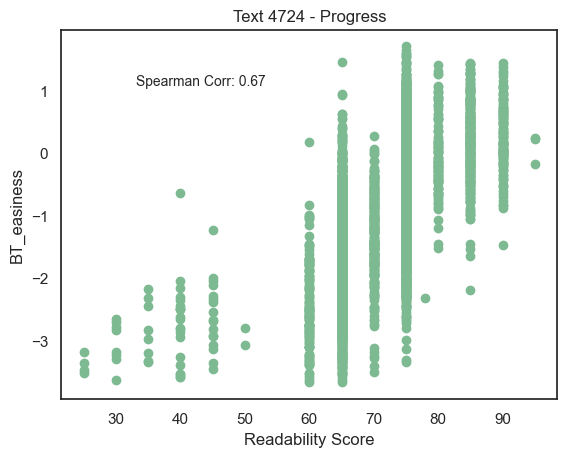

In [27]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

Not bad for a free model! What happens if we use the larger model? Note, this will take a very long time to run for you (probably, it took me 6 hours on a 4080)

In [34]:
modelfile = f'''
FROM gemma2:27b

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced teacher, skilled at identifying the readability of different texts.""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)

{'status': 'success'}

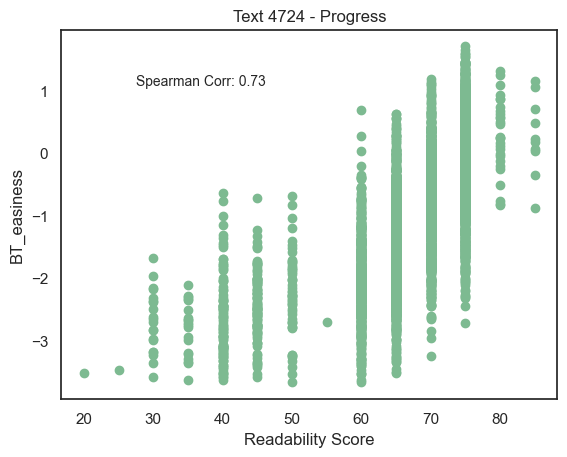

In [35]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

That worked quite a bit better! I would say this is competitive with the closed gpt-4o-mini. Let's try something else. Does separating the instruction and prompt make a difference? We'll use the smaller gemma 2 for the sake of time. The number to beat is 0.67.

In [8]:
import ollama

modelfile = f'''
FROM gemma2

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced teacher, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from 1 (extremely challenging to understand) to 100 (very easy to read and understand). In your assessment, consider factors such as sentence structure, vocabulary complexity, and overall clarity.""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""

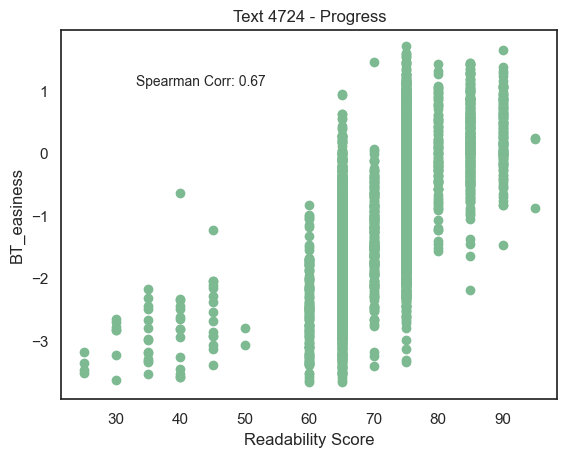

In [9]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

As I alluded to earlier, the results are exactly the same! Let's test out a few more prompts. We use the word "teacher" because that describes the human raters of these excerpts. But perhaps we should try something else...

In [10]:
import ollama

modelfile = f'''
FROM gemma2

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from 1 (extremely challenging to understand) to 100 (very easy to read and understand). In your assessment, consider factors such as sentence structure, vocabulary complexity, and overall clarity.""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""

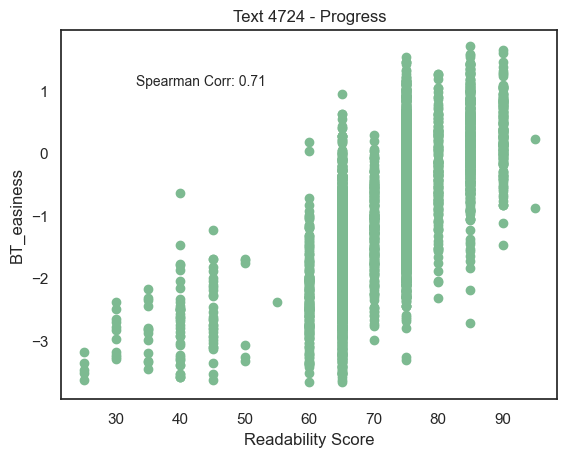

In [11]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

What's next? Well, let's try to shift the predicted values to the same range as our human judgments

In [12]:
import ollama

modelfile = f'''
FROM gemma2

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability. In your assessment, consider factors such as sentence structure, vocabulary complexity, and overall clarity.""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""

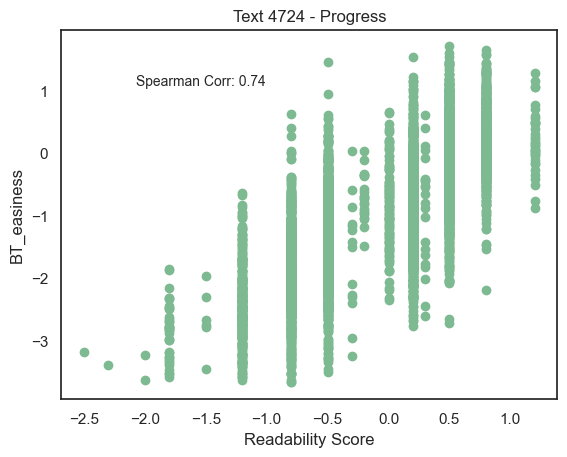

In [13]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

And again now, we get a very strong improvement by changing the scale! Would performance improve further if we gave it more explicit definitions of values?

In [14]:
import ollama

modelfile = f'''
FROM gemma2

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability. In your assessment, consider factors such as sentence structure, vocabulary complexity, and overall clarity.

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability; suitable for the intended grade level.
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts.

""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""

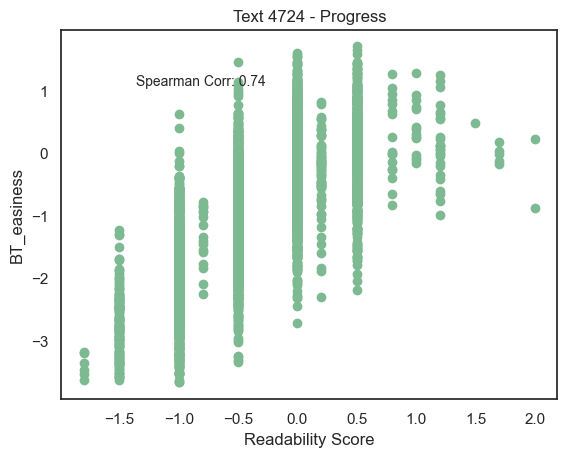

In [15]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

Huh, no difference...well what happens if we ask it to make more nuanced predictions...

In [16]:
import ollama

modelfile = f'''
FROM gemma2

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability. In your assessment, consider factors such as sentence structure, vocabulary complexity, and overall clarity.

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability; suitable for the intended grade level.
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts.

Please consider the entire scale from -3.6 to 1.7, using decimals to designate more nuanced readability assessments.

""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""

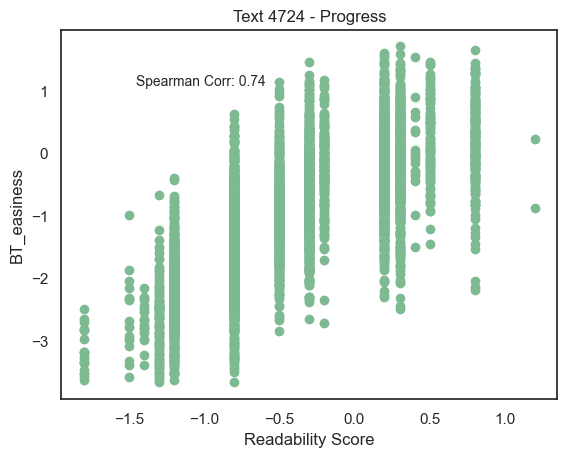

In [17]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

No difference! At least in terms of the correlation. However, there is an improvement not captured by the correlation. The model is capturing a wider distribution of readability scores

Let's try a few other things. For example, let's try adding the word holistically.

In [19]:
import ollama

modelfile = f'''
FROM gemma2

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability. In your assessment, holstically evaluate readability, considering factors such as sentence structure, vocabulary complexity, and overall clarity.

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability; suitable for the intended grade level.
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts.

Please carefully consider the entire scale from -3.6 to 1.7, using precise decimals to designate more nuanced readability assessments.

""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""

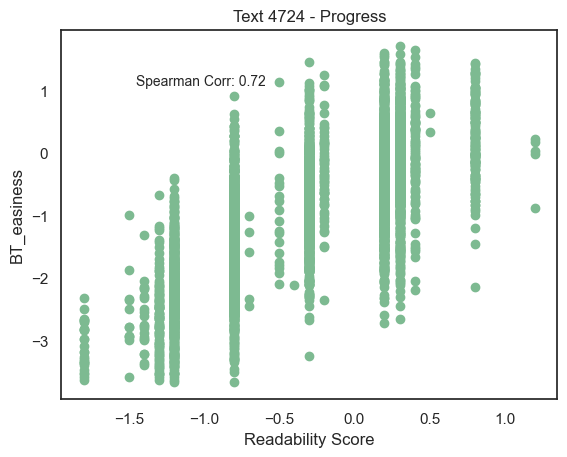

In [20]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

That was not better...okay, how about "objectively"

In [23]:
import ollama

modelfile = f'''
FROM gemma2

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability. In your assessment, consider factors such as sentence structure, vocabulary complexity, and overall clarity.

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability; suitable for the intended grade level.
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts.
""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""

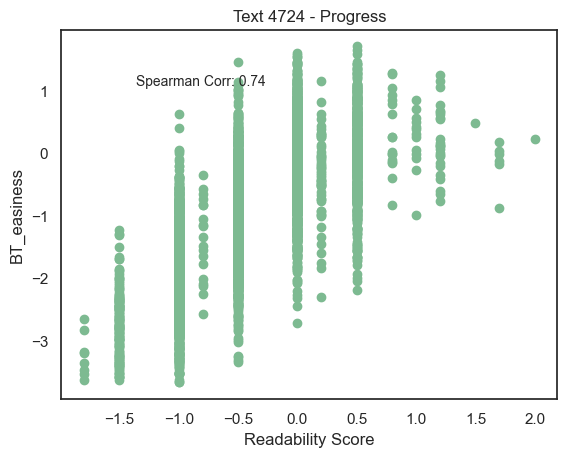

In [25]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

What happens if we use the same prompt with the 27B model?

In [7]:
import ollama

modelfile = f'''
FROM gemma2:27b

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability. In your assessment, consider factors such as sentence structure, vocabulary complexity, and overall clarity.

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability; suitable for the intended grade level.
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts.
""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""

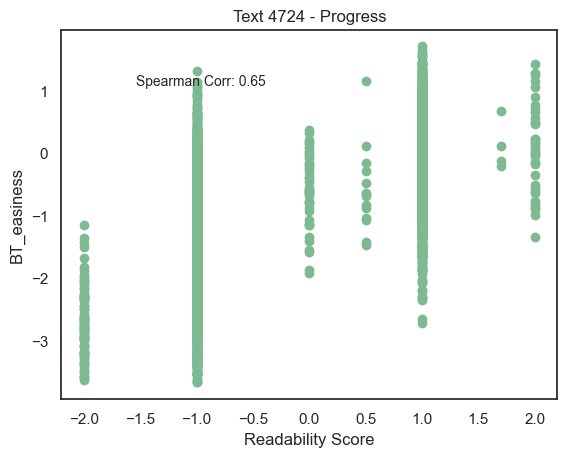

In [8]:

from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

The results are not quite as good. For our next experiment, let's see what happens if we add some examples of readability factors

In [10]:
import ollama

modelfile = f'''
FROM gemma2

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability.

Consider the following when assigning a score:
- **Vocabulary Complexity:** Are the words commonly used, or do they include technical jargon or advanced terminology?
- **Sentence Structure:** Are the sentences simple and straightforward, or complex with multiple clauses?
- **Clarity and Coherence:** Is the text easy to follow and understand, or does it contain ambiguous or convoluted statements?
- **Concept Familiarity:** Does the text discuss common knowledge topics, or does it delve into specialized subjects that may be unfamiliar to the students?

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability; suitable for the intended grade level.
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts.
""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""

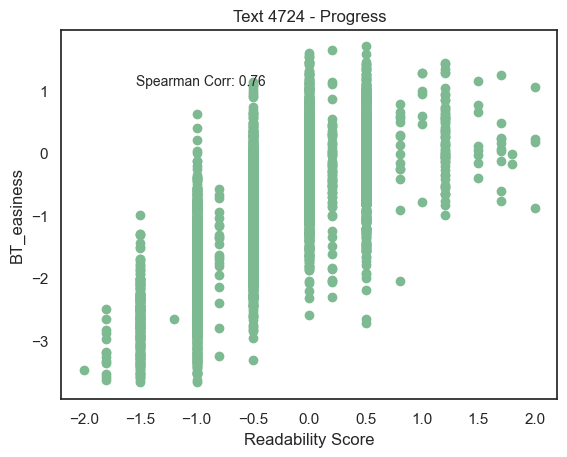

In [11]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

In [6]:
df_sorted = df.sort_values('BT_easiness')
selected_examples = [
    df_sorted.iloc[0],  # Lowest score
    df_sorted.iloc[int(len(df_sorted) * 0.33)],  # 33rd percentile
    df_sorted.iloc[int(len(df_sorted) * 0.67)],  # 67th percentile
    df_sorted.iloc[-1]  # Highest score
]

In [7]:
# Format the examples
examples_formatted = ""
for idx, example in enumerate(selected_examples, 1):
    rounded_score = round(example['BT_easiness'], 2)
    examples_formatted += f"Example {idx}:\nText:\n\"{example['Excerpt']}\"\nReadability Score: {rounded_score}\n\n"

In [8]:
import ollama

modelfile = f'''
FROM gemma2

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability.

Consider the following when assigning a score:
- **Vocabulary Complexity:** Are the words commonly used, or do they include technical jargon or advanced terminology?
- **Sentence Structure:** Are the sentences simple and straightforward, or complex with multiple clauses?
- **Clarity and Coherence:** Is the text easy to follow and understand, or does it contain ambiguous or convoluted statements?
- **Concept Familiarity:** Does the text discuss common knowledge topics, or does it delve into specialized subjects that may be unfamiliar to the students?

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability; suitable for the intended grade level.
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts.

**Examples:**

{examples_formatted}
""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""

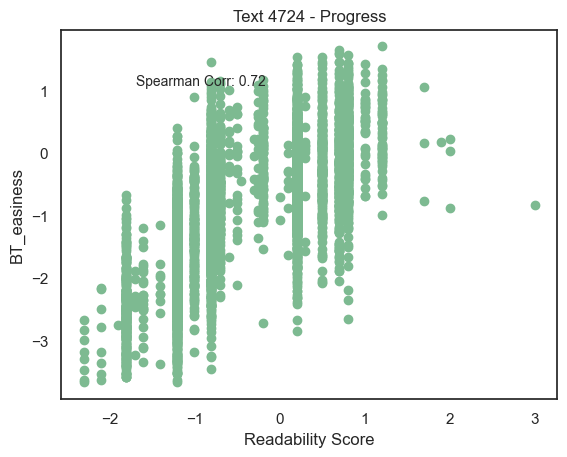

In [9]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

Providing examples did not get us a better result, but there may be a few reasons for this. First, our context window is only ~1500 words. That roughly covers 3 prompts or 2 prompts and instructions. Let's expand the context window and reduce our number of examples to be safe.

In [14]:
df_sorted = df.sort_values('BT_easiness')
selected_examples = [
    df_sorted.iloc[0],  # Lowest score
    df_sorted.iloc[-1]  # Highest score
]
# Format the examples
examples_formatted = ""
for idx, example in enumerate(selected_examples, 1):
    rounded_score = round(example['BT_easiness'], 2)
    examples_formatted += f"Example {idx}:\nText:\n\"{example['Excerpt']}\"\nReadability Score: {rounded_score}\n\n"

In [15]:
import ollama

modelfile = f'''
FROM gemma2

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 3000
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 4096
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability.

Consider the following when assigning a score:
- **Vocabulary Complexity:** Are the words commonly used, or do they include technical jargon or advanced terminology?
- **Sentence Structure:** Are the sentences simple and straightforward, or complex with multiple clauses?
- **Clarity and Coherence:** Is the text easy to follow and understand, or does it contain ambiguous or convoluted statements?
- **Concept Familiarity:** Does the text discuss common knowledge topics, or does it delve into specialized subjects that may be unfamiliar to the students?

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability; suitable for the intended grade level.
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts.

**Examples:**

{examples_formatted}
""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""

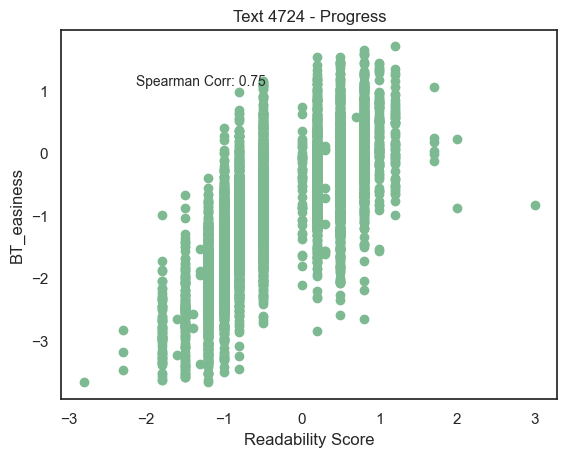

In [16]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

This performs roughly as well as providing no examples so I'm not sure we are gaining much by doing this. Also, note, the model is not completely following our instructions (which told it to make predictions between -3.6 and 1.7, not -3 and 3. For the next experiment, let's remove the examples and toy with expanding our definition of readability for the model. We'll reduce our context again.

In [20]:
import ollama

modelfile = f'''
FROM gemma2

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 4096
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability.

Consider the following when assigning a score:
- **Vocabulary Complexity:** Are the words commonly used, or do they include technical jargon or advanced terminology?
- **Sentence Structure:** Are the sentences simple and straightforward, or complex with multiple clauses?
- **Clarity and Coherence:** Is the text easy to follow and understand, or does it contain ambiguous or convoluted statements?
- **Concept Familiarity:** Does the text discuss common knowledge topics, or does it delve into specialized subjects that may be unfamiliar to the students?
- **Use of Idioms/Colloquialisms: Are idioms or colloquial expressions used appropriately for the audience?
- **Rhythm and Flow: Does the text flow smoothly, or does it feel disjointed or hard to follow?
- **Audience Awareness: Is the text suited to the knowledge level and needs of the audience?
- **Examples and Analogies: Are examples or analogies used effectively to simplify complex ideas?
- **Avoid Ambiguity: Is the language clear and precise, avoiding vagueness?
- **Cultural Sensitivity: Does the text respect diverse perspectives and avoid assumptions?

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability; suitable for the intended grade level.
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts.
""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""

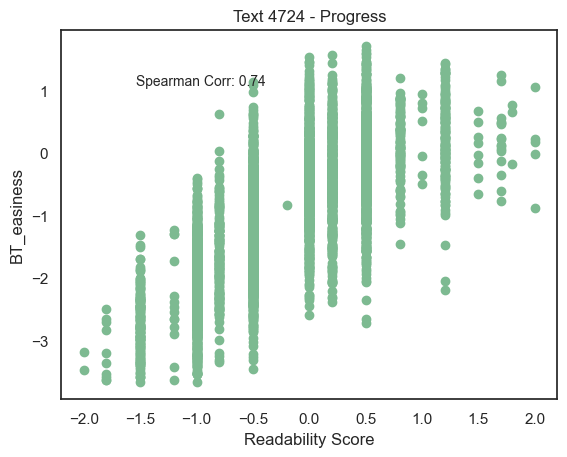

In [21]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

The expanded definition led to a slight decrease in performance. Let's try something else

In [26]:
import ollama

modelfile = f'''
FROM gemma2

PARAMETER stop "\n"
PARAMETER temperature 0
#PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability.

Consider the following when assigning a score:
- **Vocabulary Complexity:** Are the words commonly used, or do they include technical jargon or advanced terminology?
- **Sentence Structure:** Are the sentences simple and straightforward, or complex with multiple clauses?
- **Clarity and Coherence:** Is the text easy to follow and understand, or does it contain ambiguous or convoluted statements?
- **Concept Familiarity:** Does the text discuss common knowledge topics, or does it delve into specialized subjects that may be unfamiliar to the students?
- **Use of Idioms/Colloquialisms: Are idioms or colloquial expressions used appropriately?
- **Rhythm and Flow: Does the text flow smoothly, or does it feel disjointed or hard to follow?
- **Examples and Analogies: Are examples or analogies used effectively to simplify complex ideas?
- **Avoid Ambiguity: Is the language clear and precise, avoiding vagueness?
- **Cultural Sensitivity: Does the text respect diverse perspectives and avoid assumptions?

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability; suitable for the intended grade level.
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts.
""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""

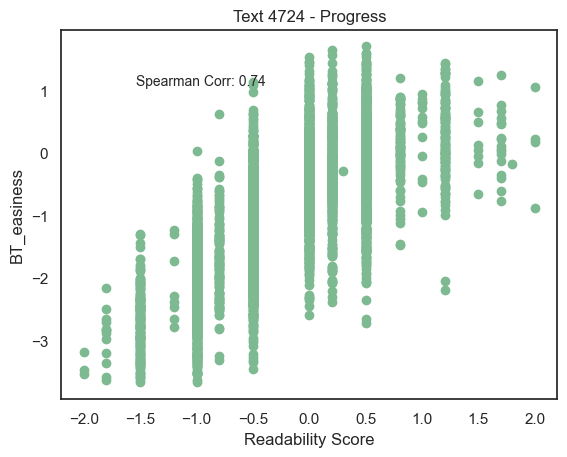

In [27]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

That was not much better. Instead, let's add one item to the original...one at a time.

In [28]:
import ollama

modelfile = f'''
FROM gemma2

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability.

Consider the following when assigning a score:
- **Vocabulary Complexity:** Are the words commonly used, or do they include technical jargon or advanced terminology?
- **Sentence Structure:** Are the sentences simple and straightforward, or complex with multiple clauses?
- **Clarity and Coherence:** Is the text easy to follow and understand, or does it contain ambiguous or convoluted statements?
- **Concept Familiarity:** Does the text discuss common knowledge topics, or does it delve into specialized subjects that may be unfamiliar to the students?
- **Use of Idioms/Colloquialisms: Are idioms or colloquial expressions used appropriately for the audience?

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability; suitable for the intended grade level.
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts.
""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""

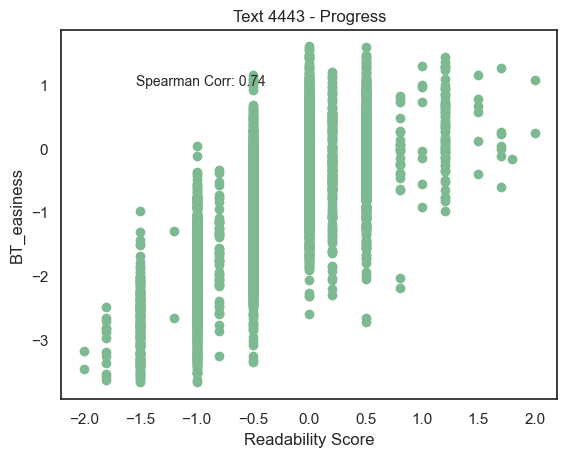

KeyboardInterrupt: 

In [29]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

In [30]:
import ollama

modelfile = f'''
FROM gemma2

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability.

Consider the following when assigning a score:
- **Vocabulary Complexity:** Are the words commonly used, or do they include technical jargon or advanced terminology?
- **Sentence Structure:** Are the sentences simple and straightforward, or complex with multiple clauses?
- **Clarity and Coherence:** Is the text easy to follow and understand, or does it contain ambiguous or convoluted statements?
- **Concept Familiarity:** Does the text discuss common knowledge topics, or does it delve into specialized subjects that may be unfamiliar to the students?
- **Rhythm and Flow: Does the text flow smoothly, or does it feel disjointed or hard to follow?

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability; suitable for the intended grade level.
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts.
""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""

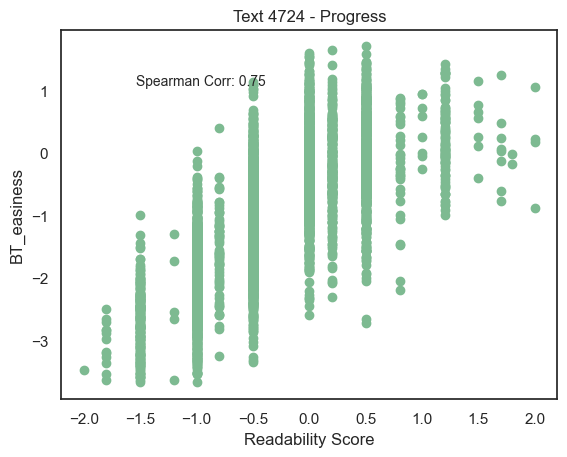

In [31]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

This seems not to be working very well--let's make one small change

In [32]:
import ollama

modelfile = f'''
FROM gemma2

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability.

Consider the following non-exhaustive factors contributing to readability when assigning a score:
- **Vocabulary Complexity:** Are the words commonly used, or do they include technical jargon or advanced terminology?
- **Sentence Structure:** Are the sentences simple and straightforward, or complex with multiple clauses?
- **Clarity and Coherence:** Is the text easy to follow and understand, or does it contain ambiguous or convoluted statements?
- **Concept Familiarity:** Does the text discuss common knowledge topics, or does it delve into specialized subjects that may be unfamiliar to the students?

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability; suitable for the intended grade level.
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts.
""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""

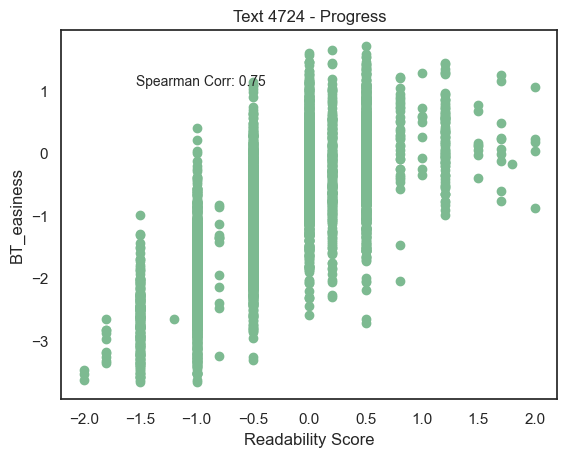

In [33]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

That did not make much of a difference. Switching gears, let's test other open models now. We'll start with llama3.1

In [36]:
import ollama

modelfile = f'''
FROM llama3.1

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability.

Consider the following when assigning a score:
- **Vocabulary Complexity:** Are the words commonly used, or do they include technical jargon or advanced terminology?
- **Sentence Structure:** Are the sentences simple and straightforward, or complex with multiple clauses?
- **Clarity and Coherence:** Is the text easy to follow and understand, or does it contain ambiguous or convoluted statements?
- **Concept Familiarity:** Does the text discuss common knowledge topics, or does it delve into specialized subjects that may be unfamiliar to the students?

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability; suitable for the intended grade level.
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts.

Only provide the numerical readability score. Do not include any additional commentary or analysis.
""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""

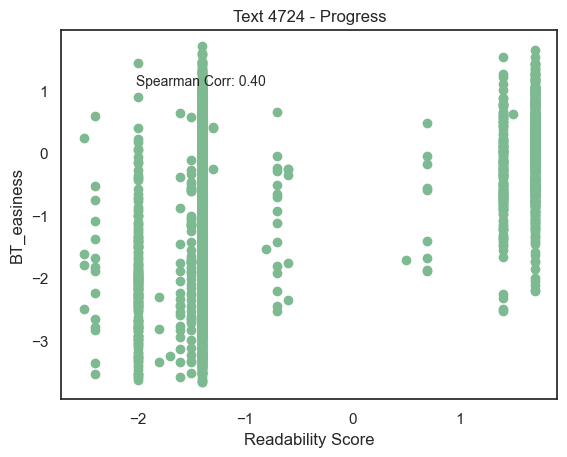

In [37]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

Llama3.1 was not super great, about half as good as gemma2. But now let's try mistral-nemo (make sure you have this model set up in the same way we set up gemma2).

In [38]:
import ollama

modelfile = f'''
FROM mistral-nemo

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability.

Consider the following when assigning a score:
- **Vocabulary Complexity:** Are the words commonly used, or do they include technical jargon or advanced terminology?
- **Sentence Structure:** Are the sentences simple and straightforward, or complex with multiple clauses?
- **Clarity and Coherence:** Is the text easy to follow and understand, or does it contain ambiguous or convoluted statements?
- **Concept Familiarity:** Does the text discuss common knowledge topics, or does it delve into specialized subjects that may be unfamiliar to the students?

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability; suitable for the intended grade level.
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts.

Only provide the numerical readability score. Do not include any additional commentary or analysis.
""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""

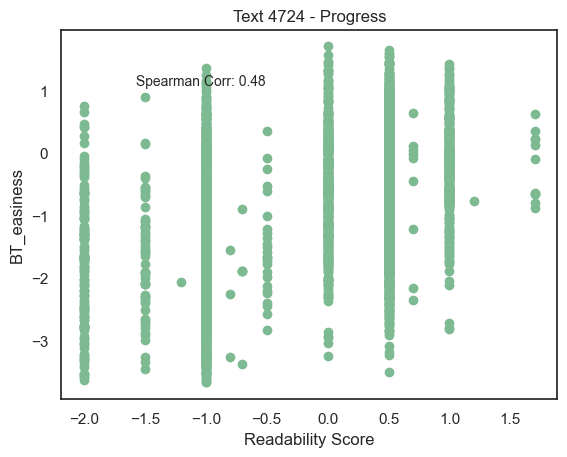

In [39]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

Now let's try qwen2

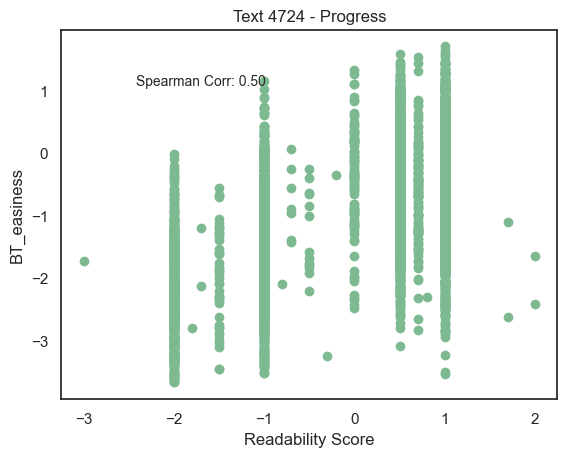

In [40]:
import ollama

modelfile = f'''
FROM qwen2

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability.

Consider the following when assigning a score:
- **Vocabulary Complexity:** Are the words commonly used, or do they include technical jargon or advanced terminology?
- **Sentence Structure:** Are the sentences simple and straightforward, or complex with multiple clauses?
- **Clarity and Coherence:** Is the text easy to follow and understand, or does it contain ambiguous or convoluted statements?
- **Concept Familiarity:** Does the text discuss common knowledge topics, or does it delve into specialized subjects that may be unfamiliar to the students?

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability; suitable for the intended grade level.
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts.

Only provide the numerical readability score. Do not include any additional commentary or analysis.
""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

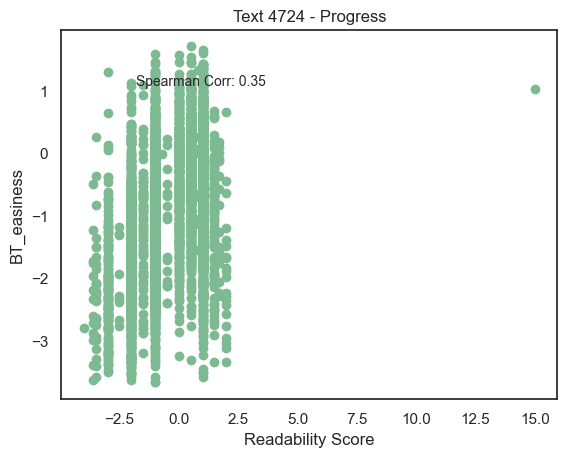

In [41]:
import ollama

modelfile = f'''
FROM phi3.5

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

# PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability.

Consider the following when assigning a score:
- **Vocabulary Complexity:** Are the words commonly used, or do they include technical jargon or advanced terminology?
- **Sentence Structure:** Are the sentences simple and straightforward, or complex with multiple clauses?
- **Clarity and Coherence:** Is the text easy to follow and understand, or does it contain ambiguous or convoluted statements?
- **Concept Familiarity:** Does the text discuss common knowledge topics, or does it delve into specialized subjects that may be unfamiliar to the students?

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability; suitable for the intended grade level.
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts.

Only provide the numerical readability score. Do not include any additional commentary or analysis.
""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

Phi3.5 is a bit iffy--if you take a closer look at the output, it's hard to wrangle and often hallucinates. You can see this represented above with some predictions well outside the range we requested.

In [52]:
import ollama

modelfile = f'''
FROM hermes3

PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability.

Consider the following when assigning a score:
- **Vocabulary Complexity:** Are the words commonly used, or do they include technical jargon or advanced terminology?
- **Sentence Structure:** Are the sentences simple and straightforward, or complex with multiple clauses?
- **Clarity and Coherence:** Is the text easy to follow and understand, or does it contain ambiguous or convoluted statements?
- **Concept Familiarity:** Does the text discuss common knowledge topics, or does it delve into specialized subjects that may be unfamiliar to the students?

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability; suitable for the intended grade level.
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts.

Only provide the numerical readability score. Do not include any additional commentary or analysis. Do not produce any text.
""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""

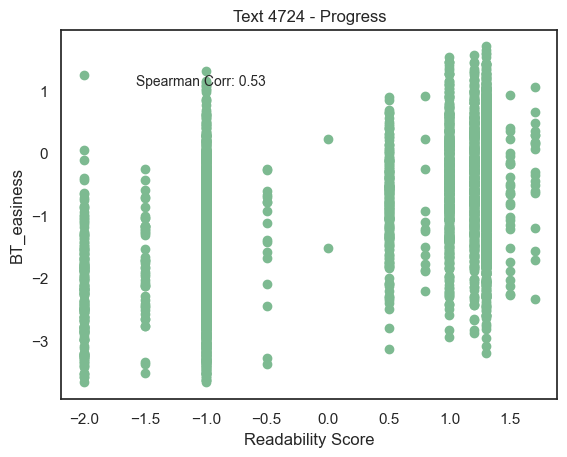

In [53]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

In [44]:
import ollama

modelfile = f'''
FROM command-r

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability.

Consider the following when assigning a score:
- **Vocabulary Complexity:** Are the words commonly used, or do they include technical jargon or advanced terminology?
- **Sentence Structure:** Are the sentences simple and straightforward, or complex with multiple clauses?
- **Clarity and Coherence:** Is the text easy to follow and understand, or does it contain ambiguous or convoluted statements?
- **Concept Familiarity:** Does the text discuss common knowledge topics, or does it delve into specialized subjects that may be unfamiliar to the students?

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability; suitable for the intended grade level.
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts.

Only provide the numerical readability score. Do not include any additional commentary or analysis.
""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""

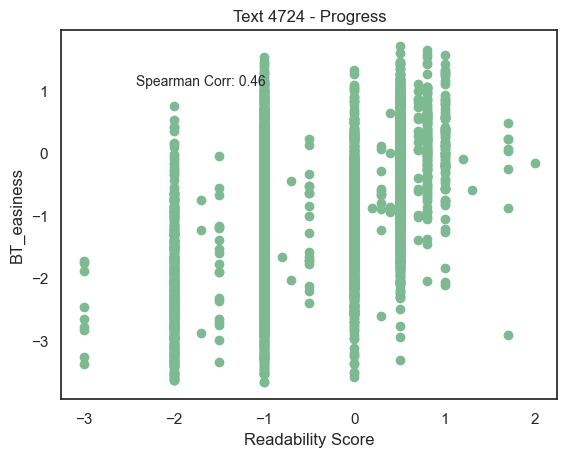

In [45]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

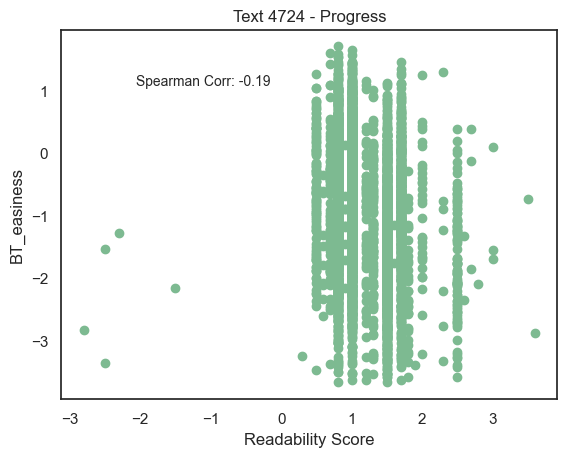

In [54]:
import ollama

modelfile = f'''
FROM mistral

PARAMETER stop "\n"
PARAMETER temperature 0
PARAMETER num_ctx 2048
# context size. 2000 tokens is more than enough for an average excerpt plus instructions and prompt: 1 token is ~ 4 characters or 0.75 words so 2000 tokens = ~1,500 words

PARAMETER num_batch 2048
# batch size for processing on GPU. If you have a nice GPU, increase
# Adjust num_ctx and num_batch, preferably in multiples like this for better performance: 8192 4096 2048

# System message that guides the model's behavior
SYSTEM  """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability.

Consider the following when assigning a score:
- **Vocabulary Complexity:** Are the words commonly used, or do they include technical jargon or advanced terminology?
- **Sentence Structure:** Are the sentences simple and straightforward, or complex with multiple clauses?
- **Clarity and Coherence:** Is the text easy to follow and understand, or does it contain ambiguous or convoluted statements?
- **Concept Familiarity:** Does the text discuss common knowledge topics, or does it delve into specialized subjects that may be unfamiliar to the students?

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability; suitable for the intended grade level.
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts.

Only provide the numerical readability score. Do not include any additional commentary or analysis.
""" '''
ollama.create(model='readabilityModel', modelfile=modelfile)
instructions = ""
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

readability_scores = []
bt_easiness_scores = []
results = []

fig, ax = plt.subplots()

# Process each excerpt in the dataset
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Combine the instructions with the input text
        prompt = f"{instructions}\n\n{input_text}"

        # Generate the response from the model
        out = ollama.generate(model='readabilityModel', prompt=prompt)

        # Extract score from response
        score = extract_score(out['response'])

        # If a valid score is found, append to results, else log the error
        if score is not None:
            results.append({'Excerpt': input_text, 'Readability_Score': score})
            readability_scores.append(score)
            bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Using easiness values from the df

            # Clear previous output (to simulate real-time plotting in inline backend)
            clear_output(wait=True)

            # Create a new plot
            fig, ax = plt.subplots()

            # Plot the updated scatter plot
            ax.scatter(readability_scores, bt_easiness_scores)
            ax.set_title(f'Text {i} - Progress')
            ax.set_xlabel('Readability Score')
            ax.set_ylabel('BT_easiness')

            # Check for constant data before calculating Spearman correlation
            if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                ax.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=ax.transAxes, fontsize=10)

            # Update the figure
            plt.show()
        else:
            print(out['response'])
    except Exception as e:
        print(f"Error processing text {i}: {e}")

## **Below, let's try Anthropic on the prompt tuned for gemma2**

In [21]:
import re
import anthropic
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.stats import spearmanr

In [24]:
def extract_score(response):
    # Check if response is a list and contains a TextBlock-like object
    if isinstance(response, list) and len(response) > 0 and hasattr(response[0], 'text'):
        try:
            # Extract the text (score) and convert it to a float if possible
            return float(response[0].text)
        except ValueError:
            print(f"Unable to convert response to a float: {response[0].text}")
            return None
    return None


In [25]:
instructions = """You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts. Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability.

Consider the following when assigning a score:
- **Vocabulary Complexity:** Are the words commonly used, or do they include technical jargon or advanced terminology?
- **Sentence Structure:** Are the sentences simple and straightforward, or complex with multiple clauses?
- **Clarity and Coherence:** Is the text easy to follow and understand, or does it contain ambiguous or convoluted statements?
- **Concept Familiarity:** Does the text discuss common knowledge topics, or does it delve into specialized subjects that may be unfamiliar to the students?

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability; suitable for the intended grade level.
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts.

Only provide the numerical readability score. Do not include any additional commentary or analysis.
"""

In [26]:
def generate_claude_response(prompt, input, model="claude-3-5-sonnet-20240620"):
    try:
        # API call to Claude
        message = client.messages.create(
            model=model,  # Using the model passed as an argument
            max_tokens=2048,
            temperature=0,
            system=prompt,
            messages=[
                {
                    "role": "user",
                    "content": input  # This should be a string, not a list or dict
                }
            ]
        )  # Closing the client call properly here
        return message.content if message.content else None
    except Exception as e:
        print(f"Error in API request: {e}")
        return None

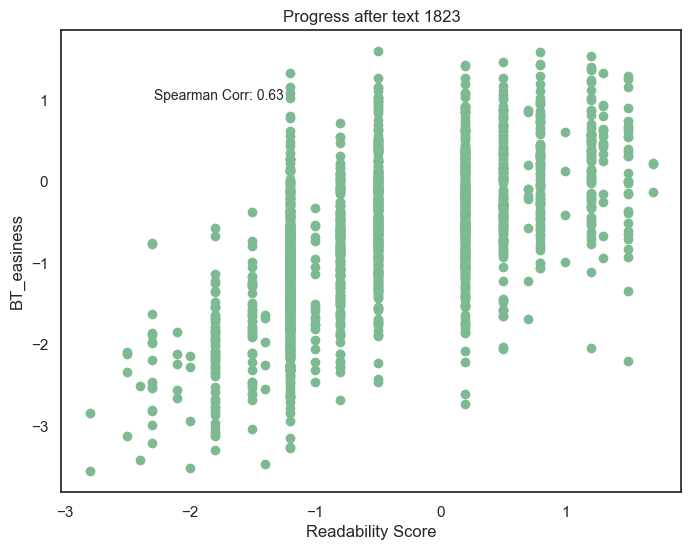

KeyboardInterrupt: 

In [82]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from IPython.display import clear_output

# Assuming df is a DataFrame that has columns 'Excerpt' and 'BT_easiness'
# Also assuming 'extract_score' is a function you have to extract the readability score from the API response.

# Initialize lists to store results
readability_scores = []
bt_easiness_scores = []

# Example dataset with excerpts and easiness scores (assuming you have a pandas DataFrame df)
for i, input_text in enumerate(df['Excerpt'], start=1):
    try:
        # Generate the response from Claude 3.5
        out = generate_claude_response(instructions, input_text)

        # Check if a valid response was received
        if out is not None:
            # Extract score from the response
            score = extract_score(out)

            # If a valid score is found, append to results, else log the error
            if score is not None:
                readability_scores.append(score)
                bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Easiness score from DataFrame

                # Clear previous output (for real-time plotting)
                clear_output(wait=True)

                # Create a new scatter plot
                plt.figure(figsize=(8, 6))
                plt.scatter(readability_scores, bt_easiness_scores)
                plt.title(f'Progress after text {i}')
                plt.xlabel('Readability Score')
                plt.ylabel('BT_easiness')

                # Compute Spearman correlation if there is enough variability
                if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                    spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                    plt.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=plt.gca().transAxes, fontsize=10)
                else:
                    plt.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=plt.gca().transAxes, fontsize=10)

                # Show the updated plot
                plt.show()
            else:
                print(f"No valid score extracted from response: {out}")
        else:
            print(f"Error: Response for text {i} was None.")
    except Exception as e:
        print(f"Error processing text {i}: {e}")


Like me, you may have hit anthropic's tier 1 API limit. We'll save our results and revisit once it clears...

In [89]:
df_tmp = pd.DataFrame(readability_scores, columns=['Readability Scores'])
df_tmp.to_csv(r'C:\Users\alext\Downloads\CLEAR-Corpus-main\CLEAR-Corpus-main\AnthropicReadability_paused.csv', index=False)

Now we can revisit here...

In [18]:
import pandas as pd
df_tmp = pd.read_csv(r'C:\Users\alext\Downloads\CLEAR-Corpus-main\CLEAR-Corpus-main\AnthropicReadability_paused.csv')
readability_scores = df_tmp['Readability Scores'].tolist()
length_of_readability_scores = len(readability_scores)
bt_easiness_scores = df['BT_easiness'][:length_of_readability_scores].tolist()

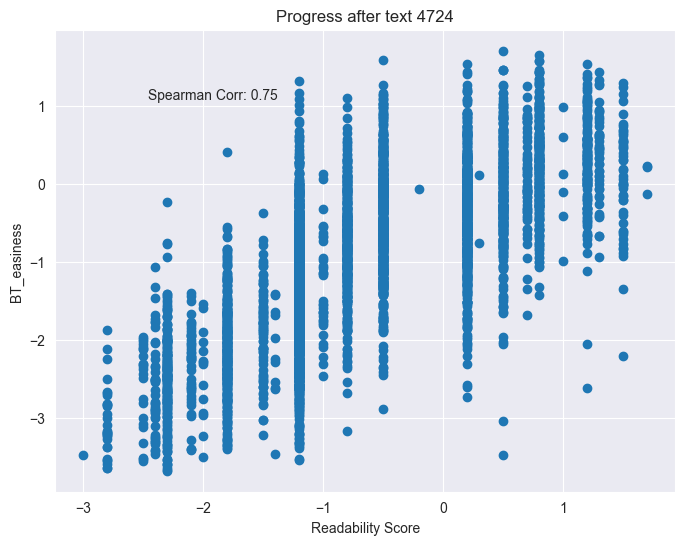

In [27]:
# Get the length of readability_scores to determine where to resume
start_idx = len(readability_scores)
# Example dataset with excerpts and easiness scores (assuming you have a pandas DataFrame df)
for i, input_text in enumerate(df['Excerpt'][start_idx:], start=start_idx+1):
    try:
        # Generate the response from Claude 3.5
        out = generate_claude_response(instructions, input_text)

        # Check if a valid response was received
        if out is not None:
            # Extract score from the response
            score = extract_score(out)

            # If a valid score is found, append to results, else log the error
            if score is not None:
                readability_scores.append(score)
                bt_easiness_scores.append(df['BT_easiness'][i - 1])  # Easiness score from DataFrame

                # Clear previous output (for real-time plotting)
                clear_output(wait=True)

                # Create a new scatter plot
                plt.figure(figsize=(8, 6))
                plt.scatter(readability_scores, bt_easiness_scores)
                plt.title(f'Progress after text {i}')
                plt.xlabel('Readability Score')
                plt.ylabel('BT_easiness')

                # Compute Spearman correlation if there is enough variability
                if len(set(readability_scores)) > 1 and len(set(bt_easiness_scores)) > 1:
                    spearman_corr, _ = spearmanr(readability_scores, bt_easiness_scores)
                    plt.text(0.15, 0.85, f'Spearman Corr: {spearman_corr:.2f}', transform=plt.gca().transAxes, fontsize=10)
                else:
                    plt.text(0.15, 0.85, 'Spearman Corr: N/A (constant data)', transform=plt.gca().transAxes, fontsize=10)

                # Show the updated plot
                plt.show()
            else:
                print(f"No valid score extracted from response: {out}")
        else:
            print(f"Error: Response for text {i} was None.")
    except Exception as e:
        print(f"Error processing text {i}: {e}")

In [22]:
# Initialize the Anthropic client
client = anthropic.Anthropic(
    api_key=""  # Replace with your actual Claude API key
)

In [31]:
df_tmp = pd.DataFrame(readability_scores, columns=['Readability Scores'])
df_tmp.to_csv(r'C:\Users\alext\Downloads\CLEAR-Corpus-main\CLEAR-Corpus-main\AnthropicReadability_finished.csv', index=False)

## **Finally, We Will Come Back to GPT-4o-mini, Testing the Prompt That Worked Best for Gemma 2**

In [45]:
openai.api_key = ""
client = OpenAI(api_key=openai.api_key)

We are going to try something slightly different here. First, I noticed that gpt4o-mini does not make as wide a range of predictions as gemma2 so we will add some instructions for this. Also, we had been working with batches. Here, we'll reformat the prompt to be less redundant.

In [56]:
def format_prompt(instructions, texts):
    formatted_texts = "\n\n".join(f"<Text{i+1}>:{text}</Text{i+1}>" for i, text in enumerate(texts))
    return f"{instructions}\n\n{formatted_texts}\n\nRespond only with the score and please consider the full possible range of scores."

@backoff.on_exception(backoff.expo, openai.RateLimitError, max_tries=5)
def process_batch(batch, system_prompt, instructions, model="gpt-4o-mini", temperature=0):
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": format_prompt(instructions, batch)}
    ]
    try:
        completion = client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=temperature,
            n=1
        )

        # Ensure the response has valid choices
        if not completion.choices or not completion.choices[0]:
            return [None] * len(batch)

        # Get the content of the message (readability score)
        response = completion.choices[0].message.content.strip()

        # Try parsing the response into scores
        scores = []
        for line in response.split('\n'):
            try:
                score = float(line.strip())
                scores.append(score)
            except ValueError:
                scores.append(None)

        if len(scores) != len(batch):
            return [None] * len(batch)

        return scores
    except Exception as e:
        return [None] * len(batch)

In [57]:
MODEL = "gpt-4o-mini-2024-07-18"
BATCH_SIZE = 1  # Adjust based on API limits and your needs
system_prompt = "You are an experienced expert in writing and linguistics, skilled at identifying the readability of different texts."
instructions = """Read the text below. Then, indicate the readability of the text, on a scale from -3.6 (extremely challenging to understand) to 1.7 (very easy to read and understand), with 0 reflecting average readability.

Consider the following non-exhaustive list of factors contributing to readability when assigning a score:
- **Vocabulary Complexity:** Are the words commonly used, or do they include technical jargon or advanced terminology?
- **Sentence Structure:** Are the sentences simple and straightforward, or complex with multiple clauses?
- **Clarity and Coherence:** Is the text easy to follow and understand, or does it contain ambiguous or convoluted statements?
- **Concept Familiarity:** Does the text discuss common knowledge topics, or does it delve into specialized subjects that may be unfamiliar to the students?

**Scoring Guidelines:**
- **-3.0:** Significantly more difficult to read than average; likely requires advanced reading skills or specialized knowledge.
- **-2.0:** More difficult to read than average; contains complex vocabulary and sentence structures.
- **-1.0:** Slightly more difficult than average; some complex terms but generally understandable.
- **0.0:** Average readability
- **1.0:** Slightly easier to read than average; clear language and straightforward sentences.
- **2.0:** Significantly easier to read than average; very simple language and concepts."""


In [58]:
excerpts = df['Excerpt'].tolist()
batches = [excerpts[i:i + BATCH_SIZE] for i in range(0, len(excerpts), BATCH_SIZE)]

In [59]:
# Main loop
results = []
for batch in tqdm(batches, total=len(batches)):
    batch_results = process_batch(batch, system_prompt, instructions, MODEL)

    # If the batch result is incomplete, retry failed excerpts individually
    if len(batch_results) != len(batch) or any(result is None for result in batch_results):
        print(f"Retrying failed excerpts in the batch...")
        for i, result in enumerate(batch_results):
            if result is None:
                individual_result = process_batch([batch[i]], system_prompt, instructions, MODEL)

                # Ensure the individual result is valid before assigning
                if individual_result and len(individual_result) > 0:
                    batch_results[i] = individual_result[0]
                else:
                    print(f"Failed to process individual result for batch index {i}")

    results.extend(batch_results)
    time.sleep(1)  # Small delay to avoid rate limiting

100%|██████████| 4724/4724 [1:57:51<00:00,  1.50s/it]  


In [60]:
results_df = pd.DataFrame(np.array(results), columns=['4ominiNewPromp'])
df_merged = pd.merge(results_df, df, left_index=True, right_index=True)
df_merged.to_csv(r'C:\Users\alext\Downloads\CLEAR-Corpus-main\CLEAR-Corpus-main\4ominiNewPrompt.csv', index=False)

In [61]:
# Calculate correlations
from scipy import stats
pearson_corr, pearson_p = stats.pearsonr(df_merged['4ominiNewPromp'], df['BT_easiness'])
spearman_corr, spearman_p = stats.spearmanr(df_merged['4ominiNewPromp'], df['BT_easiness'])

print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

Pearson correlation: 0.743 (p-value: 0.000)
Spearman correlation: 0.756 (p-value: 0.000)


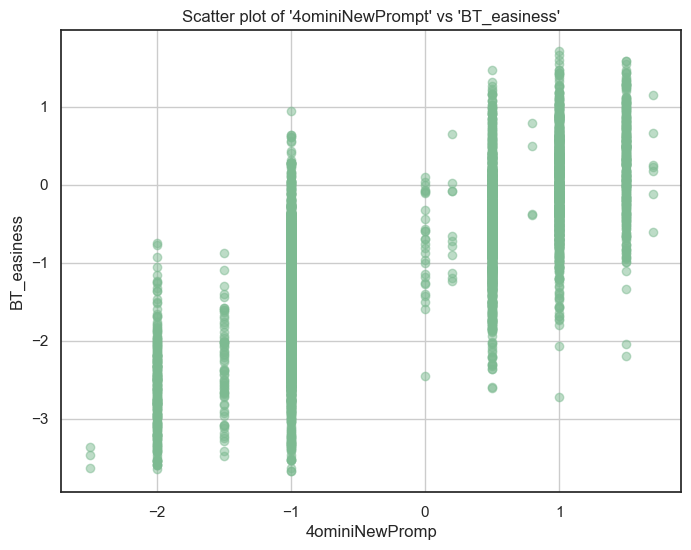

In [64]:
plt.figure(figsize=(8, 6))
plt.scatter(df_merged['4ominiNewPromp'], df['BT_easiness'],alpha=0.5)
plt.title("Scatter plot of '4ominiNewPrompt' vs 'BT_easiness'")
plt.xlabel("4ominiNewPromp")
plt.ylabel("BT_easiness")
plt.grid(True)
plt.show()

A very interesting result! Gemma2 achieves identical performance with the same prompt as GPT4o-mini. However, GPT4o-mini got better performance with a simpler prompt. A few final thoughts to keep in mind:

1. Different prompts might better suit different models so you should keep that in mind when interpreting our results here
2. Using the above prompt, gemma2 may be preferable as it makes a wider range of predictions
3. LLMs can certainly capture human readability with some success but the fact is that they are not as good as a real human. For example, plenty of excerpts rated to be below-average in readability by humans (i.e., below zero on the y-axis) were rated above-average by our models (i.e., above zero on the x-axis). For important work, maybe retain your editor:)

Anyways, here's what our results end up looking like when taken together (generally using the best performing prompts for each model)

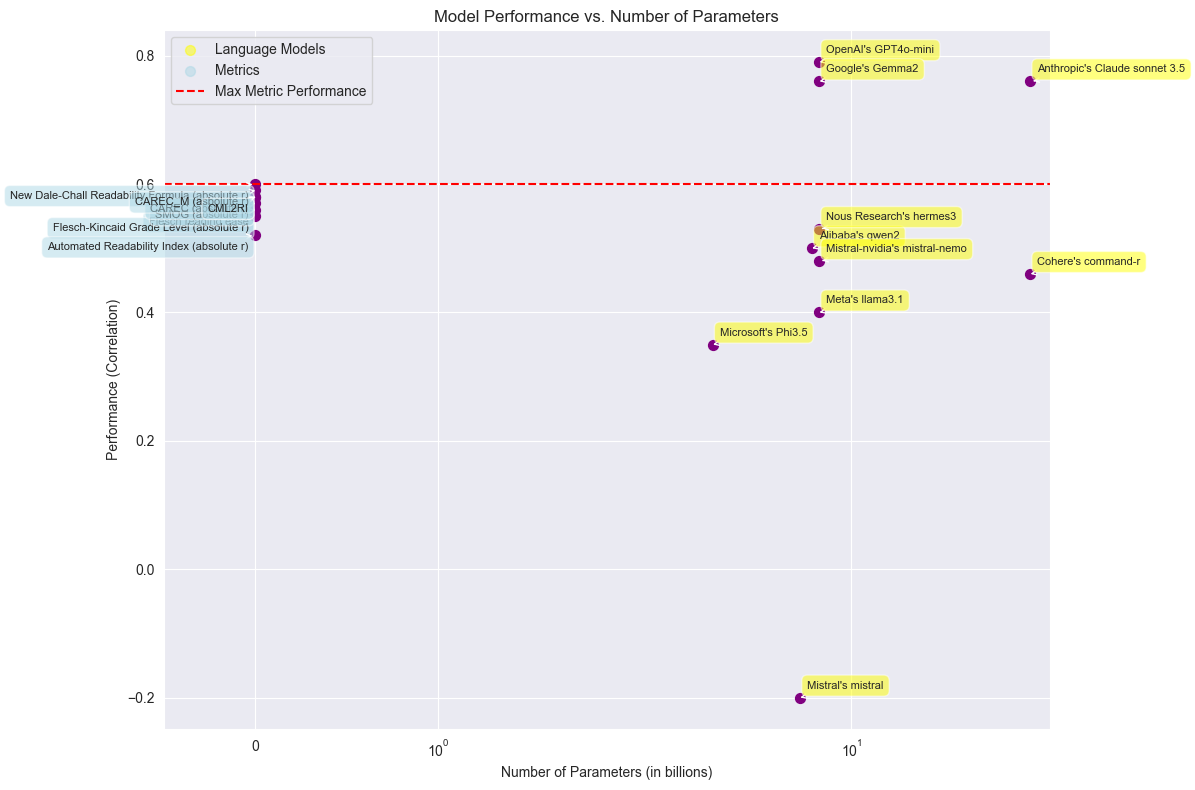

In [47]:
import matplotlib.pyplot as plt
import numpy as np

models = [
    "Microsoft's Phi3.5", "Alibaba's qwen2", "Mistral-nvidia's mistral-nemo",
    "Meta's llama3.1", "Nous Research's hermes3", "Cohere's command-r",
    "Mistral's mistral", "Anthropic's Claude sonnet 3.5", "OpenAI's GPT4o-mini",
    "Google's Gemma2", "Flesch reading ease", "Flesch-Kincaid Grade Level (absolute r)",
    "Automated Readability Index (absolute r)", "SMOG (absolute r)",
    "New Dale-Chall Readability Formula (absolute r)", "CAREC (absolute r)",
    "CAREC_M (asbolute r)", "CML2RI"
]

performance = [0.35, 0.5, 0.48, 0.4, 0.53, 0.46, -0.2, 0.76, 0.79, 0.76, 0.56, 0.55, 0.52, 0.57, 0.6, 0.58, 0.59, 0.58]
parameters = [3.8, 7.6, 8, 8, 8, 35, 7, 35, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0]

plt.figure(figsize=(12, 8))
scatter = plt.scatter(parameters, performance, s=50, color='purple')  # Changed dot color to purple

# Separate LLMs and metrics
llms = models[:10]
metrics = models[10:]

# Calculate the maximum performance of metrics
max_metric_performance = max(performance[10:])

# Add horizontal line at the maximum metric performance
plt.axhline(y=max_metric_performance, color='r', linestyle='--', label='Max Metric Performance')

# Annotate LLMs
for i, model in enumerate(llms):
    plt.annotate(model, (parameters[i], performance[i]),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=8, ha='left', va='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Annotate metrics
for i, metric in enumerate(metrics, start=10):
    plt.annotate(metric, (parameters[i], performance[i]),
                 xytext=(-5, -5), textcoords='offset points',
                 fontsize=8, ha='right', va='top',
                 bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.ylabel('Performance (Correlation)')
plt.xlabel('Number of Parameters (in billions)')
plt.title('Model Performance vs. Number of Parameters')

# Adjust x-axis to show more detail for lower parameter values
plt.xscale('symlog')
plt.xlim(-0.5, 40)

# Add a legend to distinguish LLMs from metrics and the threshold line
llm_proxy = plt.scatter([], [], s=50, c='yellow', alpha=0.5, label='Language Models')
metric_proxy = plt.scatter([], [], s=50, c='lightblue', alpha=0.5, label='Metrics')
plt.legend(handles=[llm_proxy, metric_proxy, plt.Line2D([0], [0], color='r', linestyle='--', label='Max Metric Performance')])

plt.tight_layout()
plt.show()